## Testing

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import iapws95_light
iapws95_light.print_verification_values()

Test case 1: rho = 838.025 kg m^{-3}, T = 500 K
Computed: 
phi0    |  2.047977335 | phir    | -3.426932057
phi0_d  |  0.384236747 | phir_d  | -0.364366650
phi0_dd | -0.147637878 | phir_dd |  0.856063701
phi0_t  |  9.046111062 | phir_t  | -5.814034352
phi0_tt | -1.932491850 | phir_tt | -2.234407369
phi0_dt |  0.000000000 | phir_dt | -1.121769147
Reference (9 significant figures): 
phi0    |  2.047977340 | phir    | -3.426932060
phi0_d  |  0.384236747 | phir_d  | -0.364366650
phi0_dd | -0.147637878 | phir_dd |  0.856063701
phi0_t  |  9.046111060 | phir_t  | -5.814034350
phi0_tt | -1.932491850 | phir_tt | -2.234407370
phi0_dt |  0.000000000 | phir_dt | -1.121769150

Test case 2: rho = 358 kg m^{-3}, T = 647 K
Computed: 
phi0    | -1.563196051 | phir    | -1.212026565
phi0_d  |  0.899441341 | phir_d  | -0.714012024
phi0_dd | -0.808994726 | phir_dd |  0.475730696
phi0_t  |  9.803439179 | phir_t  | -3.217225008
phi0_tt | -3.433163341 | phir_tt | -9.960295066
phi0_dt |  0.000000000 | phir_dt 

In [3]:
iapws95_light.print_timing()

Timing p(rho, T) calculations for scalar input.
iapws95_light: 362.8156861111112 us
Ideal gas    : 0.3697305555555709 us
Relative load: 981.298x
=== Additional details ===
Number of coefficients in model: 247
Relative load per model dof:     3.973x


In [4]:
import iapws

p_ref = 1e6
T_ref = 300
print(f"iapws.py: Reference density of {iapws.IAPWS95(P=p_ref/1e6, T=T_ref).rho}")
# Set reference density in platofmr-independent way
rho_ref = 996.9600226950664

''' Cross-verification '''
# Finite difference check for phi implementation
d = 996.9600226950664 / iapws95_light.rhoc
t = iapws95_light.Tc / T_ref
_finite_diff_soln = 0.5*(iapws95_light.phir(d + 1e-5, iapws95_light.Tc/300) \
  - iapws95_light.phir(d - 1e-5, iapws95_light.Tc/300))/1e-5
print(f"phir_d eval: {iapws95_light.phir_d(d, iapws95_light.Tc/300) [0]}")
print(f"Finite diff: {_finite_diff_soln[0]}")

# Forward check of pressure routine
print(f"Reference pressure: {p_ref}")
print(f"Computed pressure:  {iapws95_light.p(rho_ref, T_ref)}")

crossverif_obj = iapws.IAPWS95(rho=rho_ref, T=T_ref)
phir = iapws95_light.phir(d, t)[0]
phi0 = iapws95_light.phi0(d, t)[0]
crossverf_phir = crossverif_obj._phir(crossverif_obj.Tc/T_ref,
  rho_ref/crossverif_obj.rhoc)["fir"]
crossverf_phi0 = crossverif_obj._phi0(crossverif_obj.Tc/T_ref,
  rho_ref/crossverif_obj.rhoc)["fio"]

print(f"Computed phir:  {phir}")
print(f"Reference phir: {crossverf_phir}")
print(f"Computed phi0:  {phi0}")
print(f"Reference phi0: {crossverf_phi0}")

iapws.py: Reference density of 996.9600226950664
phir_d eval: -0.32064199447122377
Finite diff: -0.3206419957990647
Reference pressure: 1000000.0
Computed pressure:  1000000.0001630188
Computed phir:  -9.573781605341168
Reference phir: -9.573781605342393
Computed phi0:  9.535031422672684
Reference phi0: 9.535031422672684


In [ ]:
# Unphysical test: attempt to compute pressure using Helmholtz within mixed
#   phase
print(f"Attempted p:  {iapws95_light.p(859.6317217178832, T_ref)}")
print(f"Reference p:  {iapws.IAPWS95(rho=859.6317217178832, T=T_ref).P*1e6}")
print(f"Saturation p: {iapws95_light.prho_sat(T_ref)[0][0]}")

In [ ]:
# Iterative thermodynamic functions test
print(f"Density at 0.9 MPa, 300 K: {iapws95_light.rho_pt(0.9e6, 300)[0]}")

# Compute saturation curves
range_T = np.linspace(273.15, iapws95_light.Tc, 25)
rhol, rhov = iapws95_light.get_saturation_density_curves(range_T)
# Define sampling range for mixed phase
coord_range = np.linspace(0,1,7)
mg_T, mg_rho = np.meshgrid(range_T, coord_range)
mg_x = np.zeros_like(mg_T)
# Compute vapour mass fraction using iapws95_light.x
for i, j in np.ndindex(mg_T.shape):
  mg_rho[i,j] = rhov[j] + coord_range[i] * (rhol[j] - rhov[j])
  mg_x[i,j] = iapws95_light.x(mg_rho[i,j], mg_T[i,j])

plt.figure(1)
# Show mass fraction inside mixed phase region
plt.contourf(mg_T, mg_rho, mg_x)
# Plot saturation curves
plt.plot(range_T, rhol, '.')
plt.plot(range_T, rhov, '.')
plt.xlabel("Temperature (K)")
plt.ylabel("Density (kg m^{-3})")
plt.show()

In [ ]:
import iapws95_light
range_rho = np.linspace(1.0, 1300, 400)
range_T = np.linspace(273.15, 800, 801)
mg_rho, mg_T = np.meshgrid(range_rho, range_T)
mg_p = np.zeros_like(mg_rho)

# Compute pressures
mg_p.ravel()[:] = iapws95_light.p(mg_rho.ravel(), mg_T.ravel())
mg_pclip = np.clip(mg_p, None, 10e9)

In [ ]:
plt.contourf(mg_T, mg_rho, mg_pclip)
# plt.clim(1e2 ,1e9)
cb = plt.colorbar()
plt.contour(mg_T, mg_rho, mg_p, levels=[10e6, 20e6, 24e6, 60e6, 240e6, 1e9])

plt.xlabel("Temperature (K)")
plt.ylabel("Density (kg/m^3)")
# plt.ylim(0,10e6)

print("Pressure contours in density-temperature space. Values are not valid " +
  "in the phase equilibrium portion.")

## Feature development: water-linearized-magma (WLM) properties

In [ ]:
# Coefficients

# Independent variables
rho_mix = 2500
yw = 0.5
T = 1000
# Typical parameters
K = 10e9
p_m0 = 5e6
rho_m0 = 2.7e3
v_m0 = 1.0 / rho_m0
# Extract water constants
rhoc = iapws95_light.rhoc
vc = 1.0 / rhoc
Rw = iapws95_light.R

# Compute dependent variables
ym = 1.0 - yw
v_mix = 1.0 / rho_mix
t = iapws95_light.Tc / T
# Compute coefficients
a = rhoc / rho_mix
b = - yw
c2 = a
c1 = (v_mix * (K - p_m0) - K * ym * v_m0)/(Rw * T) - yw
c0 = -yw * vc / (Rw * T) * (K - p_m0)

In [ ]:
a, b, c2, c1, c0

In [ ]:
# Terms of nondimensional scaled pressure

def _val(d):
  return (a*d + b)*d**2*iapws95_light.phir_d(d, t) + ((c2 * d) + c1)*d + c0

def _valslope(d):
  _phir_d = iapws95_light.phir_d(d, t)
  val = (a*d + b)*d**2*_phir_d + ((c2 * d) + c1)*d + c0
  slope = (3*a*d + 2*b)*d*_phir_d + (a*d + b)*d**2*iapws95_light.phir_dd(d,t) \
    + 2*c2*d + c1
  return val, slope

# Initial guess
d = 5.0
# Newton
for i in range(5):
  val, slope = _valslope(d)
  d -= val/slope
  print(d)

In [ ]:
''' Landscape for reference '''
d_range = np.expand_dims(np.linspace(1e-6, 10, 100), axis=-1)
plt.plot(d_range, _val(d_range), '.-')
plt.title(f"Landscape for t = Tc / T = {t}")
plt.xlabel("delta")
plt.ylabel("Pressure mismatch, scaled and nondim.")

In [ ]:
''' Bulk compute '''

# Independent variables
rho_mix = 2500
yw = 0.5
T = 1000

# Typical parameters
K = 10e9
p_m0 = 5e6
rho_m0 = 2.7e3
v_m0 = 1.0 / rho_m0
# Extract water constants
rhoc = iapws95_light.rhoc
vc = 1.0 / rhoc
Rw = iapws95_light.R

# Terms of nondimensional scaled pressure

def solve_d(rho_mix, yw, T):
  ''' Solve for reduced density d = rho/rho_c '''

  # Compute dependent variables
  ym = 1.0 - yw
  v_mix = 1.0 / rho_mix
  t = iapws95_light.Tc / T
  # Compute coefficients
  a = rhoc / rho_mix
  b = - yw
  c2 = a
  c1 = (v_mix * (K - p_m0) - K * ym * v_m0)/(Rw * T) - yw
  c0 = -yw * vc / (Rw * T) * (K - p_m0)

  def _val(d):
    ''' Return value of scaled residual '''
    return (a*d + b)*d**2*iapws95_light.phir_d(d, t) + ((c2 * d) + c1)*d + c0

  def _valslope(d):
    ''' Return value of scaled residual and slope '''
    _phir_d = iapws95_light.phir_d(d, t)
    val = (a*d + b)*d**2*_phir_d + ((c2 * d) + c1)*d + c0
    slope = (3*a*d + 2*b)*d*_phir_d + (a*d + b)*d**2*iapws95_light.phir_dd(d,t) \
      + 2*c2*d + c1
    return val, slope

  # Initial guess
  d = 1.0
  # Newton
  for i in range(8):
    val, slope = _valslope(d)
    step = val/slope
    d -= step
    if np.any(d < 1e-10):
      break
  if np.abs(step/d) > 1e-2:
    # Try again (TODO: improve)
    d = 5.0
    # Newton
    for i in range(8):
      val, slope = _valslope(d)
      step = val/slope
      d -= step
  
  # Return d, last step size
  return d, np.abs(step)

solve_d(rho_mix,yw,T)

In [ ]:
''' Test at fixed temperature '''
T = 1000

# Estimate maximum water density
p_max = 1e9
rhow_max = float(iapws95_light.rho_pt(p_max, 273))
rhom_max = (1 + (p_max - p_m0) / K) * rho_m0
# Set minimum pressure (Pa)
p_min = 100
rhow_min = p_min / (Rw * T)
rhom_min = (1 + (0.0 - p_m0) / K) * rho_m0

# Define feasible range
range_rho_mix_coords = np.linspace(0, 1, 23)
range_yw = np.linspace(0.01, 0.99, 33)
mg_rho_mix, mg_yw = np.meshgrid(range_rho_mix_coords , range_yw)
mg_out_d = np.zeros_like(mg_rho_mix)
mg_out_steps = np.zeros_like(mg_rho_mix)

for i, j in np.ndindex(mg_rho_mix.shape):
  yw = range_yw[i]
  ym = 1.0 - yw
  rho_mix_min = 1.0/(yw / rhow_min +  ym / rhom_min)
  mg_rho_mix[i,j] = rho_mix_min + range_rho_mix_coords[j] * (
    1/(yw / rhow_max +  ym / rhom_max) - rho_mix_min)


In [ ]:
# Show range
ax = plt.contourf(mg_rho_mix, mg_yw, mg_rho_mix)
yl = plt.ylabel("Water mass fraction")
xl = plt.xlabel("Mixture density (kg/m^3)")
cb = plt.colorbar(label="Mixture density")

In [ ]:
# Compute
vec_out_d, vec_out_stepsize = (
  *zip(*map(lambda rho_mix, yw: solve_d(rho_mix, yw, T),
  mg_rho_mix.ravel(), mg_yw.ravel())),)

# Load vector data in ndarray
mg_out_d.ravel()[:] = np.array(vec_out_d).ravel()
mg_out_steps.ravel()[:] = np.array(vec_out_stepsize).ravel()

In [ ]:
for i in range(mg_out_d.shape[0]):
  plt.semilogy(mg_rho_mix[i,:], mg_out_d[i,:].ravel(), '.-')
xl = plt.xlabel("Mixture density (kg/m^3)")
yl = plt.ylabel("Reduced density, water")

In [ ]:
# Show landscape
plt.plot()

# Simulated input
rho_mix, yw = 2900, 1e-2

# Compute dependent variables
ym = 1.0 - yw
v_mix = 1.0 / rho_mix
t = iapws95_light.Tc / T
# Compute coefficients
a = rhoc / rho_mix
b = - yw
c2 = a
c1 = (v_mix * (K - p_m0) - K * ym * v_m0)/(Rw * T) - yw
c0 = -yw * vc / (Rw * T) * (K - p_m0)
def _val(d):
    ''' Return value of scaled residual '''
    return (a*d + b)*d**2*iapws95_light.phir_d(d, t) + ((c2 * d) + c1)*d + c0

_d_range = np.expand_dims(np.linspace(0.01, 4, 100), axis=-1)
plt.plot(_d_range, (_val(_d_range)), '.-')
plt.plot(_d_range, (_val(_d_range)), '.-')

In [ ]:
''' Test at several sample temperatures '''

range_T = np.linspace(350, 1150, 4)
print(range_T)

for T in range_T:
  # Estimate maximum water density
  p_max = 1e9
  rhow_max = float(iapws95_light.rho_pt(p_max, 273))
  rhom_max = (1 + (p_max - p_m0) / K) * rho_m0
  # Set minimum pressure (Pa)
  p_min = 100
  rhow_min = p_min / (Rw * T)
  rhom_min = (1 + (0.0 - p_m0) / K) * rho_m0

  # Define feasible range
  range_rho_mix_coords = np.linspace(0, 1, 23)
  range_yw = np.linspace(0.01, 0.99, 33)
  mg_rho_mix, mg_yw = np.meshgrid(range_rho_mix_coords , range_yw)
  mg_out_d = np.zeros_like(mg_rho_mix)
  mg_out_steps = np.zeros_like(mg_rho_mix)

  for i, j in np.ndindex(mg_rho_mix.shape):
    yw = range_yw[i]
    ym = 1.0 - yw
    rho_mix_min = 1.0/(yw / rhow_min +  ym / rhom_min)
    mg_rho_mix[i,j] = rho_mix_min + range_rho_mix_coords[j] * (
      1/(yw / rhow_max +  ym / rhom_max) - rho_mix_min)

  # Compute
  vec_out_d, vec_out_stepsize = (
    *zip(*map(lambda rho_mix, yw: solve_d(rho_mix, yw, T),
    mg_rho_mix.ravel(), mg_yw.ravel())),)

  # Load vector data in ndarray
  mg_out_d.ravel()[:] = np.array(vec_out_d).ravel()
  mg_out_steps.ravel()[:] = np.array(vec_out_stepsize).ravel()

  plt.figure()
  for i in range(mg_out_d.shape[0]):
    plt.plot(mg_rho_mix[i,:], mg_out_d[i,:].ravel(), '.-')
  xl = plt.xlabel("Mixture density (kg/m^3)")
  yl = plt.ylabel("Reduced density, water")
  plt.title(f"T = {T} K")

In [ ]:
T = 350.0

# Estimate maximum water density
p_max = 1e9
rhow_max = float(iapws95_light.rho_pt(p_max, 273))
rhom_max = (1 + (p_max - p_m0) / K) * rho_m0
# Set minimum pressure (Pa)
p_min = 100
rhow_min = p_min / (Rw * T)
rhom_min = (1 + (0.0 - p_m0) / K) * rho_m0

# Define feasible range
range_rho_mix_coords = np.linspace(0, 1, 23)
range_yw = np.linspace(0.01, 0.99, 33)
mg_rho_mix, mg_yw = np.meshgrid(range_rho_mix_coords , range_yw)
mg_out_d = np.zeros_like(mg_rho_mix)
mg_out_steps = np.zeros_like(mg_rho_mix)

for i, j in np.ndindex(mg_rho_mix.shape):
  yw = range_yw[i]
  ym = 1.0 - yw
  rho_mix_min = 1.0/(yw / rhow_min +  ym / rhom_min)
  mg_rho_mix[i,j] = rho_mix_min + range_rho_mix_coords[j] * (
    1/(yw / rhow_max +  ym / rhom_max) - rho_mix_min)

# Compute
vec_out_d = (*map(lambda rho_mix, yw: mixture.solve_rhow(rho_mix, yw, T),
  mg_rho_mix.ravel(), mg_yw.ravel()),)
# vec_out_d, vec_out_stepsize = (
#   *zip(*map(lambda rho_mix, yw: mixture.solve_rhow(rho_mix, yw, T),
#   mg_rho_mix.ravel(), mg_yw.ravel())),)

# Load vector data in ndarray
mg_out_d.ravel()[:] = np.array(vec_out_d).ravel()
mg_out_steps.ravel()[:] = np.array(vec_out_stepsize).ravel()

plt.figure()
for i in range(mg_out_d.shape[0]):
  plt.plot(mg_rho_mix[i,:], mg_out_d[i,:].ravel(), '.-')
xl = plt.xlabel("Mixture density (kg/m^3)")
yl = plt.ylabel("Reduced density, water")
plt.title(f"T = {T} K")

## Higher-order refinement of Newton for saturation curve

In [1]:
import numpy as np
import iapws95_light
import float_phi_functions
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
# For converting python dict to Cython-like struct notation
from types import SimpleNamespace as Namespace

In [3]:
float_phi_functions.fused_phir_all(0.5, 2.5), float_phi_functions.fused_phir_all_stable_sum(0.5, 2.5)
float_phi_functions.fused_phir_all(0.009642688553987184, 2.3689266364035726), \
  float_phi_functions.fused_phir_all_stable_sum(0.009642688553987184, 2.3689266364035726)
# 0.009642688553987184, 2.3689266364035726

({'phir': -472536.22729611205,
  'phir_d': -293197473.4294084,
  'phir_dd': -151772725747.21027,
  'phir_t': -10034523.489955835,
  'phir_tt': -208751664.8676854,
  'phir_dt': -6226294613.268622},
 {'phir': -472536.22729611205,
  'phir_d': -293197473.4294084,
  'phir_dd': -151772725747.21027,
  'phir_t': -10034523.489955835,
  'phir_tt': -208751664.8676854,
  'phir_dt': -6226294613.268622})

In [4]:
def prho_loc_newton(t, num_iter=12):
  ''' Saturation properties using 10-step Newton. '''
  satl_powsb = np.array([
    1/3, 2/3, 5/3,
    16/3, 43/3, 110/3])
  satl_coeffsb = np.array([1.992_740_64, 1.099_653_42, -0.510_839_303,
  -1.754_934_79, -45.517_035_2, -6.746_944_50e5])
  satv_powsc = np.array([1/3, 2/3, 4/3, 3.0,
    37/6, 71/6])
  satv_coeffsc = np.array([-2.031_502_40, -2.683_029_40, -5.386_264_92,
  -17.299_160_5, -44.758_658_1, -63.920_106_3])
  saulwa_satl = 1.0 + np.sum(satl_coeffsb \
    * np.expand_dims(1 - 1.0/t,axis=-1) ** satl_powsb, axis=-1)
  saulwa_satv = np.exp(np.sum(satv_coeffsc * (1 - 1.0/t) ** satv_powsc))

  d0 = saulwa_satl
  d1 = saulwa_satv

  for i in range(num_iter):
    # Compute phi derivative values
    _phirall_0 = Namespace(**float_phi_functions.fused_phir_all(d0, t))
    _phirall_1 = Namespace(**float_phi_functions.fused_phir_all(d1, t))
    _phi0all_0 = Namespace(**float_phi_functions.fused_phi0_all(d0, t))
    _phi0all_1 = Namespace(**float_phi_functions.fused_phi0_all(d1, t))
    # Assemble Jacobian for Maxwell residual equation
    _J00 = -2.0 * _phirall_0.phir_d - d0 * _phirall_0.phir_dd - _phi0all_0.phi0_d
    _J01 = 2.0 * _phirall_1.phir_d + d1 * _phirall_1.phir_dd + _phi0all_1.phi0_d
    _J10 = 1.0 + 2.0 * d0 * _phirall_0.phir_d + d0 * d0 * _phirall_0.phir_dd
    _J11 = -1.0 - 2.0 * d1 * _phirall_1.phir_d - d1 * d1 * _phirall_1.phir_dd
    _detJ = _J00 * _J11 - _J01 * _J10
    # Assemble vector of Maxwell residuals
    f0 = d1 * _phirall_1.phir_d - d0 * _phirall_0.phir_d \
        - _phirall_0.phir - _phi0all_0.phi0 + _phirall_1.phir + _phi0all_1.phi0
    f1 = d0 + d0 * d0 * _phirall_0.phir_d - d1 - d1 * d1 * _phirall_1.phir_d
    # Compute Newton step
    step0 = -( _J11 * f0 - _J01 * f1) / (_detJ)
    step1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
    d0 += step0
    d1 += step1

  _phir_d1 = float_phi_functions.fused_phir_all(d1, t)["phir_d"]
  # Return psat, rho_satl, rho_satv, last_newton_step, residual
  p = d1 * (1.0 + d1 * _phir_d1) * iapws95_light.rhoc * iapws95_light.R * iapws95_light.Tc / t

  return np.array([p, d0, d1])

In [5]:
def prho_loc(t, num_iter=1):
  ''' Saturation properties using predictor-corrector Newton.
    Performs average of inverses of the predictor and corrector, respectively.
  '''
  satl_powsb = np.array([
    1/3, 2/3, 5/3,
    16/3, 43/3, 110/3])
  satl_coeffsb = np.array([1.992_740_64, 1.099_653_42, -0.510_839_303,
  -1.754_934_79, -45.517_035_2, -6.746_944_50e5])
  satv_powsc = np.array([1/3, 2/3, 4/3, 3.0,
    37/6, 71/6])
  satv_coeffsc = np.array([-2.031_502_40, -2.683_029_40, -5.386_264_92,
  -17.299_160_5, -44.758_658_1, -63.920_106_3])
  saulwa_satl = 1.0 + np.sum(satl_coeffsb \
    * np.expand_dims(1 - 1.0/t,axis=-1) ** satl_powsb, axis=-1)
  saulwa_satv = np.exp(np.sum(satv_coeffsc * (1 - 1.0/t) ** satv_powsc))

  d0 = saulwa_satl
  d1 = saulwa_satv
  # d0 = interpolator_l(iapws95_light.Tc/t)/iapws95_light.rhoc
  # d1 = interpolator_v(iapws95_light.Tc/t)/iapws95_light.rhoc

  for i in range(num_iter):
    # Compute phi derivative values
    _phirall_0 = Namespace(**float_phi_functions.fused_phir_d3(d0, t))
    _phirall_1 = Namespace(**float_phi_functions.fused_phir_d3(d1, t))
    _phi0all_0 = Namespace(**float_phi_functions.fused_phi0_all(d0, t))
    _phi0all_1 = Namespace(**float_phi_functions.fused_phi0_all(d1, t))
    # Assemble Jacobian for Maxwell residual equation
    _J00 = -2.0 * _phirall_0.phir_d - d0 * _phirall_0.phir_dd - _phi0all_0.phi0_d
    _J01 = 2.0 * _phirall_1.phir_d + d1 * _phirall_1.phir_dd + _phi0all_1.phi0_d
    _J10 = 1.0 + 2.0 * d0 * _phirall_0.phir_d + d0 * d0 * _phirall_0.phir_dd
    _J11 = -1.0 - 2.0 * d1 * _phirall_1.phir_d - d1 * d1 * _phirall_1.phir_dd
    _detJ = _J00 * _J11 - _J01 * _J10
    # Assemble vector of Maxwell residuals
    f0 = d1 * _phirall_1.phir_d - d0 * _phirall_0.phir_d \
        - _phirall_0.phir - _phi0all_0.phi0 + _phirall_1.phir + _phi0all_1.phi0
    f1 = d0 + d0 * d0 * _phirall_0.phir_d - d1 - d1 * d1 * _phirall_1.phir_d
    # Compute Newton step
    step0 = -( _J11 * f0 - _J01 * f1) / (_detJ)
    step1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
    # Jacobian migration
    _J00_update = (-3.0 * _phirall_0.phir_dd - d0 * _phirall_0.phir_ddd - _phi0all_0.phi0_dd) * step0
    _J10_update = (2.0 * _phirall_0.phir_d + 4.0 * d0 * _phirall_0.phir_dd + d0*d0*_phirall_0.phir_ddd) * step0
    _J01_update = (3.0 * _phirall_1.phir_dd + d1 * _phirall_1.phir_ddd + _phi0all_1.phi0_dd) * step1
    _J11_update = (-2.0 * _phirall_1.phir_d - 4.0 * d1 * _phirall_1.phir_dd - d1*d1*_phirall_1.phir_ddd) * step1
    # print(np.array([[_J00, _J01],[_J10, _J11]]))
    # print(np.array([[_J00_update, _J01_update],[_J10_update, _J11_update]]))
    # Assemble updated inverse Jacobian
    _J00 += _J00_update
    _J01 += _J01_update
    _J10 += _J10_update
    _J11 += _J11_update
    _detJ = _J00 * _J11 - _J01 * _J10
    corrector_step0 = -( _J11 * f0 - _J01 * f1) / (_detJ)
    corrector_step1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
    # print([step0, step1])
    # print([corrector_step0, corrector_step1])

    d0 += 0.5 * (step0 + corrector_step0)
    d1 += 0.5 * (step1 + corrector_step1)

  # Compute saturation pressure using vapour (more compressible--near unit sensitivity)
  _phirall_1 = Namespace(**float_phi_functions.fused_phir_d_phir_dd(d1, t))
  _phir_d = _phirall_1.first
  p = d1 * (1.0 + d1 * _phir_d) \
    * iapws95_light.rhoc * iapws95_light.R * iapws95_light.Tc / t

  return np.array([p, d0, d1])
  return np.array([d0, d1])

In [31]:
def prho_loc2(t, num_iter=2):
  ''' Saturation properties using predictor-corrector Newton.
    Performs average of inverses of the predictor and corrector, respectively.
  '''
  satl_powsb = np.array([
    1/3, 2/3, 5/3,
    16/3, 43/3, 110/3])
  satl_coeffsb = np.array([1.992_740_64, 1.099_653_42, -0.510_839_303,
  -1.754_934_79, -45.517_035_2, -6.746_944_50e5])
  satv_powsc = np.array([1/3, 2/3, 4/3, 3.0,
    37/6, 71/6])
  satv_coeffsc = np.array([-2.031_502_40, -2.683_029_40, -5.386_264_92,
  -17.299_160_5, -44.758_658_1, -63.920_106_3])
  saulwa_satl = 1.0 + np.sum(satl_coeffsb \
    * np.expand_dims(1 - 1.0/t,axis=-1) ** satl_powsb, axis=-1)
  saulwa_satv = np.exp(np.sum(satv_coeffsc * (1 - 1.0/t) ** satv_powsc))

  d0 = saulwa_satl
  d1 = saulwa_satv

  # Compute phi derivative values
  _phirall_0 = Namespace(**float_phi_functions.fused_phir_d3(d0, t))
  _phirall_1 = Namespace(**float_phi_functions.fused_phir_d3(d1, t))
  _phi0all_0 = Namespace(**float_phi_functions.fused_phi0_all(d0, t))
  _phi0all_1 = Namespace(**float_phi_functions.fused_phi0_all(d1, t))
  # Assemble Jacobian for Maxwell residual equation
  _J00 = -2.0 * _phirall_0.phir_d - d0 * _phirall_0.phir_dd - _phi0all_0.phi0_d
  _J01 = 2.0 * _phirall_1.phir_d + d1 * _phirall_1.phir_dd + _phi0all_1.phi0_d
  _J10 = 1.0 + 2.0 * d0 * _phirall_0.phir_d + d0 * d0 * _phirall_0.phir_dd
  _J11 = -1.0 - 2.0 * d1 * _phirall_1.phir_d - d1 * d1 * _phirall_1.phir_dd
  _detJ = _J00 * _J11 - _J01 * _J10
  Jac0 = np.array([[_J00, _J01], [_J10, _J11]])
  # Assemble vector of Maxwell residuals
  f0 = d1 * _phirall_1.phir_d - d0 * _phirall_0.phir_d \
      - _phirall_0.phir - _phi0all_0.phi0 + _phirall_1.phir + _phi0all_1.phi0
  f1 = d0 + d0 * d0 * _phirall_0.phir_d - d1 - d1 * d1 * _phirall_1.phir_d
  # Compute Newton step
  step0 = -( _J11 * f0 - _J01 * f1) / (_detJ)
  step1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
  # Jacobian migration
  _dJ00_d0 = (-3.0 * _phirall_0.phir_dd - d0 * _phirall_0.phir_ddd - _phi0all_0.phi0_dd)
  _dJ10_d0 = (2.0 * _phirall_0.phir_d + 4.0 * d0 * _phirall_0.phir_dd + d0*d0*_phirall_0.phir_ddd) 
  _dJ01_d1 = (3.0 * _phirall_1.phir_dd + d1 * _phirall_1.phir_ddd + _phi0all_1.phi0_dd)
  _dJ11_d1 = (-2.0 * _phirall_1.phir_d - 4.0 * d1 * _phirall_1.phir_dd - d1*d1*_phirall_1.phir_ddd)
  # print(np.array([[_J00, _J01],[_J10, _J11]]))
  # print(np.array([[_J00_update, _J01_update],[_J10_update, _J11_update]]))
  # Assemble updated inverse Jacobian
  _J00 += 0.5 * step0 * _dJ00_d0
  _J01 += 0.5 * step1 * _dJ01_d1
  _J10 += 0.5 * step0 * _dJ10_d0
  _J11 += 0.5 * step1 * _dJ11_d1
  _detJ = _J00 * _J11 - _J01 * _J10
  step0_1 = -( _J11 * f0 - _J01 * f1) / (_detJ)
  step1_1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
  d0 += step0_1
  d1 += step1_1
  fvec0 = np.array([f0, f1])
  stepvec0_0 = np.array([step0, step1])
  stepvec0_1 = np.array([step0_1, step1_1])
  dJac0 = np.array([[_dJ00_d0, _dJ01_d1], [_dJ10_d0, _dJ11_d1]])

  # Compute phi derivative values
  _phirall_0 = Namespace(**float_phi_functions.fused_phir_d3(d0, t))
  _phirall_1 = Namespace(**float_phi_functions.fused_phir_d3(d1, t))
  _phi0all_0 = Namespace(**float_phi_functions.fused_phi0_all(d0, t))
  _phi0all_1 = Namespace(**float_phi_functions.fused_phi0_all(d1, t))
  # Assemble Jacobian for Maxwell residual equation
  _J00 = -2.0 * _phirall_0.phir_d - d0 * _phirall_0.phir_dd - _phi0all_0.phi0_d
  _J01 = 2.0 * _phirall_1.phir_d + d1 * _phirall_1.phir_dd + _phi0all_1.phi0_d
  _J10 = 1.0 + 2.0 * d0 * _phirall_0.phir_d + d0 * d0 * _phirall_0.phir_dd
  _J11 = -1.0 - 2.0 * d1 * _phirall_1.phir_d - d1 * d1 * _phirall_1.phir_dd
  _detJ = _J00 * _J11 - _J01 * _J10
  Jac1 = np.array([[_J00, _J01], [_J10, _J11]])
  # Assemble vector of Maxwell residuals
  f0 = d1 * _phirall_1.phir_d - d0 * _phirall_0.phir_d \
      - _phirall_0.phir - _phi0all_0.phi0 + _phirall_1.phir + _phi0all_1.phi0
  f1 = d0 + d0 * d0 * _phirall_0.phir_d - d1 - d1 * d1 * _phirall_1.phir_d
  # Compute Newton step
  step0 = -( _J11 * f0 - _J01 * f1) / (_detJ)
  step1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
  # Jacobian migration
  _dJ00_d0 = (-3.0 * _phirall_0.phir_dd - d0 * _phirall_0.phir_ddd - _phi0all_0.phi0_dd)
  _dJ10_d0 = (2.0 * _phirall_0.phir_d + 4.0 * d0 * _phirall_0.phir_dd + d0*d0*_phirall_0.phir_ddd) 
  _dJ01_d1 = (3.0 * _phirall_1.phir_dd + d1 * _phirall_1.phir_ddd + _phi0all_1.phi0_dd)
  _dJ11_d1 = (-2.0 * _phirall_1.phir_d - 4.0 * d1 * _phirall_1.phir_dd - d1*d1*_phirall_1.phir_ddd)
  # print(np.array([[_J00, _J01],[_J10, _J11]]))
  # print(np.array([[_J00_update, _J01_update],[_J10_update, _J11_update]]))
  # Assemble updated inverse Jacobian
  Jac1_preupdate = np.array([[_J00, _J01], [_J10, _J11]])
  _J00 += 0.5 * step0 * _dJ00_d0
  _J01 += 0.5 * step1 * _dJ01_d1
  _J10 += 0.5 * step0 * _dJ10_d0
  _J11 += 0.5 * step1 * _dJ11_d1
  _detJ = _J00 * _J11 - _J01 * _J10
  step0_1 = -( _J11 * f0 - _J01 * f1) / (_detJ)
  step1_1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
  # d0 += step0_1
  # d1 += step1_1
  fvec1 = np.array([f0, f1])
  stepvec1_0 = np.array([step0, step1])
  stepvec1_1 = np.array([step0_1, step1_1])
  dJac1 = np.array([[_dJ00_d0, _dJ01_d1], [_dJ10_d0, _dJ11_d1]])

  # Approximate ddJac
  ddJac = (dJac1 - dJac0) @ np.diag(1.0/stepvec0_1)
  # Compute approximate second-order update to Jacobian mid-step
  Jacfinal = Jac1_preupdate \
    + 0.5 * ddJac @ np.diag((0.5 * stepvec1_1)**2) \
    + dJac1 @ np.diag((0.5 * stepvec1_1))
  stepfinal = np.linalg.solve(Jacfinal, -fvec1)
  d0 += stepfinal[0]
  d1 += stepfinal[1]

  # Compute saturation pressure using vapour (more compressible--near unit sensitivity)
  _phirall_1 = Namespace(**float_phi_functions.fused_phir_d_phir_dd(d1, t))
  _phir_d = _phirall_1.first
  p = d1 * (1.0 + d1 * _phir_d) \
    * iapws95_light.rhoc * iapws95_light.R * iapws95_light.Tc / t

  return np.array([p, d0, d1])
  return np.array([d0, d1])

In [7]:
''' Test using secant information of dJac to estimate ddJac.
Does not perform better than ignoring secant information, since 2 iterations
of the predictor-correct is sufficient to bring down the residual error.
'''
num_iter = 2
T_samples = iapws95_light.Tc - 0.1e-3 - (iapws95_light.Tc - 0.1e-3 - 273.16) * np.linspace(0,1,500)**3
t = iapws95_light.Tc / T_samples[0]

satl_powsb = np.array([
  1/3, 2/3, 5/3,
  16/3, 43/3, 110/3])
satl_coeffsb = np.array([1.992_740_64, 1.099_653_42, -0.510_839_303,
-1.754_934_79, -45.517_035_2, -6.746_944_50e5])
satv_powsc = np.array([1/3, 2/3, 4/3, 3.0,
  37/6, 71/6])
satv_coeffsc = np.array([-2.031_502_40, -2.683_029_40, -5.386_264_92,
-17.299_160_5, -44.758_658_1, -63.920_106_3])
saulwa_satl = 1.0 + np.sum(satl_coeffsb \
  * np.expand_dims(1 - 1.0/t,axis=-1) ** satl_powsb, axis=-1)
saulwa_satv = np.exp(np.sum(satv_coeffsc * (1 - 1.0/t) ** satv_powsc))

d0 = saulwa_satl
d1 = saulwa_satv

# Compute phi derivative values
_phirall_0 = Namespace(**float_phi_functions.fused_phir_d3(d0, t))
_phirall_1 = Namespace(**float_phi_functions.fused_phir_d3(d1, t))
_phi0all_0 = Namespace(**float_phi_functions.fused_phi0_all(d0, t))
_phi0all_1 = Namespace(**float_phi_functions.fused_phi0_all(d1, t))
# Assemble Jacobian for Maxwell residual equation
_J00 = -2.0 * _phirall_0.phir_d - d0 * _phirall_0.phir_dd - _phi0all_0.phi0_d
_J01 = 2.0 * _phirall_1.phir_d + d1 * _phirall_1.phir_dd + _phi0all_1.phi0_d
_J10 = 1.0 + 2.0 * d0 * _phirall_0.phir_d + d0 * d0 * _phirall_0.phir_dd
_J11 = -1.0 - 2.0 * d1 * _phirall_1.phir_d - d1 * d1 * _phirall_1.phir_dd
_detJ = _J00 * _J11 - _J01 * _J10
Jac0 = np.array([[_J00, _J01], [_J10, _J11]])
# Assemble vector of Maxwell residuals
f0 = d1 * _phirall_1.phir_d - d0 * _phirall_0.phir_d \
    - _phirall_0.phir - _phi0all_0.phi0 + _phirall_1.phir + _phi0all_1.phi0
f1 = d0 + d0 * d0 * _phirall_0.phir_d - d1 - d1 * d1 * _phirall_1.phir_d
# Compute Newton step
step0 = -( _J11 * f0 - _J01 * f1) / (_detJ)
step1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
# Jacobian migration
_dJ00_d0 = (-3.0 * _phirall_0.phir_dd - d0 * _phirall_0.phir_ddd - _phi0all_0.phi0_dd)
_dJ10_d0 = (2.0 * _phirall_0.phir_d + 4.0 * d0 * _phirall_0.phir_dd + d0*d0*_phirall_0.phir_ddd) 
_dJ01_d1 = (3.0 * _phirall_1.phir_dd + d1 * _phirall_1.phir_ddd + _phi0all_1.phi0_dd)
_dJ11_d1 = (-2.0 * _phirall_1.phir_d - 4.0 * d1 * _phirall_1.phir_dd - d1*d1*_phirall_1.phir_ddd)
# print(np.array([[_J00, _J01],[_J10, _J11]]))
# print(np.array([[_J00_update, _J01_update],[_J10_update, _J11_update]]))
# Assemble updated inverse Jacobian
_J00 += 0.5 * step0 * _dJ00_d0
_J01 += 0.5 * step1 * _dJ01_d1
_J10 += 0.5 * step0 * _dJ10_d0
_J11 += 0.5 * step1 * _dJ11_d1
_detJ = _J00 * _J11 - _J01 * _J10
step0_1 = -( _J11 * f0 - _J01 * f1) / (_detJ)
step1_1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
d0 += step0_1
d1 += step1_1
fvec0 = np.array([f0, f1])
stepvec0_0 = np.array([step0, step1])
stepvec0_1 = np.array([step0_1, step1_1])
dJac0 = np.array([[_dJ00_d0, _dJ01_d1], [_dJ10_d0, _dJ11_d1]])

# Compute phi derivative values
_phirall_0 = Namespace(**float_phi_functions.fused_phir_d3(d0, t))
_phirall_1 = Namespace(**float_phi_functions.fused_phir_d3(d1, t))
_phi0all_0 = Namespace(**float_phi_functions.fused_phi0_all(d0, t))
_phi0all_1 = Namespace(**float_phi_functions.fused_phi0_all(d1, t))
# Assemble Jacobian for Maxwell residual equation
_J00 = -2.0 * _phirall_0.phir_d - d0 * _phirall_0.phir_dd - _phi0all_0.phi0_d
_J01 = 2.0 * _phirall_1.phir_d + d1 * _phirall_1.phir_dd + _phi0all_1.phi0_d
_J10 = 1.0 + 2.0 * d0 * _phirall_0.phir_d + d0 * d0 * _phirall_0.phir_dd
_J11 = -1.0 - 2.0 * d1 * _phirall_1.phir_d - d1 * d1 * _phirall_1.phir_dd
_detJ = _J00 * _J11 - _J01 * _J10
Jac1 = np.array([[_J00, _J01], [_J10, _J11]])
# Assemble vector of Maxwell residuals
f0 = d1 * _phirall_1.phir_d - d0 * _phirall_0.phir_d \
    - _phirall_0.phir - _phi0all_0.phi0 + _phirall_1.phir + _phi0all_1.phi0
f1 = d0 + d0 * d0 * _phirall_0.phir_d - d1 - d1 * d1 * _phirall_1.phir_d
# Compute Newton step
step0 = -( _J11 * f0 - _J01 * f1) / (_detJ)
step1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
# Jacobian migration
_dJ00_d0 = (-3.0 * _phirall_0.phir_dd - d0 * _phirall_0.phir_ddd - _phi0all_0.phi0_dd)
_dJ10_d0 = (2.0 * _phirall_0.phir_d + 4.0 * d0 * _phirall_0.phir_dd + d0*d0*_phirall_0.phir_ddd) 
_dJ01_d1 = (3.0 * _phirall_1.phir_dd + d1 * _phirall_1.phir_ddd + _phi0all_1.phi0_dd)
_dJ11_d1 = (-2.0 * _phirall_1.phir_d - 4.0 * d1 * _phirall_1.phir_dd - d1*d1*_phirall_1.phir_ddd)
# print(np.array([[_J00, _J01],[_J10, _J11]]))
# print(np.array([[_J00_update, _J01_update],[_J10_update, _J11_update]]))
# Assemble updated inverse Jacobian
Jac1_preupdate = np.array([[_J00, _J01], [_J10, _J11]])
_J00 += 0.5 * step0 * _dJ00_d0
_J01 += 0.5 * step1 * _dJ01_d1
_J10 += 0.5 * step0 * _dJ10_d0
_J11 += 0.5 * step1 * _dJ11_d1
_detJ = _J00 * _J11 - _J01 * _J10
step0_1 = -( _J11 * f0 - _J01 * f1) / (_detJ)
step1_1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
# d0 += step0_1
# d1 += step1_1
fvec1 = np.array([f0, f1])
stepvec1_0 = np.array([step0, step1])
stepvec1_1 = np.array([step0_1, step1_1])
dJac1 = np.array([[_dJ00_d0, _dJ01_d1], [_dJ10_d0, _dJ11_d1]])

# Approximate ddJac
ddJac = (dJac1 - dJac0) @ np.diag(1.0/stepvec0_1)
# Compute approximate second-order update to Jacobian mid-step
Jacfinal = Jac1_preupdate \
  + 0.5 * ddJac @ np.diag((0.5 * stepvec1_1)**2) \
  + dJac1 @ np.diag((0.5 * stepvec1_1))
stepfinal = np.linalg.solve(Jacfinal, -fvec1)
d0 += stepfinal[0]
d1 += stepfinal[1]

# Compute saturation pressure using vapour (more compressible--near unit sensitivity)
_phirall_1 = Namespace(**float_phi_functions.fused_phir_d_phir_dd(d1, t))
_phir_d = _phirall_1.first
p = d1 * (1.0 + d1 * _phir_d) \
  * iapws95_light.rhoc * iapws95_light.R * iapws95_light.Tc / t

In [8]:
fvec0, fvec1
d0, d1
rho_satl_lp[0], rho_satl_hp[0], rho_satl_lp[0] - rho_satl_hp[0], d0

NameError: name 'rho_satl_lp' is not defined

In [ ]:
# _sJ0 = np.array([Jac0]).reshape((2,2))
# _sJ1 = np.array([Jac1]).reshape((2,2))
# _sJprime1 = np.array([[_J00_update, _J01_update], [_J10_update, _J11_update]])
# _sJ0, _sJ1, (_sJ1 - _sJ0)/laststep, _sJprime1

Jac0, stepvec0_0, dJac0, stepvec0_1, np.linalg.solve(Jac0 + 0.5 * (dJac0 @ np.diag(stepvec0_0)), -fvec0)

(array([[-1.12243423e-06,  1.19406914e-06],
        [ 1.13447275e-06, -1.18103119e-06]]),
 array([-0.00302653,  0.00302236]),
 array([[-0.00021604, -0.00022951],
        [ 0.00021948,  0.00022581]]),
 array([-0.00423903,  0.00428903]),
 array([-0.00423903,  0.00428903]))

In [54]:
Jac1, stepvec1_0, dJac1, stepvec1_1, np.linalg.solve(Jac1 + 0.5 * (dJac1 @ np.diag(stepvec1_0)), -fvec1)

(array([[-3.56996207e-07,  3.80911528e-07],
        [ 3.59311805e-07, -3.78386123e-07]]),
 array([-0.00096642,  0.00102699]),
 array([[-0.0001397 , -0.00014554],
        [ 0.00014097,  0.0001442 ]]),
 array([-0.00117889,  0.00128984]),
 array([-0.00117889,  0.00128984]))

In [58]:
dJac0, dJac1

(array([[-0.00021604, -0.00022951],
        [ 0.00021948,  0.00022581]]),
 array([[-0.0001397 , -0.00014554],
        [ 0.00014097,  0.0001442 ]]))

In [61]:
# Approximate ddJac
ddJac = (dJac1 - dJac0) @ np.diag(1.0/stepvec0_1)
# Compute approximate second-order update to Jacobian mid-step
0.5 * ddJac @ np.diag((0.5 * stepvec1_1)**2), Jac1 + 0.5 * (dJac1 @ np.diag(stepvec1_0))

(array([[-3.12849000e-09,  4.07143261e-09],
        [ 3.21768267e-09, -3.95728204e-09]]),
 array([[-2.89490800e-07,  3.06176859e-07],
        [ 2.91196031e-07, -3.04342533e-07]]))

In [15]:
def prho_loc2_legacy(t):
  ''' Saturation properties using predictor-corrector Newton.
    Performs inverse of the average of predictor and corrector.
  '''
  satl_powsb = np.array([
    1/3, 2/3, 5/3,
    16/3, 43/3, 110/3])
  satl_coeffsb = np.array([
    1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5])
  satv_powsc = np.array([0.33333333, 0.66666667, 1.33333333, 3.0,
    6.16666667, 11.83333333])
  satv_coeffsc = np.array([-2.02957, -2.68781, -5.38107, -17.3151,
    -44.6384, -64.3486])
  saulwa_satl = 1.0 + np.sum(satl_coeffsb \
    * np.expand_dims(1 - 1.0/t,axis=-1) ** satl_powsb, axis=-1)
  saulwa_satv = np.exp(np.sum(satv_coeffsc * (1 - 1.0/t) ** satv_powsc))

  d0 = saulwa_satl
  d1 = saulwa_satv
  for i in range(1):
    # Compute phi derivative values
    _phirall_0 = Namespace(**float_phi_functions.fused_phir_d3(d0, t))
    _phirall_1 = Namespace(**float_phi_functions.fused_phir_d3(d1, t))
    _phi0all_0 = Namespace(**float_phi_functions.fused_phi0_all(d0, t))
    _phi0all_1 = Namespace(**float_phi_functions.fused_phi0_all(d1, t))
    # Assemble Jacobian for Maxwell residual equation
    _J00 = -2.0 * _phirall_0.phir_d - d0 * _phirall_0.phir_dd - _phi0all_0.phi0_d
    _J01 = 2.0 * _phirall_1.phir_d + d1 * _phirall_1.phir_dd + _phi0all_1.phi0_d
    _J10 = 1.0 + 2.0 * d0 * _phirall_0.phir_d + d0 * d0 * _phirall_0.phir_dd
    _J11 = -1.0 - 2.0 * d1 * _phirall_1.phir_d - d1 * d1 * _phirall_1.phir_dd
    _detJ = _J00 * _J11 - _J01 * _J10
    # Assemble vector of Maxwell residuals
    f0 = d1 * _phirall_1.phir_d - d0 * _phirall_0.phir_d \
        - _phirall_0.phir - _phi0all_0.phi0 + _phirall_1.phir + _phi0all_1.phi0
    f1 = d0 + d0 * d0 * _phirall_0.phir_d - d1 - d1 * d1 * _phirall_1.phir_d
    # Compute Newton step
    step0 = -( _J11 * f0 - _J01 * f1) / (_detJ)
    step1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
    # Jacobian migration
    _J00_update = (-3.0 * _phirall_0.phir_dd - d0 * _phirall_0.phir_ddd - _phi0all_0.phi0_dd) * step0
    _J10_update = (2.0 * _phirall_0.phir_d + 4.0 * d0 * _phirall_0.phir_dd + d0*d0*_phirall_0.phir_ddd) * step0
    _J01_update = (3.0 * _phirall_1.phir_dd + d1 * _phirall_1.phir_ddd + _phi0all_1.phi0_dd) * step1
    _J11_update = (-2.0 * _phirall_1.phir_d - 4.0 * d1 * _phirall_1.phir_dd - d1*d1*_phirall_1.phir_ddd) * step1
    # print(np.array([[_J00, _J01],[_J10, _J11]]))
    # print(np.array([[_J00_update, _J01_update],[_J10_update, _J11_update]]))
    # Update, then invert
    _J00 += 0.5 * _J00_update
    _J01 += 0.5 * _J01_update
    _J10 += 0.5 * _J10_update
    _J11 += 0.5 * _J11_update
    _detJ = _J00 * _J11 - _J01 * _J10
    corrector_step0 = -( _J11 * f0 - _J01 * f1) / (_detJ)
    corrector_step1 = -(-_J10 * f0 + _J00 * f1) / (_detJ)
    # print([step0, step1])
    # print([corrector_step0, corrector_step1])

    d0 += corrector_step0
    d1 += corrector_step1

  _phir_d0 = float_phi_functions.fused_phir_all(d0, t)["phir_d"]
  # Return psat, rho_satl, rho_satv, last_newton_step, residual
  p = d0 * (1.0 + d0 * _phir_d0) * iapws95_light.rhoc * iapws95_light.R * iapws95_light.Tc / t

  return np.array([p, d0, d1])
  return np.array([d0, d1])

In [6]:
# Reference value using eps**2 condition
def prho_ref(t):
  z = float_phi_functions.prho_sat(iapws95_light.Tc/ t)
  return np.array([
    z["rho_satl"] / iapws95_light.rhoc,
    z["rho_satv"] / iapws95_light.rhoc])
def wrapped_prho_cython(t):
  z = float_phi_functions.prho_sat(iapws95_light.Tc/ t)
  return np.array([
    z["psat"],
    z["rho_satl"] / iapws95_light.rhoc,
    z["rho_satv"] / iapws95_light.rhoc])

# dl_ref =float_phi_functions.prho_sat(iapws95_light.Tc/ t)["rho_satl"] / iapws95_light.rhoc
# dv_ref = float_phi_functions.prho_sat(iapws95_light.Tc/ t)["rho_satv"] / iapws95_light.rhoc

# stepinfo = float_phi_functions.prho_sat_stepinfo(iapws95_light.Tc/ t)
# stepinfo

Text(0, 0.5, 'Sat pressure rel err')

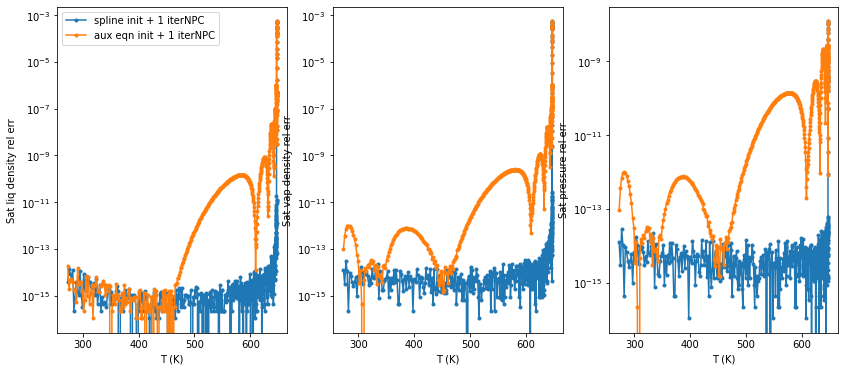

In [7]:
''' Saturation values test, copied '''

# T_samples = iapws95_light.Tc - 1.0 + 0* 0.1e-3 - (iapws95_light.Tc - 0.5e-3 - 260) * np.linspace(0,1,500)**3
# [Ttriple, Tc - 0.1 mK]
T_samples = iapws95_light.Tc - 0.1e-3 - (iapws95_light.Tc - 0.1e-3 - 273.16) * np.linspace(0,1,500)**3
# [Ttriple, Tc - 1 mK]
# T_samples = iapws95_light.Tc - 1e-3 - (iapws95_light.Tc - 1e-3 - 273.16) * np.linspace(0,1,500)**3
# [Ttriple, Tc - 1 K]
# T_samples = iapws95_light.Tc - 1.0 - (iapws95_light.Tc - 1e-3 - 273.16) * np.linspace(0,1,500)**3

# p_sat_lp, rho_satl_lp, rho_satv_lp = np.array(list(zip(*
  # [prho_loc(iapws95_light.Tc/T) for T in T_samples])))
p_sat_lp, rho_satl_lp, rho_satv_lp = np.array(list(zip(*
  [wrapped_prho_cython(iapws95_light.Tc/T) for T in T_samples])))
p_sat_lp2, rho_satl_lp2, rho_satv_lp2 = np.array(list(zip(*
  [prho_loc(iapws95_light.Tc/T,num_iter=1) for T in T_samples])))

# p_sat_new, rho_satl_new, rho_satv_new = np.array(list(zip(*
#   [prho_loc(iapws95_light.Tc/T) for T in T_samples])))
# p_sat_new2, rho_satl_new2, rho_satv_new2 = np.array(list(zip(*
#   [prho_loc2(iapws95_light.Tc/T) for T in T_samples])))
# # High-precision from many Newton iterations
p_sat_hp, rho_satl_hp, rho_satv_hp = np.array(list(zip(*
  [prho_loc_newton(iapws95_light.Tc/T) for T in T_samples])))

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.semilogy(T_samples, np.abs(rho_satl_lp/rho_satl_hp-1.0), '.-')
plt.semilogy(T_samples, np.abs(rho_satl_lp2/rho_satl_hp-1.0), '.-')
# plt.semilogy(T_samples, np.abs(rho_satl_new/rho_satl_hp-1.0), '.-')
# plt.semilogy(T_samples, np.abs(rho_satl_new2/rho_satl_hp-1.0), '.-')
plt.legend(["spline init + 1 iterNPC", "aux eqn init + 1 iterNPC"])
plt.xlabel("T (K)")
plt.ylabel("Sat liq density rel err")
plt.subplot(1,3,2)
plt.semilogy(T_samples, np.abs(rho_satv_lp/rho_satv_hp-1.0), '.-')
plt.semilogy(T_samples, np.abs(rho_satv_lp2/rho_satv_hp-1.0), '.-')
# plt.semilogy(T_samples, np.abs(rho_satv_new/rho_satv_hp-1.0), '.-')
# plt.semilogy(T_samples, np.abs(rho_satv_new2/rho_satv_hp-1.0), '.-')
plt.xlabel("T (K)")
plt.ylabel("Sat vap density rel err")
plt.subplot(1,3,3)
plt.semilogy(T_samples, np.abs(p_sat_lp/p_sat_hp-1.0), '.-')
plt.semilogy(T_samples, np.abs(p_sat_lp2/p_sat_hp-1.0), '.-')
# plt.semilogy(T_samples, np.abs(p_sat_new/p_sat_hp-1.0), '.-')
# plt.semilogy(T_samples, np.abs(p_sat_new2/p_sat_hp-1.0), '.-')
plt.xlabel("T (K)")
plt.ylabel("Sat pressure rel err")

In [8]:
%timeit -n 5000 wrapped_prho_cython(iapws95_light.Tc/400)

25.4 µs ± 7.28 µs per loop (mean ± std. dev. of 7 runs, 5,000 loops each)


In [9]:
# Compute Newton Jacobian near the critical point
d0, d1 = rho_satl_lp[0], rho_satv_lp[0]
_phirall_0 = Namespace(**float_phi_functions.fused_phir_all(rho_satl_lp[0],
  iapws95_light.Tc/T_samples[0]))
_phi0all_0 = Namespace(**float_phi_functions.fused_phi0_all(rho_satl_lp[0],
  iapws95_light.Tc/T_samples[0]))
_phirall_1 = Namespace(**float_phi_functions.fused_phir_all(rho_satv_lp[0],
  iapws95_light.Tc/T_samples[0]))
_phi0all_1 = Namespace(**float_phi_functions.fused_phi0_all(rho_satv_lp[0],
  iapws95_light.Tc/T_samples[0]))

_J00 = -2.0 * _phirall_0.phir_d - d0 * _phirall_0.phir_dd - _phi0all_0.phi0_d
_J01 = 2.0 * _phirall_1.phir_d + d1 * _phirall_1.phir_dd + _phi0all_1.phi0_d
_J10 = 1.0 + 2.0 * d0 * _phirall_0.phir_d + d0 * d0 * _phirall_0.phir_dd
_J11 = -1.0 - 2.0 * d1 * _phirall_1.phir_d - d1 * d1 * _phirall_1.phir_dd

J = np.array([[_J00, _J01], [_J10, _J11]])
# import numpy.linalg
np.linalg.eig(J), np.linalg.cond(J)

((array([-5.09068661e-07,  1.44799467e-09]),
  array([[-0.70698772, -0.67421039],
         [ 0.70722582, -0.73853933]])),
 352.30658970010484)

Temperature: 647.0959
Newton final val: 22063973.269473366
Newton PC final val: 22063973.269475084


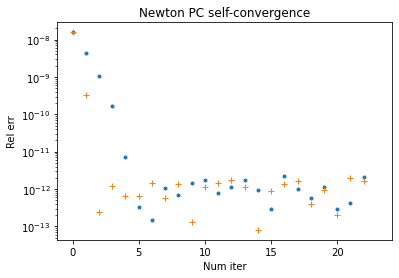

In [10]:
# Near-critical Newton iteration convergence
T_idx = 0

p_newton = [prho_loc_newton(iapws95_light.Tc/T_samples[T_idx], num_iter=i)[0] for i in range(24)]
plt.semilogy(np.arange(24), np.abs(p_newton/p_newton[-1] - 1.0), '.')
plt.title("Newton self-convergence")
plt.xlabel("Num iter")
plt.ylabel("Rel err")

p_loc = [prho_loc(iapws95_light.Tc/T_samples[T_idx], num_iter=i)[0] for i in range(24)]
plt.semilogy(np.arange(24), np.abs(p_loc/p_loc[-1] - 1.0), '+')
plt.title("Newton PC self-convergence")
plt.xlabel("Num iter")
plt.ylabel("Rel err")

print(f"Temperature: {T_samples[T_idx]}")
print(f"Newton final val: {p_newton[-1]}")
print(f"Newton PC final val: {p_loc[-1]}")

In [14]:
# Print sensitivity of p w.r.t. densities for low temperatures
_delta = rho_satl_lp[-1]
_out = float_phi_functions.fused_phir_all(_delta, iapws95_light.Tc/T_samples[-1])
_p = _delta * (1.0 + _delta * _out["phir_d"]) * iapws95_light.rhoc * iapws95_light.R * T_samples[-1]
_sens = (1 + 2*_delta * _out["phir_d"] + _delta*_delta*_out["phir_dd"]) / (1 + _delta * _out["phir_d"])
print("Liquid sensitivity (factor relerror density -> relerror pressure): " +
  f"{_sens}; pressure = {_p}")

_delta = rho_satv_lp[-1]
_out = float_phi_functions.fused_phir_all(_delta, iapws95_light.Tc/T_samples[-1])
_p = _delta * (1.0 + _delta * _out["phir_d"]) * iapws95_light.rhoc * iapws95_light.R * T_samples[-1]
_sens = (1 + 2*_delta * _out["phir_d"] + _delta*_delta*_out["phir_dd"]) / (1 + _delta * _out["phir_d"])
print("Vapour sensitivity (factor relerror density -> relerror pressure): " +
  f"{_sens}; pressure = {_p}")

Liquid sensitivity (factor relerror density -> relerror pressure): 3212275.5376400715; pressure = 611.6547832499457
Vapour sensitivity (factor relerror density -> relerror pressure): 0.9993605537471063; pressure = 611.6547710079051


In [87]:
# Wagner and Pruss auxiliary saturation equation

# dp_sat/dT
pc = 22.064e6
aux_a = np.array([-7.859_517_83,
  1.844_082_59,
  -11.786_649_7,
  22.680_741_1, 
  -15.961_871_9,
  1.801_225_02])
def aux_eq(t):
  # Satured pure phase density auxiliary equations
  satl_powsb = np.array([
      1/3, 2/3, 5/3,
      16/3, 43/3, 110/3])
  satl_coeffsb = np.array([
    1.992_740_64, 1.099_653_42, -0.510_839_303, -1.754_934_79, -45.517_035_2, -6.746_944_50e5])
  # satl_coeffsb = np.array([
    # 1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5])
  satv_powsc = np.array([0.33333333, 0.66666667, 1.33333333, 3.0,
    6.16666667, 11.83333333])
  satv_coeffsc = np.array([-2.031_502_40, -2.683_029_40, -5.386_264_92,
    -17.299_160_5, -44.758_658_1, -63.920_106_3])
  saulwa_satl = 1.0 + np.sum(satl_coeffsb \
    * np.expand_dims(1 - 1.0/t,axis=-1) ** satl_powsb, axis=-1)
  saulwa_satv = np.exp(np.sum(satv_coeffsc * (1 - 1.0/t) ** satv_powsc))
  return saulwa_satl, saulwa_satv
# d0 = saulwa_satl
# d1 = saulwa_satv

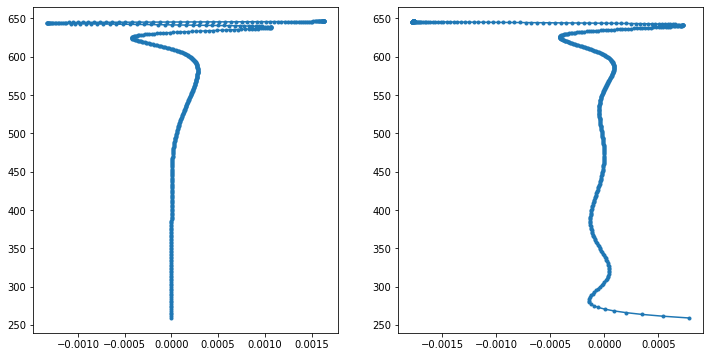

In [90]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
# plt.plot(rho_satl_aux - rho_satl_hp, T_samples ,'.-')
plt.plot(rho_satl_aux / rho_satl_hp - 1.0, T_samples ,'.-')

plt.subplot(1,2,2)
# plt.plot(rho_satv_aux - rho_satv_hp, T_samples, '.-')
plt.plot(rho_satv_aux / rho_satv_hp - 1.0, T_samples, '.-')


## Curve fitting saturation curve

Some attempts to fit curves. For non-spline strategies, might as well just use
Saul & Wagner and avoid the near-critical region. Splines may be a useful
strategy since ``smoothness'' can be regained from the iterative method.

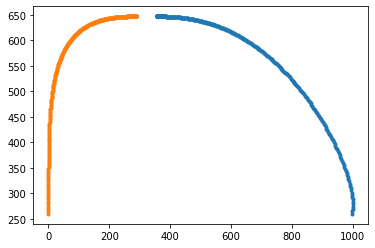

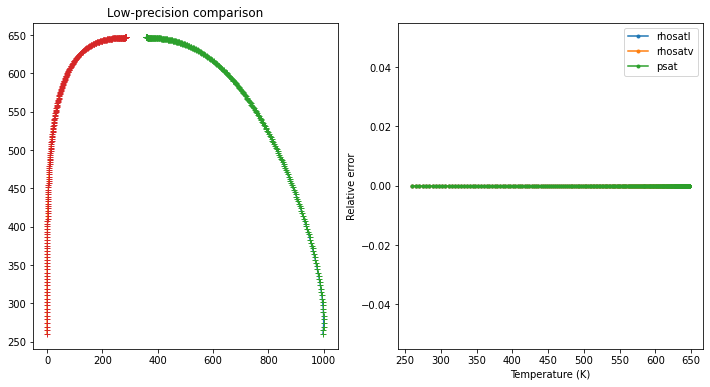

In [43]:
%matplotlib inline
import numpy as np
import iapws95_light
import float_phi_functions
import matplotlib.pyplot as plt
import scipy.optimize

# T_samples = np.linspace(260, iapws95_light.Tc - 0.5e-3, 200)
T_samples = iapws95_light.Tc - 0.5e-3 - (iapws95_light.Tc - 0.5e-3 - 260) * np.linspace(0,1,196)**2
# Largest sampling: <= 32 kB: 455 samples
# (footprint is 32+32+8 bytes (satl, satv, T) per sample); (Zen 3 32kB data L1)
T_samples = 647 - (647 - 260) * np.linspace(0,1,320)**4 

psat, rho_satl, rho_satv = zip(*[[float_phi_functions.prho_sat(T)[key]
    for key in ["psat", "rho_satl", "rho_satv"]] for T in T_samples])

psat_fast, rho_satl_fast, rho_satv_fast = zip(*[[float_phi_functions.prho_sat(T)[key]
    for key in ["psat", "rho_satl", "rho_satv"]] for T in T_samples])

psat_fast, rho_satl_fast, rho_satv_fast = zip(*[[float_phi_functions.prho_sat(T)[key]
    for key in ["psat", "rho_satl", "rho_satv"]] for T in T_samples])

plt.plot(rho_satl, T_samples, '.-')
plt.plot(rho_satv, T_samples, '.-')

# Plot against low-precision routine
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(rho_satl, T_samples, '-')
plt.plot(rho_satv, T_samples, '-')
plt.plot(rho_satl_fast, T_samples, '+')
plt.plot(rho_satv_fast, T_samples, '+')
plt.title("Low-precision comparison")
plt.subplot(1,2,2)
plt.plot(T_samples, rho_satl_fast/np.array(rho_satl)-1.0, '.-')
plt.plot(T_samples, rho_satv_fast/np.array(rho_satv)-1.0, '.-')
plt.plot(T_samples, psat_fast/np.array(psat)-1.0, '.-')
plt.ylabel("Relative error")
plt.xlabel("Temperature (K)")
plt.legend(["rhosatl", "rhosatv", "psat"])

In [40]:
# Target curve for spline fitting
plt.plot(T_samples, rho_satl, '.')
plt.plot(T_samples, rho_satv, '.')


NameError: name 'rho_satl' is not defined

In [44]:
import scipy.interpolate
cs_l = scipy.interpolate.CubicSpline(T_samples[::-1], rho_satl[::-1])
cs_v = scipy.interpolate.CubicSpline(T_samples[::-1], rho_satv[::-1])
coords_flat_l = cs_l.c.T.ravel().copy()
coords_flat_v = cs_v.c.T.ravel().copy()

# Export coordinates
import sys
np.set_printoptions(precision=99, threshold=sys.maxsize)
# (T_samples[::-1].ravel())
# (coords_flat_l)
# (coords_flat_v)

In [ ]:
# Inverse of i -> T: 647 - (647 - 260) * np.linspace(0,1,320)**4

def get_index(T):
  if T > 647.0:
    return 318
  idx = int(319 - (((647.0 - T)/(647.0 - 260.0))**0.25)*319)
  if idx < 0:
    return 0
  return idx

def get_index_iter(x):
  idx = 0
  for i in range(len(cs_l.x) - 1):
    if x >= cs_l.x[i]:
      idx = i
    else:
      break
  return idx

get_index_iter(647.00001), get_index(-2000)


In [45]:
%matplotlib tk
''' Development of spline interpolators for initial guess. '''

def interpolator_l(x):
  # Select index, defaulting to endpoints for extrapolation
  if x >= 647:
    return analytic_start_l(x)
  idx = 0
  for i in range(len(coords_flat_l) - 1):
    if x >= cs_l.x[i]:
      idx = i
    else:
      break
  # Translated coordinate in local monomial basis
  z = x - cs_l.x[idx]
  result = ((coords_flat_l[4*idx] * z + coords_flat_l[4*idx+1]) * z \
    + coords_flat_l[4*idx+2]) * z + coords_flat_l[4*idx+3]
  if result < iapws95_light.rhoc:
    return iapws95_light.rhoc
  return result

def interpolator_v(x):
  # Select index, defaulting to endpoints for extrapolation
  if x >= 647:
    return analytic_start_v(x)
  idx = 0
  for i in range(len(coords_flat_v) - 1):
    if x >= cs_v.x[i]:
      idx = i
    else:
      break
  # Translated coordinate in local monomial basis
  z = x - cs_v.x[idx]
  result = ((coords_flat_v[4*idx] * z + coords_flat_v[4*idx+1]) * z \
    + coords_flat_v[4*idx+2]) * z + coords_flat_v[4*idx+3]
  if result > iapws95_light.rhoc:
    return iapws95_light.rhoc
  return result

def analytic_start_l(x):
  satl_powsb = np.array([
    1/3, 2/3, 5/3,
    16/3, 43/3, 110/3])
  satl_coeffsb = np.array([1.992_740_64, 1.099_653_42, -0.510_839_303,
  -1.754_934_79, -45.517_035_2, -6.746_944_50e5])
  satv_powsc = np.array([1/3, 2/3, 4/3, 3.0,
    37/6, 71/6])
  satv_coeffsc = np.array([-2.031_502_40, -2.683_029_40, -5.386_264_92,
  -17.299_160_5, -44.758_658_1, -63.920_106_3])
  saulwa_satl = 1.0 + np.sum(satl_coeffsb \
    * np.expand_dims(1 - x/iapws95_light.Tc,axis=-1) ** satl_powsb, axis=-1)
  saulwa_satv = np.exp(np.sum(satv_coeffsc * (1 - 1.0/t) ** satv_powsc))
  return saulwa_satl * iapws95_light.rhoc

def analytic_start_v(x):
  satl_powsb = np.array([
    1/3, 2/3, 5/3,
    16/3, 43/3, 110/3])
  satl_coeffsb = np.array([1.992_740_64, 1.099_653_42, -0.510_839_303,
  -1.754_934_79, -45.517_035_2, -6.746_944_50e5])
  satv_powsc = np.array([1/3, 2/3, 4/3, 3.0,
    37/6, 71/6])
  satv_coeffsc = np.array([-2.031_502_40, -2.683_029_40, -5.386_264_92,
  -17.299_160_5, -44.758_658_1, -63.920_106_3])
  saulwa_satl = 1.0 + np.sum(satl_coeffsb \
    * np.expand_dims(1 - x/iapws95_light.Tc,axis=-1) ** satl_powsb, axis=-1)
  saulwa_satv = np.exp(np.sum(satv_coeffsc * (1 - x/iapws95_light.Tc) ** satv_powsc))
  return saulwa_satv * iapws95_light.rhoc


In [ ]:
# Test liquid on test range
T_test = iapws95_light.Tc - 1e-6 - (iapws95_light.Tc - 1e-6 - 260) * np.linspace(0,1,1000)**3
splined_test = np.array([interpolator_l(T) for T in T_test])
ref_test = [float_phi_functions.prho_sat(T)["rho_satl"] for T in T_test]
analytic_test = np.array([analytic_start_l(T) for T in T_test])
plt.figure(figsize=(12,6))
plt.clf()
plt.subplot(1,2,1)
plt.semilogy(T_test, np.abs(splined_test/ref_test - 1), '.-')
plt.semilogy(T_test, np.abs(analytic_test /ref_test - 1), '.-')
plt.subplot(1,2,2)
plt.plot(T_test, splined_test, '.-')
plt.plot(T_test, ref_test, '.-')
plt.title("Liquid")
plt.legend(["spline", "analyticstart"])
# Test vapour on test range
splined_test = np.array([interpolator_v(T) for T in T_test])
ref_test = [float_phi_functions.prho_sat(T)["rho_satv"] for T in T_test]
analytic_test = np.array([analytic_start_v(T) for T in T_test])
plt.figure(figsize=(12,6))
plt.clf()
plt.subplot(1,2,1)
plt.semilogy(T_test, np.abs(splined_test/ref_test - 1), '.-')
plt.semilogy(T_test, np.abs(analytic_test/ref_test - 1), '.-')
plt.subplot(1,2,2)
plt.plot(T_test, splined_test, '.-')
plt.plot(T_test, ref_test, '.-')
plt.title("Vapour")
plt.legend(["spline", "analyticstart"])

Text(0.5, 1.0, 'Vapour')

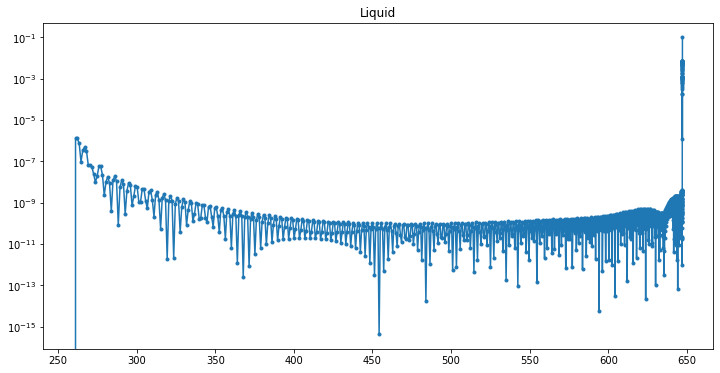

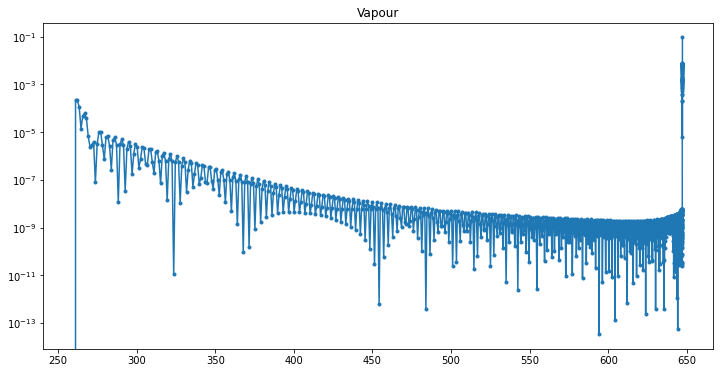

In [9]:
''' Test Cython implementation '''
import iapws95_light
import numpy as np
import float_phi_functions
import matplotlib.pyplot as plt
# Test liquid on test range
T_test = iapws95_light.Tc - 1e-6 - (iapws95_light.Tc - 1e-6 - 260) * np.linspace(0,1,1000)**3
splined_test = np.array([float_phi_functions.satl_spline(T) for T in T_test])
ref_test = [float_phi_functions.prho_sat(T)["rho_satl"] for T in T_test]
plt.figure(figsize=(12,6))
plt.clf()
plt.semilogy(T_test, np.abs(splined_test/ref_test - 1), '.-')
plt.title("Liquid")
# Test vapour on test range
splined_test = np.array([float_phi_functions.satv_spline(T) for T in T_test])
ref_test = [float_phi_functions.prho_sat(T)["rho_satv"] for T in T_test]
plt.figure(figsize=(12,6))
plt.clf()
plt.semilogy(T_test, np.abs(splined_test/ref_test - 1), '.-')
plt.title("Vapour")


In [11]:
float_phi_functions.satv_spline(200), \
  float_phi_functions.satv_spline(-2), \
    float_phi_functions.satv_spline(647), \
      float_phi_functions.satv_spline(647.05), \
      float_phi_functions.satv_spline(647.8), \
      float_phi_functions.satv_spline(1000),

(-0.017943642296587597,
 -2.0388453916865,
 286.98976967733427,
 294.64652704548666,
 0.0,
 0.0)

In [10]:
%timeit -n 5000 float_phi_functions.satl_spline(400)
%timeit -n 5000 float_phi_functions.satv_spline(400)

712 ns ± 195 ns per loop (mean ± std. dev. of 7 runs, 5,000 loops each)
503 ns ± 99.7 ns per loop (mean ± std. dev. of 7 runs, 5,000 loops each)


     fun: 0.8198484265245639
     jac: array([2.62792036e-02, 1.79707408e-02, 7.99557567e-03, 6.09025359e-04,
       5.51342964e-06, 2.23517418e-08, 4.76099998e-02])
 message: 'Optimization terminated successfully'
    nfev: 359
     nit: 41
    njev: 41
  status: 0
 success: True
       x: array([ 2.06655347e+00,  9.62104826e-01, -3.27564634e-01, -2.55287980e+00,
       -9.47890070e+00, -6.75614999e+05, -1.24029487e-02])


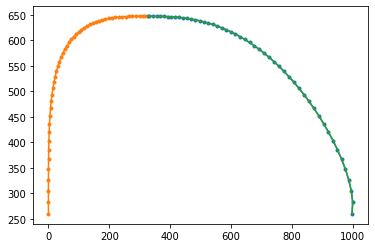

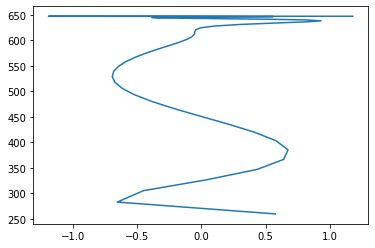

In [157]:
# Scale by input range for monomial terms
scaling = T_samples.max() - T_samples.min()
# Define fitting function
fit_func_incubed = lambda t: np.hstack([
  t,
  t**2,
  t**5,
  t**16,
  t**43,
  t**110,
  t**0.25,
  ])
fit_func = lambda t: fit_func_incubed(t**(1/3))

_name_size = fit_func(0).size

def func_repr(T, a):
  ''' Representation of rho at vector T '''
  # Call form of fitting function with shape manipulation
  return iapws95_light.rhoc * (1 + np.einsum("ij, j -> i",
    fit_func((1 - np.expand_dims(T, axis=1) / iapws95_light.Tc)), a))

def objective(a, y:np.array):
  ord = 8
  ''' Estimate of ||rho_approx - rho||_\infty '''
  return np.linalg.norm(func_repr(T_samples, a)\
    - y, ord=ord) / len(T_samples)**(1.0/ord)

# Set initial parameters
x_init = np.ones((_name_size,))
# x_init[0] = T_samples.mean()
x_init[0:6] = np.array([
  1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5])
# Optimize parameters
opt_obj = scipy.optimize.minimize(lambda a: objective(a, rho_satl),
  x_init, tol=1e-7, method="SLSQP")
# Print optimization result
print(opt_obj)

plt.plot(rho_satl, T_samples, '.-')
plt.plot(rho_satv, T_samples, '.-')
plt.plot(func_repr(T_samples, opt_obj.x), T_samples)
plt.figure()
plt.plot(func_repr(T_samples, opt_obj.x) - rho_satl, T_samples)

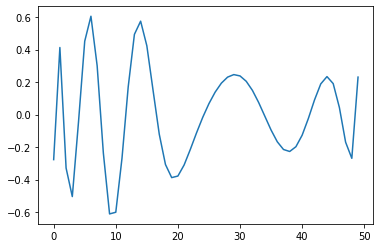

In [154]:
plt.plot(func_repr(T_samples, opt_obj.x) - rho_satl)

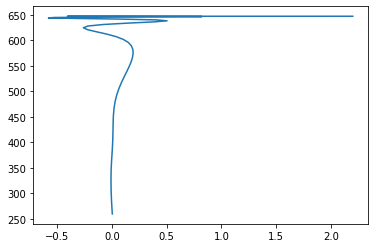

In [4]:
satl_powsb = np.array([
  1/3, 2/3, 5/3,
  16/3, 43/3, 110/3])
satl_coeffsb = np.array([
  1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5])

saulwa_satl = 1.0 + np.sum(satl_coeffsb \
  * np.expand_dims(1 - T_samples/iapws95_light.Tc,axis=-1) ** satl_powsb, axis=-1)
plt.plot(saulwa_satl*iapws95_light.rhoc - rho_satl, T_samples)

## Third d-derivative verification

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light
import numpy as np

# Cython-backend imports
import float_phi_functions
import iapws95_light_perf

In [2]:
d = 838.025 / iapws95_light.rhoc
t = iapws95_light.Tc / 500
# float_phi_functions.fused_phir_d3(d, t), \
#   (float_phi_functions.phir_dd(d+1e-7, t)
#     - float_phi_functions.phir_dd(d-1e-7, t))/2e-7, \
#   float_phi_functions.phir_dd(d, t)

In [3]:
''' Setup error analysis functions'''
_eps = 1e-7
direct = lambda d, t: float_phi_functions.fused_phir_d3(d, t)["phir_ddd"]
approx_eps = lambda d, t, _eps: (float_phi_functions.phir_dd(d+0.5*_eps, t) - float_phi_functions.phir_dd(d-0.5*_eps, t))/_eps
approx = lambda d, t: approx_eps(d, t, _eps)
approx_rerr = lambda d, t: direct(d,t) / approx(d,t) - 1.0
approx_aerr = lambda d, t: direct(d,t) - approx(d,t)

In [4]:
''' Sample num. diff. vs. analytic ddd '''
t_range = np.linspace(1e-6, 2.0, 30)
d_range = np.linspace(1e-6, 2.3, 42)
mg_d, mg_t = np.meshgrid(d_range, t_range)
rerrs = np.array([approx_rerr(d, t) for d, t in zip(mg_d.ravel(), mg_t.ravel())])
aerrs = np.array([approx_aerr(d, t) for d, t in zip(mg_d.ravel(), mg_t.ravel())])

Text(0, 0.5, 't')

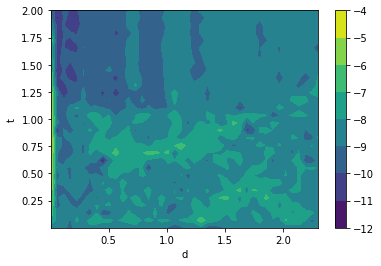

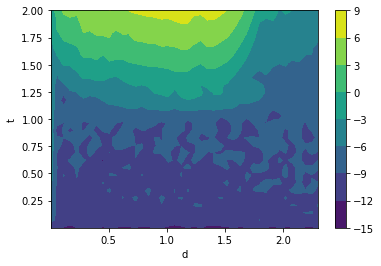

In [5]:
''' Show abs and rel errors '''
plt.figure()
plt.contourf(mg_d, mg_t, np.log10(np.reshape(np.abs(rerrs), mg_d.shape)))
plt.colorbar()
plt.xlabel("d")
plt.ylabel("t")

plt.figure()
plt.contourf(mg_d, mg_t, np.log10(np.reshape(np.abs(aerrs), mg_d.shape)))
plt.colorbar()
plt.xlabel("d")
plt.ylabel("t")

Verify that numerical approximation is in the asymptotic regime with order 2


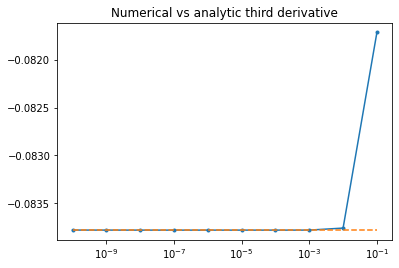

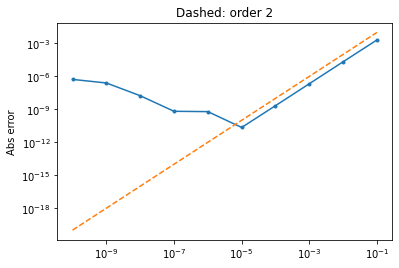

In [6]:
''' Point check of num diff convergence '''
check_val = direct(1.5, 1.01)
_e_vec = np.logspace(-10,-1,10)
plt.figure()
plt.semilogx(_e_vec, [approx_eps(1.5, 1.01, e) for e in _e_vec], '.-')
plt.semilogx(_e_vec, check_val*np.ones_like(_e_vec), '--')
plt.title("Numerical vs analytic third derivative")

plt.figure()
plt.loglog(_e_vec, np.abs(check_val*np.ones_like(_e_vec) 
  - [approx_eps(1.5, 1.01, e) for e in _e_vec]), '.-')
plt.loglog(_e_vec, _e_vec**2, '--')
plt.title("Dashed: order 2")
plt.ylabel("Abs error")
print("Verify that numerical approximation is in the asymptotic regime with order 2")

Verify that numerical approximation is in the asymptotic regime with order 2


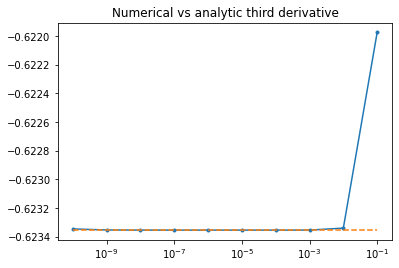

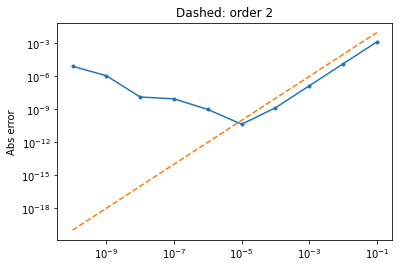

In [7]:
''' Point check of num diff convergence at critical point '''
check_val = direct(1.0, 1.00)
_e_vec = np.logspace(-10,-1,10)
plt.figure()
plt.semilogx(_e_vec, [approx_eps(1.0, 1.00, e) for e in _e_vec], '.-')
plt.semilogx(_e_vec, check_val*np.ones_like(_e_vec), '--')
plt.title("Numerical vs analytic third derivative")

plt.figure()
plt.loglog(_e_vec, np.abs(check_val*np.ones_like(_e_vec) 
  - [approx_eps(1.0, 1.00, e) for e in _e_vec]), '.-')
plt.loglog(_e_vec, _e_vec**2, '--')
plt.title("Dashed: order 2")
plt.ylabel("Abs error")
print("Verify that numerical approximation is in the asymptotic regime with order 2")

In [7]:
''' Verify Delta derivatives '''
def delta_series(d,t):
  d_quad = (d - 1.0)**2
  _c2 = d_quad ** (2.5) # d ** (a - 1)   TODO: use int pow
  _c1 = d_quad ** (2.0 / 3.0)
  _theta = (1.0 - t) + iapws95_light.A_res55_56[0] * _c1 * d_quad
  _Delta = _theta*_theta + iapws95_light.B_res55_56[0] * _c2 * d_quad

  _dDelta = (iapws95_light.A_res55_56[0] * _theta * 2.0 / iapws95_light.beta_res55_56[0] * _c1
    + 2.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * _c2)
  # Compute second derivative of Delta
  _c3 = iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] * _c1
  _ddDelta = _dDelta + (
    4.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * (iapws95_light.a_res55_56[0] - 1.0) * _c2
    + 2.0 * _c3 * _c3 * d_quad
    + 4.0 * _theta * iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] \
      * (iapws95_light._exp1_55_56[0] - 1.0) * _c1
  )
  if d - 1.0 == 0.0:
    _dddDelta = 0.0
  else:
    _dddDelta = (_ddDelta - _dDelta) / (d - 1.0) \
      + (
      4.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * (iapws95_light.a_res55_56[0] - 1.0) \
        * 5.0 *_c2 / (d - 1.0) # unrolled d/dd (d_quad ** (a-1.0))
      + 2.0 * (iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0]) \
        * (iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0]) * _c1 * _c1 * (d - 1.0)\
        * (8.0 / 3.0 + 2.0)
      + 4.0 * (iapws95_light._exp1_55_56[0] - 1.0) * iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] \
        * (
          (iapws95_light.A_res55_56[0] * (10.0 / 3.0) * _c1 * (d - 1.0)) * _c1
          + _theta * (4.0 / 3.0) * (_c1) / (d - 1.0)
        )
    )
  _dDelta *= d - 1.0
  return np.array([_Delta, _dDelta, _ddDelta, _dddDelta])

delta_series(1.5, 1.0)[1:], \
  ((delta_series(1.5+0.5e-7, 1.0) - delta_series(1.5-0.5e-7, 1.0))/1e-7)[:-1]

(array([0.03531416, 0.41481046, 4.04656425]),
 array([0.03531416, 0.41481046, 4.04656425]))

In [63]:
def get_terms(d, t):
  i = 54
  _Delta, _dDelta, _ddDelta, _dddDelta = delta_series(d, t)
  d_quad = (d - 1.0)**2.0
  a = _Delta*_Delta * (-4.0 * iapws95_light.C_res55_56[i-54] * (d-1.0) 
      + d * (2.0*iapws95_light.C_res55_56[i-54]*d_quad - 1.0) * 2.0 * iapws95_light.C_res55_56[i-54])
  b = _Delta * 2.0 * iapws95_light.b_res55_56[i-54] * _dDelta \
      * (1.0 - 2.0 * d * iapws95_light.C_res55_56[i-54] * (d - 1.0))
  c = iapws95_light.b_res55_56[i-54] * (_Delta * _ddDelta
      + (iapws95_light.b_res55_56[i-54] - 1.0) * _dDelta * _dDelta) * d
  return np.array([a,b,c])

In [85]:
def get_common(d, t):
  d_quad = (d - 1.0)**2
  return iapws95_light.n_res[i] * np.exp(-iapws95_light.C_res55_56[i-54] * d_quad \
  - iapws95_light.D_res55_56[i-54]*(t - 1.0)*(t - 1.0))

def get_c3(d, t):
  d_quad = (d - 1.0)**2
  _c2 = d_quad ** (2.5) # d ** (a - 1)   TODO: use int pow
  _c1 = d_quad ** (2.0 / 3.0)
  _theta = (1.0 - t) + iapws95_light.A_res55_56[0] * _c1 * d_quad
  _Delta = _theta*_theta + iapws95_light.B_res55_56[0] * _c2 * d_quad

  _dDelta = (iapws95_light.A_res55_56[0] * _theta * 2.0 / iapws95_light.beta_res55_56[0] * _c1
    + 2.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * _c2)
  # Compute second derivative of Delta
  _c3 = iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] * _c1
  _ddDelta = _dDelta + (
    4.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * (iapws95_light.a_res55_56[0] - 1.0) * _c2
    + 2.0 * _c3 * _c3 * d_quad
    + 4.0 * _theta * iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] \
      * (iapws95_light._exp1_55_56[0] - 1.0) * _c1
  )
  if d - 1.0 == 0.0:
    _dddDelta = 0.0
  else:
    _dddDelta = (_ddDelta - _dDelta) / (d - 1.0) \
      + (
      4.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * (iapws95_light.a_res55_56[0] - 1.0) \
        * 5.0 *_c2 / (d - 1.0) # unrolled d/dd (d_quad ** (a-1.0))
      + 2.0 * (iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0]) \
        * (iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0]) * _c1 * _c1 * (d - 1.0)\
        * (8.0 / 3.0 + 2.0)
      + 4.0 * (iapws95_light._exp1_55_56[0] - 1.0) * iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] \
        * (
          (iapws95_light.A_res55_56[0] * (10.0 / 3.0) * _c1 * (d - 1.0)) * _c1
          + _theta * (4.0 / 3.0) * (_c1) / (d - 1.0)
        )
    )
  _dDelta *= d - 1.0
  i = 54

  print("Check")
  print([_Delta, _dDelta, _ddDelta, _dddDelta])
  print(delta_series(d,t))

  _c3 = _Delta*_Delta * (-4.0 * iapws95_light.C_res55_56[i-54] * (d-1.0) 
    + d * (2.0*iapws95_light.C_res55_56[i-54]*d_quad - 1.0) * 2.0 * iapws95_light.C_res55_56[i-54])
  _c3 += _Delta * 2.0 * iapws95_light.b_res55_56[i-54] * _dDelta \
    * (1.0 - 2.0 * d * iapws95_light.C_res55_56[i-54] * (d - 1.0))
  _c3 += iapws95_light.b_res55_56[i-54] * (_Delta * _ddDelta
    + (iapws95_light.b_res55_56[i-54] - 1.0) * _dDelta * _dDelta) * d
  return _c3

## iapws95_light_perf testing

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light
import numpy as np

# Cython-backend imports
import float_phi_functions
import iapws95_light_perf

In [2]:
# Test critical values
float_phi_functions.fused_phir_all(1,1)

{'phir': -1.128640384149826,
 'phir_d': -0.7705590295466397,
 'phir_dd': 0.5411180590933005,
 'phir_t': -3.054381456439411,
 'phir_tt': -inf,
 'phir_dt': -1.5692827346754505}

In [3]:
iapws95_light_perf.print_verification_values()

Test case 1: rho = 838.025 kg m^{-3}, T = 500 K
Computed (rounded to 9 significant figures): 
phi0    |  2.047977330 | phir    | -3.426932060
phi0_d  |  0.384236747 | phir_d  | -0.364366650
phi0_dd | -0.147637878 | phir_dd |  0.856063701
phi0_t  |  9.046111060 | phir_t  | -5.814034350
phi0_tt | -1.932491850 | phir_tt | -2.234407370
phi0_dt |  0.000000000 | phir_dt | -1.121769150
Reference (9 significant figures): 
phi0    |  2.047977340 | phir    | -3.426932060
phi0_d  |  0.384236747 | phir_d  | -0.364366650
phi0_dd | -0.147637878 | phir_dd |  0.856063701
phi0_t  |  9.046111060 | phir_t  | -5.814034350
phi0_tt | -1.932491850 | phir_tt | -2.234407370
phi0_dt |  0.000000000 | phir_dt | -1.121769150
Max abs difference of phir_fused_all and individual functions: 1.33227e-14.
Max rel difference of phir_fused_all and individual functions: 1.17684e-14.
Max abs difference of phi0_fused_all and individual functions: 0.00000e+00.

Test case 2: rho = 358 kg m^{-3}, T = 647 K
Computed (rounded to 

In [4]:
d = 838.025 / iapws95_light.rhoc
t = iapws95_light.Tc / 500
float_phi_functions.fused_phir_d_phir_dd(d,t), float_phi_functions._fused_phir_d_phir_dd_clean(d,t) #, float_phi_functions.fused_phir_all(d,t)

({'first': -0.3643666503638806, 'second': 0.8560637009746134},
 {'first': -0.3643666503638813, 'second': 0.856063700974612})

In [5]:
d = 358 / iapws95_light.rhoc
t = iapws95_light.Tc / 647
float_phi_functions.fused_phir_d_phir_dd(d,t), float_phi_functions._fused_phir_d_phir_dd_clean(d,t) #, float_phi_functions.fused_phir_all(d,t)

({'first': -0.7140120243712819, 'second': 0.4757306956456898},
 {'first': -0.7140120243712852, 'second': 0.4757306956456887})

In [6]:
''' Built-in timing '''
iapws95_light_perf.print_timing()

Timing iapws95_light_perf calculations for scalar input.
=== Individual routines ===
phi0         : 1.95 us
phi0_d       : 0.79 us
phi0_dd      : 1.09 us
phi0_t       : 1.04 us
phi0_tt      : 0.81 us
phi0_dt      : 1.30 us
phir         : 26.57 us
phir_d       : 32.67 us
phir_dd      : 29.60 us
phir_t       : 32.22 us
phir_tt      : 43.23 us
phir_dt      : 32.77 us
=== Reference ops (pure python) ===
rho * R * T  : 0.86 us
(rho*T)**.5  : 2.26 us
lambda no-op : 0.52 us
=== Optimized routines ===
phir_*       : 7.88 us
phi0_*       : 1.87 us
phir_d_dd    : 4.05 us


In [7]:
''' Local timeit '''
print("Dummy with overhead only")
%timeit -n 10000 float_phi_functions._dummy(d, t)
print("phir_* (clean implementation)")
%timeit -n 10000 float_phi_functions._fused_phir_all_clean(d, t)
print("phir_* (opt implementation)")
%timeit -n 10000 float_phi_functions.fused_phir_all(d, t)
print("phir_d_phir_dd")
%timeit -n 10000 float_phi_functions.fused_phir_d_phir_dd(d, t)
print("phir_d_phir_dd")
%timeit -n 10000 float_phi_functions.fused_phir_d_phir_dd(d, t)
print("phir_* (opt implementation)")
%timeit -n 10000 float_phi_functions.fused_phir_all(d, t)
print("phir_* (clean implementation)")
%timeit -n 10000 float_phi_functions._fused_phir_all_clean(d, t)
print("Dummy with exp / power and overhead")
%timeit -n 10000 float_phi_functions._dummy_struct(d, t)
print("Dummy with overhead only")
%timeit -n 10000 float_phi_functions._dummy(d, t)

Dummy with overhead only
446 ns ± 72.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
phir_* (clean implementation)
6.19 µs ± 589 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
phir_* (opt implementation)
6.73 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
phir_d_phir_dd
5.25 µs ± 856 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
phir_d_phir_dd
6.17 µs ± 950 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
phir_* (opt implementation)
7.15 µs ± 635 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
phir_* (clean implementation)
7.6 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Dummy with exp / power and overhead
2.29 µs ± 530 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Dummy with overhead only
The slowest run took 4.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1.15 µs ± 456 ns per loop (mean ± std. dev. of 7 runs, 10

In [8]:
%timeit -n 20000 float_phi_functions.fused_phir_d3(d, t)
%timeit -n 20000 float_phi_functions.fused_phir_d_phir_dd(d, t)

7.45 µs ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 20,000 loops each)
3.66 µs ± 863 ns per loop (mean ± std. dev. of 7 runs, 20,000 loops each)


In [9]:
''' Estimate % of op loads '''
import timeit
t_measure = timeit.timeit(lambda: float_phi_functions.fused_phir_all(d, t), number=10000)/10000
t_dummy_struct = timeit.timeit(lambda: float_phi_functions._dummy_struct(d, t), number=10000)/10000
t_dummy = timeit.timeit(lambda: float_phi_functions._dummy(d, t), number=10000)/10000
print(f"Estimate of pow/exp functions proportion: {(t_dummy_struct-t_dummy)/t_measure:.5f}")
print(f"Estimate of overhead proportion: {(t_dummy)/t_measure:.5f}")
print(f"Estimate of remaining code: {1 - t_dummy_struct/t_measure:.5f}")

Estimate of pow/exp functions proportion: 0.21940
Estimate of overhead proportion: 0.07293
Estimate of remaining code: 0.70766


In [25]:
print("Saturation curve evaluation, Newton x12")
%timeit -n 1000 float_phi_functions.prho_sat(400)
print("Saturation curve evaluation, Newton-pred-corr")
%timeit -n 10000 float_phi_functions.prho_sat(t)
print("Mixed-phase pressure")
%timeit -n 5000 float_phi_functions.p(400, 400)
print("Mixed-phase energy")
%timeit -n 5000 float_phi_functions.u(400, 400)
print("Pure phase pressure (supercritical)")
%timeit -n 10000 float_phi_functions.p(400, 1000)
print("Pure phase energy (supercritical)")
%timeit -n 10000 float_phi_functions.u(400, 1000)

Saturation curve evaluation, Newton x12
122 µs ± 8.74 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Saturation curve evaluation, Newton-pred-corr
20.3 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Mixed-phase pressure
18.8 µs ± 3.46 µs per loop (mean ± std. dev. of 7 runs, 5,000 loops each)
Mixed-phase energy
31.8 µs ± 4.63 µs per loop (mean ± std. dev. of 7 runs, 5,000 loops each)
Pure phase pressure (supercritical)
6.53 µs ± 1.86 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Pure phase energy (supercritical)
5.95 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
%timeit -n 10000 float_phi_functions.satv_spline(280)
%timeit -n 10000 float_phi_functions.satl_spline(647.04)


437 ns ± 116 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
560 ns ± 56 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [102]:
''' pyXSteam analog timing. '''
import pyXSteam.XSteam as XSteam
# XSteam.SteamTable.rho_pt
psat = float_phi_functions.p(400, 400) / 1e6
xs = XSteam.XSteam()
%timeit -n 5000 xs.rho_pt(psat, 400)
%timeit -n 5000 xs.u_pt(psat, 400)

112 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 5,000 loops each)
204 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 5,000 loops each)


In [9]:
float_phi_functions.rho_sat(273.16), \
  float_phi_functions.p(3.105, 273.16), \
  float_phi_functions.p(1.5076322126641705e-05, 273.16)


({'first': 3.104945714383925, 'second': 1.5076322126641705e-05},
 611.6547710078996,
 1.900642635349912)

Pressure scales up to 100 MPa; contours {0.1, 4, 20, 24, 60, 240, 1000} MPa to compare with M. Chaplin (water.lsbu.ac.uk/water/water_density.html)


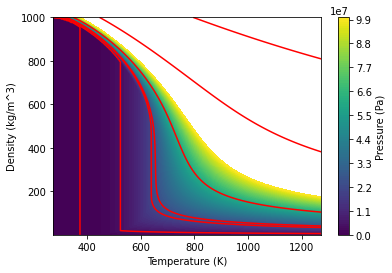

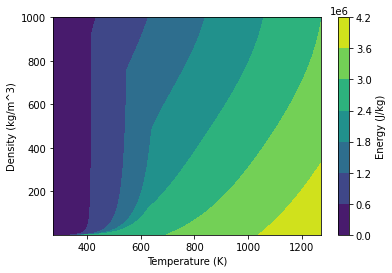

In [5]:
'''Test pressure function p(rho, T) (EOS)'''
rho_range = np.linspace(1, 1000, 256)
T_range = np.linspace(273.16, 1273, 196)
mg_T, mg_rho = np.meshgrid(T_range, rho_range)
mg_p = np.zeros_like(mg_T)
mg_u = np.zeros_like(mg_T)
for i, j in np.ndindex(mg_p.shape):
  mg_p[i,j] = float_phi_functions.p(mg_rho[i,j], mg_T[i,j])
  mg_u[i,j] = float_phi_functions.u(mg_rho[i,j], mg_T[i,j])

plt.contourf(mg_T, mg_rho, mg_p, levels=np.linspace(0, 1e8, 101))
plt.xlabel("Temperature (K)")
plt.ylabel("Density (kg/m^3)")
plt.colorbar(label="Pressure (Pa)")
plt.contour(mg_T, mg_rho, mg_p,
  levels=[0.1e6, 4e6, 20e6, 24e6, 60e6, 240e6, 1000e6], colors="red")

plt.figure()
plt.contourf(mg_T, mg_rho, mg_u)
plt.xlabel("Temperature (K)")
plt.ylabel("Density (kg/m^3)")
plt.colorbar(label="Energy (J/kg)")
print("Pressure scales up to 100 MPa; contours {0.1, 4, 20, 24, 60, 240, 1000} MPa to " +
  "compare with M. Chaplin (water.lsbu.ac.uk/water/water_density.html)")

In [ ]:
'''Test saturation curve computation'''
T_range = np.linspace(273, iapws95_light.Tc-1e-10, 100)
sats = [*map(float_phi_functions.prho_sat_stepinfo, T_range)]
psats, rhol, rhov, steps, res = zip(*sats)
res_norms = np.linalg.norm(np.array(res), axis=-1)
step_norms = np.linalg.norm(np.array(steps), axis=-1)
plt.semilogy(T_range, step_norms, '.-')
plt.semilogy(T_range, res_norms, '.-')
plt.legend(["Step size at n-1", "Residual at n"])
print("Last step size (2-norm) and residual of Maxwell residual (2-norm).")

In [ ]:
''' Compare analytic approx sat curve with Maxwell construction'''
# Saturated liquid density correlation (Eq. 2.3)
_powsb = np.array([1/3, 2/3, 5/3, 16/3, 43/3, 110/3])
_coeffsb = [1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5]
d_satl = lambda t: 1.0 + np.dot((1.0-1.0/t)**_powsb, _coeffsb)
# Saturated vapour density correlation (Eq. 2.2)
_powsc = np.array([1/3, 2/3, 4/3, 9/3, 37/6, 71/6])
_coeffsc = [-2.02957, -2.68781, -5.38107, -17.3151, -44.6384, -64.3486]
d_satv = lambda t: np.exp(np.dot((1.0-1.0/t)**_powsc, _coeffsc))

d_satl_approx = [d_satl(iapws95_light.Tc/T) for T in T_range]
d_satv_approx = [d_satv(iapws95_light.Tc/T) for T in T_range]

plt.plot(T_range, d_satl_approx, '--')
plt.plot(T_range, d_satv_approx, '--')
plt.plot(T_range, np.array(rhol) / iapws95_light.rhoc, '-')
plt.plot(T_range, np.array(rhov) / iapws95_light.rhoc, '-')
plt.title("Approximate and Maxwell saturation curves superimposed")
plt.figure()
plt.plot(T_range, d_satl_approx - np.array(rhol) / iapws95_light.rhoc, '--')
plt.ylabel("Diff d sat l")
plt.xlabel("T (K)")
plt.plot(T_range, d_satv_approx - np.array(rhov) / iapws95_light.rhoc, '--')
plt.ylabel("Diff d sat v")
plt.xlabel("T (K)")
plt.legend(["l", "v"])
plt.grid("both", "both")
plt.title("Difference in approx. and Maxwell saturation curves")

In [ ]:
''' psat - Tsat relationship '''
plt.plot(T_range, psats, '.-')
np.interp(iapws95_light.Tc, T_range, psats)
plt.xlabel("T (K)")
plt.ylabel("p (Pa)")

In [ ]:
# Printed result from iapws95_light.phir_tt(358/iapws95_light.rhoc, iapws95_light.Tc / 647)
z1 = [ 1.04472349e-02, -9.59990338e-01, -0.00000000e+00, -9.82559945e-02,
  6.05860380e-02,  2.51821854e-03,  0.00000000e+00, -2.93516306e+00,
  2.24339824e+00, -3.20137805e-03, -0.00000000e+00, -2.09177215e+00,
  8.72348190e-01, -4.03047444e-02,  3.09004634e-05, -3.05878278e-04,
  2.33177538e-03, -1.59981871e-04,  1.20649465e-07,  4.63477954e-06,
 -2.70141809e-10, -0.00000000e+00, -1.46532074e+00,  0.00000000e+00,
  5.72838269e+00, -1.30232914e+01,  2.08958096e+01,  1.33104875e-02,
 -5.85067353e-01, -2.97246153e+01,  2.12596432e+01,  3.38107678e-01,
 -6.74201148e+00,  7.79491623e-01,  0.00000000e+00, -4.38150357e-02,
  1.74736971e-01, -1.84592355e-01, -6.99666394e-02,  5.02206633e-02,
  9.58976961e-03, -9.51939245e-04,  3.64725467e+00,  6.26876729e+00,
 -1.50680115e+01,  4.89703207e+00, -5.40449307e-03, -2.85779055e-07,
 -1.08272029e+02,  1.89163001e+02, -8.34766580e+01, -1.66045467e+02,
  1.73093312e+02, -7.25941498e+00, -2.41084874e+00,  1.03600001e+00]
# Printed result from float_phi_functions.phir_tt(358/iapws95_light.rhoc, iapws95_light.Tc / 647)
z2 = [0.010447234835687661,
-0.9599903378384489,
-0.0,
-0.09825599433064153,
0.06058603807019969,
0.002518218544455502,
0.0,
-2.9351630561897437,
2.2433982442597364,
-0.0032013780447161786,
-0.0,
-2.091772145304223,
0.8723481903219628,
-0.04030474442317951,
3.090046336548172e-05,
-0.00030587827833254054,
0.0023317753858539164,
-0.00015998187100786356,
1.2064946503208344e-07,
4.6347795344888724e-06,
-2.7014180992736895e-10,
-0.0,
-1.4653207357712412,
0.0,
5.728382693436505,
-13.023291416324133,
20.89580962315094,
0.01331048750233531,
-0.5850673524083665,
-29.72461529211912,
21.259643161313537,
0.33810767772846967,
-6.742011470366356,
0.779491623310715,
0.0,
-0.04381503569465125,
0.17473697085933748,
-0.1845923551479196,
-0.06996663956715105,
0.05022066332634169,
0.00958976959560878,
-0.0009519392430030964,
3.647254669574024,
6.268767295120435,
-15.068011521512293,
4.897032062462177,
-0.005404493072474181,
-2.857790548589655e-07,
-108.27202963056544,
189.16300090570866,
-83.4766578353496,
-166.04546660332667,
173.09331149199872,
-7.259414970645418,
-2.410848753029746,
1.0360000148277766]

# Difference vector
import numpy as np 
import matplotlib.pyplot as plt
z1 = np.array(z1)
z2 = np.array(z2)
z1 - z2
plt.plot(z1-z2, '.')
plt.xlabel("Index")
plt.ylabel("Term diff")

plt.figure()
plt.semilogy(np.abs(z1-z2), '.')
plt.xlabel("Index")
plt.ylabel("Term diff")

plt.figure()
plt.semilogy(np.abs(1.0-z2/z1), '.')
plt.xlabel("Index")
plt.ylabel("Relative term diff")

print("Numerical noise (difference) between py and Cython implementations")

In [ ]:
import iapws95_light_perf
iapws95_light_perf.print_timing()

In [ ]:
import iapws95_light_perf
iapws95_light_perf.print_verification_values()

## Timing for mixtureWLM

In [13]:
import line_profiler
import mixtureWLM
import matplotlib.pyplot as plt
import numpy as np

# f = mixtureWLM._itersolve_d
f = mixtureWLM.solve_rhow
profile = line_profiler.LineProfiler(f)
profile.runcall(f, 2000, 0.5, 350)
profile.print_stats()

Timer unit: 1e-07 s

Total time: 0.0004481 s
File: c:\Users\fredr\Documents\iapws95_light\mixtureWLM.py
Function: solve_rhow at line 119

Line #      Hits         Time  Per Hit   % Time  Line Contents
   119                                           def solve_rhow(rho_mix:float, yw:float, T:float) -> float:
   120                                             ''' Solve for water density. '''
   121         1         27.0     27.0      0.6    d_init = 1.0
   122         1         75.0     75.0      1.7    if T < iapws95_light.Tc:
   123                                               # Compute saturation properties
   124         1        799.0    799.0     17.8      sat_info = backend.prho_sat(T)
   125         1         15.0     15.0      0.3      psat, rhol, rhov = \
   126         1         69.0     69.0      1.5        float(sat_info["psat"]), sat_info["rho_satl"], sat_info["rho_satv"]
   127                                               # Compute dependent variables
   128         1  

In [14]:
%timeit f(2000, 0.5, 350)

104 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


With a mapping from (rho_mix, T, yw) -> rho_w, one can then compute pressure from p(rho_w, T) or from pressure of the linearized magma given v_m = v - yw * v_w. Note the weak dependence on T (outer iteration loop).


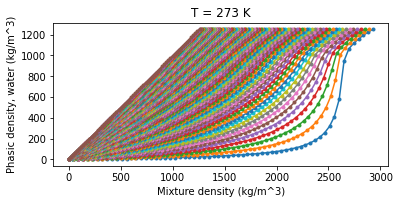

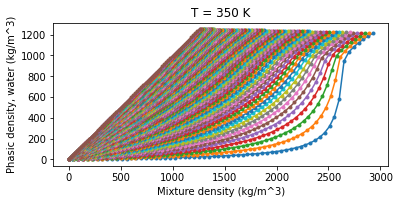

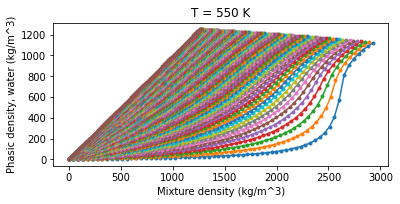

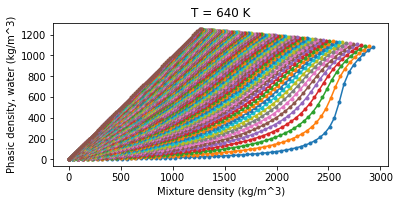

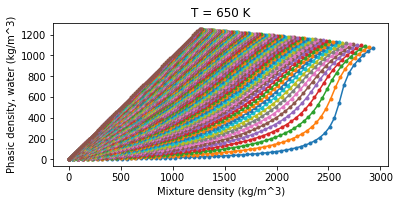

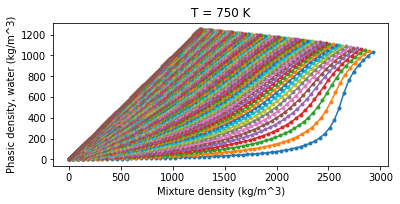

In [15]:
''' Show (rho_mix, T, yw) -> rho_w calculations '''
print("With a mapping from (rho_mix, T, yw) -> rho_w, one can then compute " +
  "pressure from p(rho_w, T) or from pressure of the linearized magma given " +
  "v_m = v - yw * v_w. Note the weak dependence on T (outer iteration loop).")
for i, T in enumerate([273, 350, 550, 640, 650, 750]):
  plt.figure()
  vec_out_d = np.array([*map(lambda rho_mix, yw: mixtureWLM.solve_rhow(rho_mix, yw, T),
    mixtureWLM.mg_rho_mix.ravel(), mixtureWLM.mg_yw.ravel())])

  # Load vector data in ndarray
  mg_out_d = np.zeros_like(mixtureWLM.mg_yw)
  mg_out_steps = np.zeros_like(mixtureWLM.mg_yw)
  mg_out_d.ravel()[:] = vec_out_d.ravel()

  # Plot
  for i in range(mg_out_d.shape[0]):
    plt.plot(mixtureWLM.mg_rho_mix[i,:], mg_out_d[i,:].ravel(), '.-')
  xl = plt.xlabel("Mixture density (kg/m^3)")
  yl = plt.ylabel("Phasic density, water (kg/m^3)")
  plt.title(f"T = {T} K")
  plt.gca().set_aspect("equal")

## Testing: Cython WLMA iteration test

In [249]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light

# Cython-backend imports
import float_phi_functions
import float_mix_functions
import iapws95_light_perf
import mixtureWLMA
from time import perf_counter
import scipy.optimize

wlma = mixtureWLMA.WLMA()
K = wlma.K
p_m0 = wlma.p_m0
rho_m0 = wlma.rho_m0
v_m0 = 1.0 / rho_m0
c_v_m0 = wlma.c_v_m0
R_a = wlma.R_a
gamma_a = wlma.gamma_a

ya = 0.01

def prim_to_cons(yw, T, rhow, ya):
# Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return (np.nan, np.nan, np.nan)
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rhoa = p_target / (R_a * T)
  rho_mix = 1.0/(yw / rhow + (1 - yw - ya) / rhom + ya / rhoa)
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  ua_target = R_a / (gamma_a - 1.0) * T
  u_target = yw*uw_target + (1-yw-ya)*um_target + ya*ua_target
  vol_energy = rho_mix * u_target
  return (vol_energy, rho_mix, p_target)

vec_yw = np.linspace(0.01, 0.9999, 8) # 125
vec_T = np.linspace(280, 1500, 12) # 130
vec_rhow = np.linspace(0.5, 1050, 14) # 60

mg_yw, mg_T, mg_rhow = np.meshgrid(vec_yw, vec_T, vec_rhow, indexing="ij")

mg_p_target = np.empty_like(mg_yw)
mg_vol_energy = np.empty_like(mg_yw)
mg_rho_mix = np.empty_like(mg_yw)

mg_p_calc = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)


# Iteratively load complete conservative state
for i, j, k in np.ndindex(mg_yw.shape):
  mg_vol_energy[i,j,k], mg_rho_mix[i,j,k], mg_p_target[i,j,k] = \
    prim_to_cons(mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k], ya)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
# Spot check
i,j,k = 4, 2, 5
vol_energy, rho_mix, yw = mg_vol_energy[i,j,k], mg_rho_mix[i,j,k], mg_yw[i,j,k]

kern = lambda d, T, pr, Tr: float_mix_functions.kernel4_WLMA(d, T, pr, Tr,
  vol_energy, rho_mix, yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

In [254]:
# Test analytical Jacobian for 4-system
U0 = np.array([1, 400, 1e5, 300])
f0 = kern(*U0)[0]
dx = 1e-7
J_numdiff = np.vstack((
  (kern(*(U0+[dx, 0, 0, 0]))[0] - kern(*(U0-[dx, 0, 0, 0]))[0]) / (2 * dx),
  (kern(*(U0+[0, dx, 0, 0]))[0] - kern(*(U0-[0, dx, 0, 0]))[0]) / (2 * dx),
  (kern(*(U0+[0, 0, dx, 0]))[0] - kern(*(U0-[0, 0, dx, 0]))[0]) / (2 * dx),
  (kern(*(U0+[0, 0, 0, dx]))[0] - kern(*(U0-[0, 0, 0, dx]))[0]) / (2 * dx),
)).T

J_numdiff, kern(*U0)[1]*kern(*U0)[2]

(array([[-4.06529199e-03,  2.09664508e-03, -5.55111512e-10,
          1.03466180e-03],
        [-8.46713246e-01,  0.00000000e+00, -4.07807121e-05,
          1.35928424e-02],
        [ 0.00000000e+00,  7.48361737e+03, -1.00000761e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000022e+00,  0.00000000e+00,
         -1.00000022e+00]]),
 array([[-4.06529238e-03,  2.09665092e-03,  1.32017041e-15,
          1.03466202e-03],
        [-8.46713243e-01,  0.00000000e+00, -4.07785293e-05,
          1.35928406e-02],
        [ 0.00000000e+00,  7.48362076e+03, -1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         -1.00000000e+00]]))

In [429]:
''' Initial guess production '''

# Water reference state
T_w_ref = 300.0
rho_w_ref = 997.0
v_w_ref = 1.0 / rho_w_ref
# Compute dependent variables
c_v_w   = float_mix_functions.c_v(rho_w_ref, T_w_ref)
e_w_ref = float_mix_functions.u(rho_w_ref, T_w_ref)
p_ref   = float_mix_functions.p(rho_w_ref, T_w_ref)
v_a_ref = R_a * T_w_ref / p_ref
v_m_ref = 1.0 / rho_m0
d_ref   = rho_w_ref / mixtureWLMA.rhoc
_out_pair = float_mix_functions.fused_phir_d_phir_dd(d_ref, mixtureWLMA.Tc / T_w_ref)
_phir_d, _phir_dd = _out_pair["first"], _out_pair["second"]
# Derivative of Z*d == p/(rhoc*R*T): nondimensional pressure
dpndd = (1 + 2*d_ref*_phir_d + d_ref*d_ref*_phir_dd)
dvdp_w = -1.0 / (rho_w_ref * rho_w_ref * mixtureWLMA.R * T_w_ref \
    * (1 + 2*d_ref*_phir_d + d_ref*d_ref*_phir_dd))
dvdp_a = -R_a * T_w_ref / (p_ref*p_ref)
dvdp_m = -rho_m0 / K * v_m_ref * v_m_ref
dvdT_w =
dvdT_a = R_a * T_ref / p
ym    = 1.0 - yw - ya
c_v_a = R_a / (gamma_a - 1.0)

# Compute temperature with e(T) approximate model
T = ((vol_energy / rho_mix) - yw * (e_w_ref - c_v_w * T_w_ref)) \
    / (yw * c_v_w + ym * c_v_m0 + ya * c_v_a)
# Compute pressure with v(p, T) approximate model
dvdp = yw*dvdp_w + ya*dvdp_a + ym*dvdp_m
p = p_ref + (1.0 / rho_mix - (yw*v_w_ref + ya*v_a_ref + ym*v_m_ref)) / dvdp
dvdT = yw*dvdT_w + ya*dvdT_a


# Coordinate clipping
U_min = np.array([1e-5, 273.16, 7e3, 173.16]) # Permit density down to 7 kPa (d = 0.01)
U_max = np.array([3.882, 2200.0, 1e9, 2200.0]) #Permit density up to 1 GPa

In [444]:
rhoc = mixtureWLMA.rhoc

In [445]:
996/rhoc

3.093167701863354

In [442]:
p_L, p_V, p_S
U0_L[0]*mixtureWLMA.rhoc, U0_L[1]
float_mix_functions.p(996, U0_L[1])

3536.8067522741653

In [464]:
i,j,k,l

(15, 23, 15, 23)

In [487]:
p_target_curr = mg_p_target[1,2,8,14]
vol_energy = mg_vol_energy[1,2,8,14]
rho_mix = mg_rho_mix[1,2,8,14]
yw = mg_yw[1,2,8,14]
ya = mg_ya[1,2,8,14]
kern = lambda d, T, pr, Tr: float_mix_functions.kernel4_WLMA(d, T, pr, Tr,
    vol_energy, rho_mix, yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

In [500]:
''' Multiseeding '''
# Subcrit L
U0_L = np.array([3.093167701863354, 300, 100e6, 300]) #273.16])
p_L = float_mix_functions.p(U0_L[0]*mixtureWLMA.rhoc, U0_L[1])
U0_L[2] = p_L
U0_L = iterate_backtrack_box(U0_L)[0]
# Subcrit V
U0_V = np.array([5e-5, 300, 100e6, 300])
p_V = float_mix_functions.p(U0_V[0]*mixtureWLMA.rhoc, U0_V[1])
U0_V[2] = p_V
U0_V = iterate_backtrack_box(U0_V)[0]
# Subcrit LV
U0_LV = np.array([560.2333333333333/rhoc, 380, 100e6, 300])
p_LV = float_mix_functions.p(U0_LV[0]*mixtureWLMA.rhoc, U0_LV[1])
U0_LV[2] = p_LV
# U0_LV = iterate_backtrack_box(U0_LV)[0]
# Supercrit
U0_S = np.array([1, 660, 100e6, 660])
p_S = float_mix_functions.p(U0_S[0]*mixtureWLMA.rhoc, U0_S[1])
U0_S[2] = p_S
U0_S = iterate_backtrack_box(U0_S)[0]

# iterate_backtrack_box(U0_L), iterate_backtrack_box(U0_V), iterate_backtrack_box(U0_S) # U_next, f_along_line

# Fitness evaluation
obj = lambda F: F[0]*F[0] + F[1]*F[1]
obj(kern(*U0_L)[0]), obj(kern(*U0_V)[0]), obj(kern(*U0_LV)[0]), obj(kern(*U0_S)[0])

(5121.435971213367, 442.96535461069936, 0.04725422562038268, 4174.877352303293)

In [501]:
kern(*U0_LV)[0]

array([-2.12344876e-01, -4.65175167e-02,  0.00000000e+00,  8.00000000e+01])

In [604]:
_d_range, _T_range = np.linspace(1e-5, 3.0, 610), np.linspace(273.16, 773.16, 180)
_mg_d, _mg_T = np.meshgrid(_d_range, _T_range)
_mg_f = np.zeros((*_mg_d.shape, 4))
_mg_dir = np.zeros((*_mg_d.shape, 4))
_mg_enthalpy = np.zeros(_mg_d.shape)

for i, j in np.ndindex(_mg_d.shape):
  _p = float_mix_functions.p(_mg_d[i,j] * rhoc, _mg_T[i,j])
  _U = np.array([_mg_d[i,j], _mg_T[i,j], _p, _mg_T[i,j]])
  _out = kern(*_U)
  _f = _out[0]
  _mg_f[i,j,:] = _f
  _mg_dir[i,j,:] = -np.linalg.solve(_out[1] * _out[2], _out[0])
  _rhom = rho_m0 * (1 + (_p - p_m0) / K)
  _mg_enthalpy[i,j] = ya * gamma_a * R_a / (gamma_a - 1.0) * _mg_T[i,j] \
    + (1 - ya - yw) * (c_v_m0 * _mg_T[i,j] 
      + float_mix_functions.magma_mech_energy(_p, K, p_m0, rho_m0) + _p / _rhom) \
    + yw * (float_mix_functions.u(_mg_d[i,j] * rhoc, _mg_T[i,j]) + _p / (_mg_d[i,j] * rhoc))
  # _f /= [1.0, 300, 5e6, 300]
  # _mg_fnorm[i,j] = np.linalg.norm(_f)


In [543]:
# Params
rho_mix, vol_energy, yw, ya

(2.3511575225853956,
 1344503.2752482644,
 0.07599333333333333,
 0.6065217391304348)

In [529]:
# Lower bound on rhow
yw * rho_mix

0.17867229733300616

In [608]:
''' Grab solution '''
p_target_curr = mg_p_target[1,2,8,14]
vol_energy = mg_vol_energy[1,2,8,14]
rho_mix = mg_rho_mix[1,2,8,14]
yw = mg_yw[1,2,8,14]
ya = mg_ya[1,2,8,14]

U_soln = np.array([
  mg_rhow[1,2,8,14]/rhoc, mg_T[1,2,8,14], mg_p_target[1,2,8,14], mg_T[1,2,8,14]
])
kern_soln = kern(*U_soln)
d_soln = mg_rhow[1,2,8,14]/rhoc
T_soln = mg_T[1,2,8,14]
print(f"d = {d_soln}, T = {T_soln}")


_rhom = rho_m0 * (1 + (p_target_curr - p_m0) / K)
h_soln = ya * gamma_a * R_a / (gamma_a - 1.0) * T_soln \
  + (1 - ya - yw) * (c_v_m0 * T_soln 
    + float_mix_functions.magma_mech_energy(p_target_curr, K, p_m0, rho_m0) + p_target_curr / _rhom) \
  + yw * (float_mix_functions.u(d_soln * rhoc, T_soln) + p_target_curr / (d_soln * rhoc))

d = 1.7398550724637682, T = 386.0869565217391


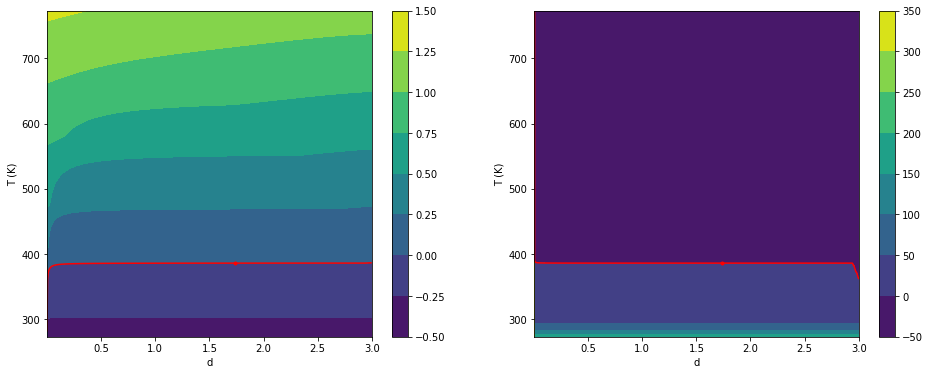

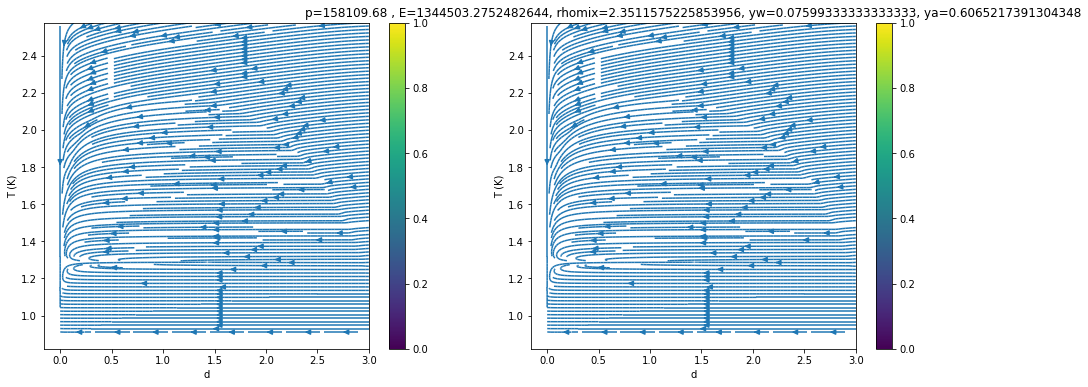

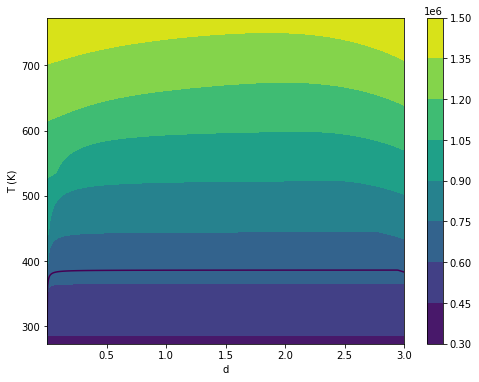

In [609]:
%matplotlib inline
plt.figure(figsize=(16,6))

for i in range(2):
  plt.subplot(1,2,i+1)
  plt.contourf(_mg_d, _mg_T, _mg_f[...,i])
  plt.colorbar()
  plt.xlabel("d")
  plt.ylabel("T (K)")
  plt.contour(_mg_d, _mg_T, _mg_f[...,i], levels=[0], colors=["red"])
  plt.plot(d_soln, T_soln, 'r.')

plt.figure(figsize=(16,6))

for i in range(2):
  plt.subplot(1,2,i+1)
  plt.streamplot(_mg_d, _mg_T/300, _mg_dir[...,0], _mg_dir[...,1]/300, density=3.0)
  # plt.quiver(_mg_d, _mg_T/300, _mg_dir[...,0], _mg_dir[...,1]/300, scale=20.0)
  plt.xlabel("d")
  plt.ylabel("T (K)")
  plt.colorbar()
  # plt.xlim((1.0, 2.0))
  # plt.ylim((350,450))

plt.title(f"p={p_target_curr:.2f} , E={vol_energy}, rhomix={rho_mix}, yw={yw}, ya={ya}")

plt.figure(figsize=(8,6))

plt.contourf(_mg_d, _mg_T, _mg_enthalpy)
plt.xlabel("d")
plt.ylabel("T (K)")
plt.colorbar()
plt.contour(_mg_d, _mg_T, _mg_enthalpy, levels=[h_soln])

  # plt.xlim((1.0, 2.0))
  # plt.ylim((350,450))

# plt.title(f"p={p_target_curr:.2f} , E={vol_energy}, rhomix={rho_mix}, yw={yw}, ya={ya}")

In [595]:
# Basin near solution

_d_range = np.linspace(d_soln-1e-2, d_soln+1e-2, 210)
_T_range = np.linspace(T_soln-.5, T_soln+.5, 180)
_mg_d, _mg_T = np.meshgrid(_d_range, _T_range)
_mg_f = np.zeros((*_mg_d.shape, 4))
_mg_dir = np.zeros((*_mg_d.shape, 4))

for i, j in np.ndindex(_mg_d.shape):
  _p = float_mix_functions.p(_mg_d[i,j] * rhoc, _mg_T[i,j])
  _U = np.array([_mg_d[i,j], _mg_T[i,j], _p, _mg_T[i,j]])
  _out = kern(*_U)
  _f = _out[0]
  _mg_f[i,j,:] = _f
  _mg_dir[i,j,:] = -np.linalg.solve(_out[1] * _out[2], _out[0])
  # _f /= [1.0, 300, 5e6, 300]
  # _mg_fnorm[i,j] = np.linalg.norm(_f)


In [599]:
kern_soln

(array([0., 0., 0., 0.]),
 array([[1.32890935e-07, 1.32890935e-07, 1.61582740e-06, 1.61582740e-06],
        [1.78672297e-01, 1.00000000e+00, 2.17248523e+00, 2.17248523e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]]),
 array([[-1.90512330e+03,  4.26893782e+03,  2.09148031e-09,
          1.50175770e+03],
        [-1.02593059e-03,  0.00000000e+00, -2.90952022e-06,
          1.19150181e-03],
        [ 0.00000000e+00,  5.21924034e+03, -1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         -1.00000000e+00]]),
 {'x': 0.0006629292038056005,
  'ew': 475040.9361768619,
  'v': 0.0017849705479859581,
  'ul': 473683.7027595923,
  'uv': 2521011.5463337414,
  'vl': 0.0010540848942808786,
  'vv': 1.1035634471449849,
  'dewdT': 4268.937823401057,
  'dpsatdT': 5219.240335423405,
  'partial_dxdT': 1.9712381232973047e-05,
  'partial_dxdv': 0.9

Text(0.5, 1.0, 'p=158109.68 , E=1344503.2752482644, rhomix=2.3511575225853956, yw=0.07599333333333333, ya=0.6065217391304348')

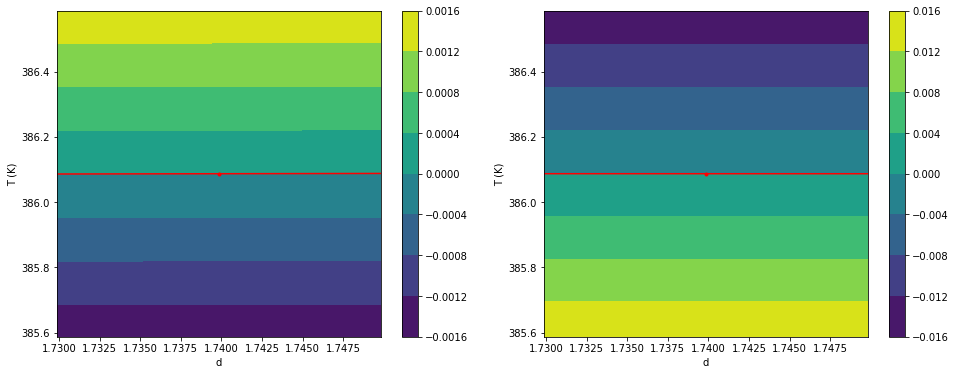

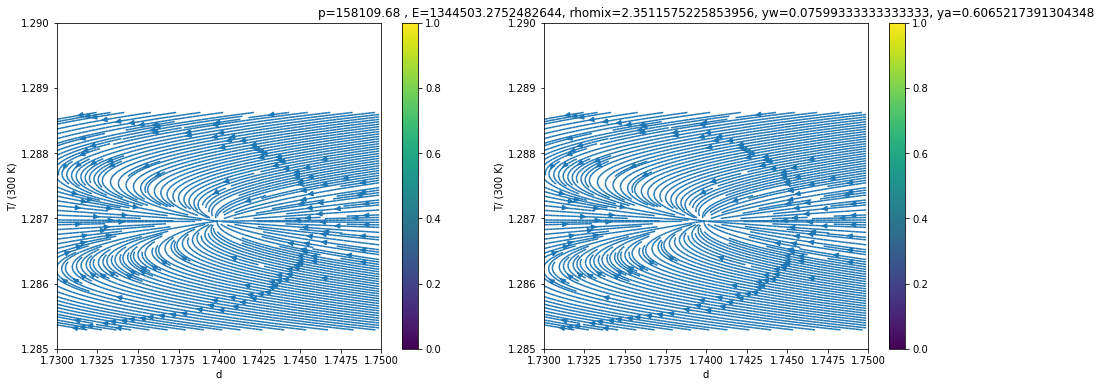

In [598]:
%matplotlib inline
plt.figure(figsize=(16,6))

for i in range(2):
  plt.subplot(1,2,i+1)
  plt.contourf(_mg_d, _mg_T, _mg_f[...,i])
  plt.colorbar()
  plt.xlabel("d")
  plt.ylabel("T (K)")
  plt.contour(_mg_d, _mg_T, _mg_f[...,i], levels=[0], colors=["red"])
  plt.plot(d_soln, T_soln, 'r.')

plt.figure(figsize=(16,6))

for i in range(2):
  plt.subplot(1,2,i+1)
  plt.streamplot(_mg_d, _mg_T/300, _mg_dir[...,0], _mg_dir[...,1]/300, density=3.0)
  # plt.quiver(_mg_d, _mg_T/300, _mg_dir[...,0], _mg_dir[...,1]/300, scale=20.0)
  plt.xlabel("d")
  plt.ylabel("T/ (300 K)")
  plt.colorbar()
  plt.xlim((1.73, 1.75))
  plt.ylim((1.285, 1.290))

plt.title(f"p={p_target_curr:.2f} , E={vol_energy}, rhomix={rho_mix}, yw={yw}, ya={ya}")


In [601]:
yw / (rhoc / rho_mix)

0.0005548829109720688

In [489]:
U = U0_L
for _k in range(256):
  U, f = iterate_backtrack_box(U)
  fnorm = np.linalg.norm(f)
  if fnorm < 1e-12:
    break
  if np.any(np.isnan(f)):
    fnorm = 1e10
    break
print(f"L: U={U}")
print(f"L: fnorm={fnorm}")

U = U0_V
for _k in range(256):
  U, f = iterate_backtrack_box(U)
  fnorm = np.linalg.norm(f)
  if fnorm < 1e-12:
    break
  if np.any(np.isnan(f)):
    fnorm = 1e10
    break
print(f"V: U={U}")
print(f"V: fnorm={fnorm}")

U = U0_LV
for _k in range(256):
  U, f = iterate_backtrack_box(U)
  fnorm = np.linalg.norm(f)
  if fnorm < 1e-12:
    break
  if np.any(np.isnan(f)):
    fnorm = 1e10
    break
print(f"LV:U={U}")
print(f"LV:fnorm={fnorm}")

U = U0_S
for _k in range(256):
  U, f = iterate_backtrack_box(U)
  fnorm = np.linalg.norm(f)
  if fnorm < 1e-12:
    break
  if np.any(np.isnan(f)):
    fnorm = 1e10
    break
print(f"S: U={U}")
print(f"S: fnorm={fnorm}")

L: U=[9.95724010e-04 3.36053292e+02 2.26825096e+04 3.36053292e+02]
L: fnorm=102.29335961290425
V: U=[1.11331699e-03 3.31665253e+02 1.86018547e+04 3.31665253e+02]
V: fnorm=15.065917835301677
LV:U=[1.73985507e+00 3.86086957e+02 1.58109679e+05 3.86086957e+02]
LV:fnorm=0.0
S: U=[2.59010824e-03 3.52376204e+02 4.56490423e+04 3.52376204e+02]
S: fnorm=299.2613323581747


In [474]:
p_target_curr

158109.6793646239

In [637]:
def iterate(U):
  _out = kern(*U)
  return U - 1e-2 * np.linalg.solve(_out[1] * _out[2], _out[0]), \
    _out[0]

def iterate_log(V):
  _U = np.exp(V)
  _out = kern(*_U)
  return V - np.linalg.solve(_out[1] * _out[2], _out[0]) / _U, \
    _out[0]

def iterate_log_backtrack(V):
  _U = np.exp(V)
  _out = kern(*_U)
  step = - np.linalg.solve(_out[1] * _out[2], _out[0]) / _U
  f = _out[0]
  step, f

  # Greed ratio in (0,1) for Armijo conditions
  greed_ratio = 0.1
  # Step reduction factor in (0, 1) used each iteraiton
  step_reduction_factor = 0.9
  # Set the step size factor (==1.0 the first time Armijo condition is checked)
  a = 1.0 / step_reduction_factor
  for i in range(6):
    a *= step_reduction_factor
    f_along_line = kern(*np.exp(V + a * step))[0]
    if np.any(np.isnan(f_along_line)):
      a *= step_reduction_factor
      continue
    # c * grad(norm(f)) dot J^{-1} f = c || f ||, since Newton sends model to 0
    tt = greed_ratio * np.linalg.norm(f)
    # LHS of Armijo condition: improvement is at least a portion of a * |f|
    armijoLHS = np.linalg.norm(f) - np.linalg.norm(f_along_line) - a * tt
    if armijoLHS >= 0:
      break  
  return V + a * step, f_along_line

def iterate_backtrack_box(U):
  ''' Backtracked Newton with box bounds '''
  _out = kern(*U)
  step = - np.linalg.solve(_out[1] * _out[2], _out[0])

  ''' Box bound scaling '''
  U_min = np.array([1e-5, 273.16, 7e3, 173.16]) # Permit density down to 7 kPa (d = 0.01)
  U_max = np.array([3.882, 2200.0, 1e9, 2200.0]) #Permit density up to 1 GPa

  use_type = "projection"
  if use_type == "scaling": # ''' Type A: Scaling '''
    step_size_factor = 1.0
    for i in range(len(U)):
      if U[i] + step[i] < U_min[i]:
        # i-th min bound is active 
        step_size_factor = np.minimum(step_size_factor, (U_min[i] - U[i])/ step[i])
      if U[i] + step[i] > U_max[i]:
        # i-th max bound is active
        step_size_factor = np.minimum(step_size_factor, (U_max[i] - U[i])/ step[i])
    step *= step_size_factor

  # Greed ratio in (0,1) for Armijo conditions
  greed_ratio = 0.9
  # Step reduction factor in (0, 1) used each iteration
  step_reduction_factor = 0.7
  # Set the step size factor (==1.0 the first time Armijo condition is checked)
  a = 1.0 / step_reduction_factor
  # Backtracking
  for i in range(24):
    a *= step_reduction_factor

    U_next = U + a * step
    box_active = False
    if use_type == "projection": # ''' Type B: Projection '''
      for i in range(len(U)):
        if U_next[i] < U_min[i]:
          # i-th min bound is active
          U_next[i] = U_min[i] 
          box_active = True
        if U_next[i] > U_max[i]:
          # i-th max bound is active
          U_next[i] = U_max[i]
          box_active = True
    f_along_line = kern(*U_next)[0]
    
    if not box_active or True:
      # Check validity
      if np.any(np.isnan(f_along_line)):
        a *= step_reduction_factor
        continue
      # c * grad(norm(f)) dot J^{-1} f = c || f ||, since Newton sends model to 0
      tt = greed_ratio * np.linalg.norm(f)
      # LHS of Armijo condition: improvement is at least a portion of a * |f|
      armijoLHS = np.linalg.norm(f) - np.linalg.norm(f_along_line) - a * tt
      if armijoLHS >= 0:
        break
    else:
      # No backtracking for boundary-projected steps
      break
  else:
    pass
    # raise ValueError("Could not backtrack to a satisfactory step.")
  
  # print(a, step)
  # print(np.linalg.norm(f))
  return U_next, f_along_line

# Set water seeding
d0_range = np.linspace(0.1,1.1,51)
T0_range = np.linspace(300, 1000, 52)
mg_d0, mg_T0 = np.meshgrid(d0_range, T0_range, indexing="ij")
mg_fnorms = np.empty_like(mg_d0)

# Base seed
U0 = np.array([1, 400, 100e6, 273.16])
# U0 = np.array([mg_rhow[i,j,k]/mixtureWLMA.rhoc*1.001, mg_T[i,j,k]*0.999, mg_p_target[i,j,k], mg_T[i,j,k]])

kern = lambda d, T, pr, Tr: float_mix_functions.kernel4_WLMA(d, T, pr, Tr,
  vol_energy, rho_mix, yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

In [318]:
for _i, _j in np.ndindex(mg_fnorms.shape):
  U0[0:2] = mg_d0[_i,_j], mg_T0[_i,_j]
  U = U0
  for _k in range(128):
    U, f = iterate_backtrack_box(U)
    fnorm = np.linalg.norm(f)
    if fnorm < 1e-12:
      break
    if np.any(np.isnan(f)):
      fnorm = 1e10
      break
  mg_fnorms[_i,_j] = fnorm

In [317]:
_ravelind_max = np.argmax(mg_fnorms)
U0[0:2] = mg_d0.ravel()[_ravelind_max], mg_T0.ravel()[_ravelind_max]
U = U0
for _k in range(32):
  U, f = iterate_backtrack_box(U)
  print(U)
  fnorm = np.linalg.norm(f)
  if fnorm < 1e-12:
    
    break
  if np.any(np.isnan(f)):
    fnorm = 1e10
    break
U, _k

[1.14982151e-01 8.56523181e+02 8.52414754e+07 2.51843180e+02]
[1.49500961e-01 6.13379286e+02 5.93671905e+07 2.16104526e+02]
[2.74872141e-01 2.73160000e+02 1.61136786e+06 2.43238342e+02]
[4.49055724e-01 4.37861382e+02 4.91158876e+05 4.28884884e+02]
[4.31161217e-01 4.47022974e+02 6.83858010e+05 4.39555156e+02]
[4.51048115e-01 4.54980832e+02 8.78951883e+05 4.48768131e+02]
[4.84075652e-01 4.61856890e+02 1.07089499e+06 4.56688358e+02]
[5.24132907e-01 4.67785040e+02 1.25546624e+06 4.63485183e+02]
[5.68638406e-01 4.72887899e+02 1.42960283e+06 4.69310718e+02]
[6.16055461e-01 4.77272799e+02 1.59123717e+06 4.74296835e+02]
[6.65221761e-01 4.81033135e+02 1.73914877e+06 4.78557342e+02]
[7.15132175e-01 4.84250517e+02 1.87281968e+06 4.82190830e+02]
[7.64872023e-01 4.86996625e+02 1.99229315e+06 4.85283109e+02]
[8.13608906e-01 4.89334636e+02 2.09803927e+06 4.87909111e+02]
[8.60607396e-01 4.91320281e+02 2.19083263e+06 4.90134344e+02]
[9.05249384e-01 4.93002660e+02 2.27164574e+06 4.92016044e+02]
[9.47050

(array([1.25513617e+00, 5.01818182e+02, 2.72946797e+06, 5.01818182e+02]), 31)

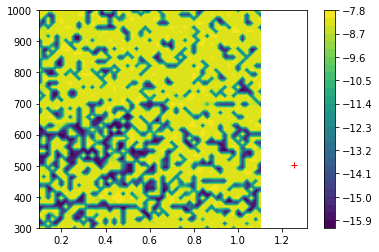

In [320]:
# plt.contourf(mg_d0, mg_T0, np.log10(mg_fnorms+1e-16), levels=np.linspace(-17,10,20))
plt.contourf(mg_d0, mg_T0, np.log10(mg_fnorms+1e-16), levels=30)
plt.plot(mg_rhow[i,j,k]/mixtureWLMA.rhoc, mg_T[i,j,k], 'r+')
plt.colorbar()

In [165]:
''' Newton + Armijo line search '''
# Pick seed
# U0 = np.array([0.6, 900, 5e6, 273.16])
U0 = np.array([0.9, 800, 5e6, 273.16])

V = np.log(U0)
print(V)
fnorm_last = 0.0

V, f = iterate_log(V)

_U = np.exp(V)
_out = kern(*_U)
step = - np.linalg.solve(_out[1] * _out[2], _out[0]) / _U
f = _out[0]
step, f


greed_ratio = 0.5
step_reduction_factor = 0.8
a = 1.0 / step_reduction_factor
for i in range(6):
  a *= step_reduction_factor
  f_along_line = kern(*np.exp(V + a * step))[0]
  # f_along_line = kern(*np.exp(V + a * step))[0]
  # c * grad(norm(f)) dot J^{-1} f = c || f ||, since Newton sends model to zero
  tt = greed_ratio * np.linalg.norm(f)
  # LHS of Armijo condition
  armijoLHS = np.linalg.norm(f) - np.linalg.norm(f_along_line) - a * tt
  print(i)
  if armijoLHS >= 0:
    break
  

[-0.10536052  6.68461173 15.42494847  5.6100577 ]
0
1
2
3
4
5


In [199]:
''' Dev: Newton + Armijo'''
U0 = np.array([0.6, 900, 5e8, 273.16])
V = np.log(U0)


for _k in range(36):
  _U = np.exp(V)
  _out = kern(*_U)
  step = - np.linalg.solve(_out[1] * _out[2], _out[0]) / _U
  f = _out[0]

  # Boundary scaling for coordinate V[0]
  V0_min, V0_max = -10, 1.3
  if (V + step)[0] < V0_min:
    step *= (V0_min - V[0])/ step[0]
  elif (V + step)[0] > V0_max:
    step *= (V0_max - V[0])/ step[0]

  # Greed ratio in (0,1) for Armijo conditions
  greed_ratio = 0.1
  # Step reduction factor in (0, 1) used each iteraiton
  step_reduction_factor = 0.9
  # Set the step size factor (==1.0 the first time Armijo condition is checked)
  a = 1.0 / step_reduction_factor
  for i in range(6):
    a *= step_reduction_factor
    f_along_line = kern(*np.exp(V + a * step))[0]
    # c * grad(norm(f)) dot J^{-1} f = c || f ||, since Newton sends model to 0
    tt = greed_ratio * np.linalg.norm(f)
    # LHS of Armijo condition: improvement is at least a portion of a * |f|
    armijoLHS = np.linalg.norm(f) - np.linalg.norm(f_along_line) - a * tt
    if armijoLHS >= 0:
      break
    
  V += a * step
  print(V, np.linalg.norm(f_along_line))

[-10.           6.47666308  18.57568232   5.65012828] 116761596.1124652
[-9.00156353  6.05301225 17.57574143  5.96730843] 42950558.33557158
[-8.00577395  5.93250398 16.57608109  5.92550024] 15790217.23436587
[-7.0169541   5.92467813 15.578414    5.92464771] 5779849.082201346
[-6.04542606  5.92488105 14.59509201  5.92488106] 2075155.0076915089
[-5.10967428  5.96682764 13.6703307   5.96682764] 683677.2357026578
[-4.21284621  5.98716202 12.93337905  5.98716202] 180711.76431565525
[-3.2899245   5.99603434 12.55798926  5.99603434] 24563.406273873203
[-2.34687946  5.9985855  12.49983111  5.9985855 ] 359.8989884578072
[-1.49065262  5.99879625 12.50102994  5.99879625] 0.5882588830540711
[-0.82960654  5.99880185 12.50109974  5.99880185] 0.021077085456717187
[-0.48610626  5.9988019  12.50110034  5.9988019 ] 0.0032386707012160235
[-0.41168812  5.9988019  12.50110034  5.9988019 ] 0.00011757335998099179
[-0.4087778   5.9988019  12.50110034  5.9988019 ] 1.7092404649117472e-07
[-0.40877355  5.9988019

In [632]:
256*96

24576

In [638]:
''' Test: output '''

vec_yw = np.linspace(0.01, 0.9999, 16) # 125
vec_T = np.linspace(280, 1500, 24) # 130
vec_rhow = np.linspace(0.5, 1050, 16) # 60
vec_ya = np.linspace(0.01, 0.99, 24)

mg_yw, mg_T, mg_rhow, mg_ya = np.meshgrid(
  vec_yw, vec_T, vec_rhow, vec_ya, indexing="ij")

mg_p_target = np.empty_like(mg_yw)
mg_vol_energy = np.empty_like(mg_yw)
mg_rho_mix = np.empty_like(mg_yw)

mg_p_calc = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)


# Iteratively load complete conservative state
for i, j, k, l in np.ndindex(mg_yw.shape):
  mg_vol_energy[i,j,k,l], mg_rho_mix[i,j,k,l], mg_p_target[i,j,k,l] = \
    prim_to_cons(mg_yw[i,j,k,l], mg_T[i,j,k,l], mg_rhow[i,j,k,l], mg_ya[i,j,k,l])

mg_p_calc = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)

for i, j, k, l in np.ndindex(mg_yw.shape):
  # Skip nan inputs
  if np.isnan(mg_yw[i,j,k,l]) \
      or np.isnan(mg_vol_energy[i,j,k,l]) \
      or np.isnan(mg_rho_mix[i,j,k,l]):
    mg_p_calc[i,j,k,l] = 0.0
    mg_T_calc[i,j,k,l] = 0.0
    continue

  # Set best seed
  U0 = np.array([1, 400, 100e6, 300])

  # Redefine kernel
  vol_energy = mg_vol_energy[i,j,k,l]
  rho_mix = mg_rho_mix[i,j,k,l]
  yw = mg_yw[i,j,k,l]
  ya = mg_ya[i,j,k,l]
  kern = lambda d, T, pr, Tr: float_mix_functions.kernel4_WLMA(d, T, pr, Tr,
    vol_energy, rho_mix, yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

  # Log map
  # V = np.log(U0)
  U = U0
  # Newton iteration
  for _k in range(128):
    # Newton step with backtracking
    U, f = iterate_backtrack_box(U)
    fnorm = np.linalg.norm(f)
    if fnorm < 1e-12:
      break
    if np.any(np.isnan(f)):
      fnorm = 1e10
      print(kern(*U), vol_energy, rho_mix, yw)
      raise Exception("Nan encountered, dumping")
  
  # Compute final U = [d, T, pr, Tr]
  T_calc = U[1]
  p_calc = float_mix_functions.p(U[0] * mixtureWLMA.rhoc, U[1])
  mg_p_calc[i,j,k,l], mg_T_calc[i,j,k,l] = p_calc, T_calc

In [630]:
''' Test: ym = 0.0 '''

vec_yw = np.linspace(0.01, 0.9999, 16) # 125
vec_T = np.linspace(280, 1500, 18) # 130
vec_rhow = np.linspace(0.5, 1050, 17) # 60
vec_ya = np.array([0])

mg_yw, mg_T, mg_rhow, mg_ya = np.meshgrid(
  vec_yw, vec_T, vec_rhow, vec_ya, indexing="ij")

mg_p_target = np.empty_like(mg_yw)
mg_vol_energy = np.empty_like(mg_yw)
mg_rho_mix = np.empty_like(mg_yw)

mg_p_calc = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)


# Iteratively load complete conservative state
for i, j, k, l in np.ndindex(mg_yw.shape):
  mg_vol_energy[i,j,k,l], mg_rho_mix[i,j,k,l], mg_p_target[i,j,k,l] = \
    prim_to_cons(mg_yw[i,j,k,l], mg_T[i,j,k,l], mg_rhow[i,j,k,l], 1 - mg_yw[i,j,k,l])

mg_p_calc = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)

for i, j, k, l in np.ndindex(mg_yw.shape):
  # Skip nan inputs
  if np.isnan(mg_yw[i,j,k,l]) \
      or np.isnan(mg_vol_energy[i,j,k,l]) \
      or np.isnan(mg_rho_mix[i,j,k,l]):
    mg_p_calc[i,j,k,l] = 0.0
    mg_T_calc[i,j,k,l] = 0.0
    continue

  # Set best seed
  U0 = np.array([1, 400, 100e6, 300])

  # Redefine kernel
  vol_energy = mg_vol_energy[i,j,k,l]
  rho_mix = mg_rho_mix[i,j,k,l]
  yw = mg_yw[i,j,k,l]
  ya = 1 - yw #mg_ya[i,j,k,l]
  kern = lambda d, T, pr, Tr: float_mix_functions.kernel4_WLMA(d, T, pr, Tr,
    vol_energy, rho_mix, yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

  # Log map
  # V = np.log(U0)
  U = U0
  # Newton iteration
  for _k in range(128):
    # Newton step with backtracking
    U, f = iterate_backtrack_box(U)
    fnorm = np.linalg.norm(f)
    if fnorm < 1e-12:
      break
    if np.any(np.isnan(f)):
      fnorm = 1e10
      print(kern(*U), vol_energy, rho_mix, yw)
      raise Exception("Nan encountered, dumping")
  
  # Compute final U = [d, T, pr, Tr]
  T_calc = U[1]
  p_calc = float_mix_functions.p(U[0] * mixtureWLMA.rhoc, U[1])
  mg_p_calc[i,j,k,l], mg_T_calc[i,j,k,l] = p_calc, T_calc

ValueError: Could not backtrack to a satisfactory step.

In [582]:
# np.save("mg_T_calc", mg_T_calc)
# np.save("mg_p_calc", mg_p_calc)
# np.save("mg_vol_energy", mg_vol_energy)
# np.save("mg_rho_mix", mg_rho_mix)
# np.save("mg_yw", mg_yw)
# np.save("mg_ya", mg_ya)

In [616]:
np.nanmax(p_reldiffs)

83.95281767071158

In [620]:
mg_vol_energy.shape, p_reldiffs.ravel()[_ind_probe]

((16, 18, 17, 1), 83.95281767071158)

In [622]:
mg_p_target.ravel()[_ind_probe]

21142664.98471067

In [629]:
# Drill

# Set best seed
U0 = np.array([1, 400, 100e6, 300])
# U0 = np.array([1, 1200, 100e7, 1200])

# Redefine kernel
_ind_probe = np.nanargmax(p_reldiffs.ravel())
vol_energy = mg_vol_energy.ravel()[_ind_probe]
rho_mix = mg_rho_mix.ravel()[_ind_probe]
yw = mg_yw.ravel()[_ind_probe]
ya = 1 - yw
kern = lambda d, T, pr, Tr: float_mix_functions.kernel4_WLMA(d, T, pr, Tr,
  vol_energy, rho_mix, yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

U = U0
# Newton iteration
for _k in range(128):
  # Newton step with backtracking
  U, f = iterate_backtrack_box(U)
  fnorm = np.linalg.norm(f)
  # print(U)
  print(U, fnorm)
  if fnorm < 1e-12:
    break
  if np.any(np.isnan(f)):
    fnorm = 1e10
    print(kern(*U), vol_energy, rho_mix, yw)
    raise Exception("Nan encountered, dumping")

1.0 [ 5.20948343e-01  9.10693981e+01 -9.90727018e+07  1.91069398e+02]
[1.52094834e+00 4.91069398e+02 9.27298184e+05 4.91069398e+02] 1301399.8979377192
1.0 [-6.98093452e-01 -6.30641839e+00  1.03015477e+06 -6.30641839e+00]
[8.22854890e-01 4.84762980e+02 1.95745295e+06 4.84762980e+02] 12496.158880786696
0.01384128720099999 [1.23968143e+00 1.59674837e+01 6.36673252e+05 1.59674837e+01]
[8.40013677e-01 4.84983990e+02 1.96626533e+06 4.84983990e+02] 12337.898325716003
0.01384128720099999 [1.27374263e+00 1.58647584e+01 6.34610979e+05 1.58647584e+01]
[8.57643915e-01 4.85203579e+02 1.97504916e+06 4.85203579e+02] 12181.673362944572
0.01384128720099999 [1.30909014e+00 1.57618540e+01 6.32507672e+05 1.57618540e+01]
[8.75763407e-01 4.85421743e+02 1.98380388e+06 4.85421743e+02] 12027.45566114392
0.01384128720099999 [1.34578877e+00 1.56587837e+01 6.30363815e+05 1.56587837e+01]
[8.94390856e-01 4.85638481e+02 1.99252893e+06 4.85638481e+02] 11875.217323781455
0.01384128720099999 [1.38390747e+00 1.55555606e

ValueError: Could not backtrack to a satisfactory step.

In [401]:
mg_p_target.ravel()[_ind_probe]

92578035.24358186

In [ ]:
mg_T

In [654]:
import dill

# Unpicklable
# del iapws95_light.reader

filepath = 'session_redirect.pkl'
dill.dump_session(filepath) # Save the session
# dill.load_session(filepath)

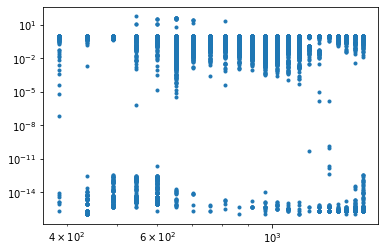

In [646]:
p_diffs = np.abs(mg_p_calc - mg_p_target)
p_reldiffs = np.abs(mg_p_calc / mg_p_target - 1.0)
plt.loglog(mg_T[np.where(~np.isnan(p_reldiffs))], p_reldiffs[np.where(~np.isnan(p_reldiffs))], '.')


In [123]:
''' Dev: Trust region '''
# Pick seed
U0 = np.array([0.6, 900, 5e6, 273.16])
V = np.log(U0)
print(V)
fnorm_last = 0.0
for _k in range(13):
  V, f = iterate_log(V)
  fnorm = np.linalg.norm(f)
  if _k > 0:
    # Compare (predicted improvement) / (actual improvement)
    print(V, fnorm, fnorm_last/(fnorm_last-fnorm))
  else:
    print(V, fnorm)
  fnorm_last = fnorm
iterate_log(V)

[-0.51082562  6.80239476 15.42494847  5.6100577 ]
[-2.29010989  6.22042101 -8.03052937  5.98735901] 55714099.66507491
[ 2.49604017  6.11201038 -6.90493368  6.11295471] 722147316.7454082 -0.08360042422429105
[ 2.3061423   5.81553183 -6.20207627  5.81581212] 637325524048.2023 -0.0011343755674893896
[ 2.12376579  5.80281256 -5.21507223  5.80281616] 187221355945.40067 1.4159511713356099
[ 1.89948814  5.90316695 -4.11472183  5.90316659] 80365992407.96638 1.7521006877657763
[ 1.70951923  6.02774521 -2.99014324  6.02774525] 31197695795.450638 1.6345083711423367
[ 1.51635844  6.01790985 -1.99997883  6.01790985] 12340929234.037226 1.6544562766816266
[ 1.34882724  6.00807995 -1.00980925  6.00807995] 4167056335.1220403 1.5098019490460979
[ 1.20764963  6.00328977 -0.01460082  6.00328977] 1404147404.8816874 1.5082134230025226
[1.11272223 6.00055337 0.982659   6.00055337] 428388663.27188426 1.4390313353125899
[1.0725895  5.99937078 1.98146614 5.99937078] 101252357.07295476 1.3095112194957164
[1.0659

(array([-755.02977749,    5.91628544,    4.89964143,    5.91628544]),
 array([-3.76109500e-06,  4.43661069e+03,  2.69762388e+05,  0.00000000e+00]))

In [108]:
_U = np.exp(V)
_out = kern(*_U)
_U, _out, V - np.linalg.solve(_out[1] * _out[2], _out[0]) / _U

(array([  2.90292809, 403.09256443,  53.57902763, 403.09256443]),
 (array([-3.76109500e-06,  4.43661069e+03,  2.69762388e+05,  0.00000000e+00]),
  array([[3.57703651e-08, 3.57703651e-08, 8.17280885e-07, 8.17280885e-07],
         [8.61781870e+00, 1.00000000e+00, 1.96899821e+02, 1.96899821e+02],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]]),
  array([[-1.09984307e+03,  4.25506497e+03,  2.04126331e-12,
           2.97617601e+03],
         [-3.68528919e-04,  0.00000000e+00, -4.20630549e-01,
           5.59101750e-02],
         [ 0.00000000e+00,  8.07315940e+03, -1.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          -1.00000000e+00]]),
  {'x': 2.3961592380575815e-07,
   'ew': 545850.4204760102,
   'v': 0.001069812950507944,
   'ul': 545849.94277213,
   'uv': 2539473.2072031153,
   'vl': 0.0010696528843136875,
   'vv': 0.6690811

## Testing: Cython implementation of conservative to primitive map

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light

# Cython-backend imports
import float_phi_functions
import float_mix_functions
import iapws95_light_perf
import mixtureWLM

In [2]:
from time import perf_counter
import scipy.optimize

K = mixtureWLM.K
p_m0 = mixtureWLM.p_m0
rho_m0 = mixtureWLM.rho_m0
v_m0 = 1.0 / rho_m0
c_v_m0 = 3e3

def run_float_mix_function(yw, T, rhow):
  ''' Run manager with rhow as 3rd input '''
  # Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return np.nan, np.nan, 0.0, np.nan
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rho_mix = 1.0/(yw / rhow + (1 - yw) / rhom )
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  u_target = yw*uw_target + (1-yw)*um_target 
  vol_energy = rho_mix * u_target
  rho_target = rho_mix
  T_target = T
  # Run with timer
  N_samples = 1
  t1 = perf_counter()
  for i in range(N_samples):
    _out = float_mix_functions.conservative_to_pT_WLM(vol_energy, rho_mix,
      yw, K, p_m0, rho_m0, c_v_m0)
    p = _out["p"]
    T = _out["T"]
  t2 = perf_counter()
  return p, p_target, (t2-t1)/N_samples, T

v_yw = np.linspace(0.01, 0.9999, 125)
v_T = np.linspace(280, 1500, 130)
v_rhow = np.linspace(0.5, 1050, 60)

mg_yw, mg_T, mg_rhow = np.meshgrid(v_yw, v_T, v_rhow, indexing="ij")
# mg_yw, mg_T, mg_p = np.meshgrid(v_yw, v_T, v_p, indexing="ij")

mg_p_calc = np.empty_like(mg_yw)
mg_p_target = np.empty_like(mg_yw)
mg_wallt = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)

for i, j, k in np.ndindex(mg_yw.shape):
  mg_p_calc[i,j,k], mg_p_target[i,j,k], mg_wallt[i,j,k], mg_T_calc[i,j,k] = \
    run_float_mix_function(mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k])

Text(0, 0.5, 'counts')

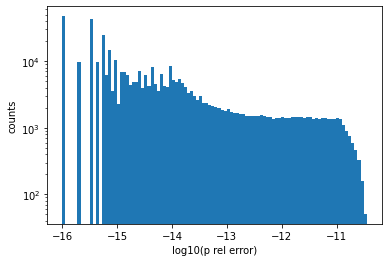

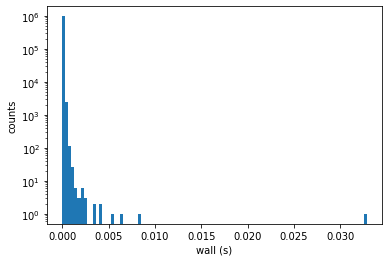

In [3]:
plt.figure()
plt.hist(np.log10(1e-16+np.abs(mg_p_calc / mg_p_target - 1.0).ravel()), bins=100, log=True)
plt.xlabel("log10(p rel error)")
plt.ylabel("counts")
plt.figure()
plt.hist(mg_wallt.ravel(), bins=100, log=True)
plt.xlabel("wall (s)")
plt.ylabel("counts")


In [4]:
# WLMA model special case: ya = 0.0
from time import perf_counter
import scipy.optimize

K = mixtureWLM.K
p_m0 = mixtureWLM.p_m0
rho_m0 = mixtureWLM.rho_m0
v_m0 = 1.0 / rho_m0
c_v_m0 = 3e3

def run_float_mix_function(yw, T, rhow):
  ''' Run manager with rhow as 3rd input '''
  # Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return np.nan, np.nan, 0.0, np.nan
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rho_mix = 1.0/(yw / rhow + (1 - yw) / rhom )
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  u_target = yw*uw_target + (1-yw)*um_target 
  vol_energy = rho_mix * u_target
  rho_target = rho_mix
  T_target = T
  # Run with timer
  N_samples = 1
  t1 = perf_counter()
  for i in range(N_samples):
    _out = float_mix_functions.conservative_to_pT_WLMA(vol_energy, rho_mix,
      yw, 0.0, K, p_m0, rho_m0, c_v_m0, 287, 1.4)
    p = _out["p"]
    T = _out["T"]
  t2 = perf_counter()
  return p, p_target, (t2-t1)/N_samples, T

v_yw = np.linspace(0.01, 0.9999, 125)
v_T = np.linspace(280, 1500, 130)
v_rhow = np.linspace(0.5, 1050, 60)

mg_yw, mg_T, mg_rhow = np.meshgrid(v_yw, v_T, v_rhow, indexing="ij")
# mg_yw, mg_T, mg_p = np.meshgrid(v_yw, v_T, v_p, indexing="ij")

mg_p_calc = np.empty_like(mg_yw)
mg_p_target = np.empty_like(mg_yw)
mg_wallt = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)

for i, j, k in np.ndindex(mg_yw.shape):
  mg_p_calc[i,j,k], mg_p_target[i,j,k], mg_wallt[i,j,k], mg_T_calc[i,j,k] = \
    run_float_mix_function(mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k])

Text(0, 0.5, 'counts')

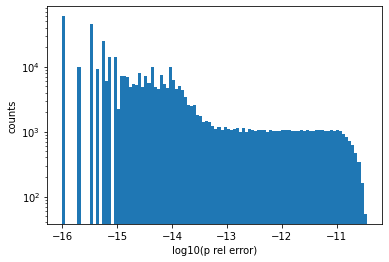

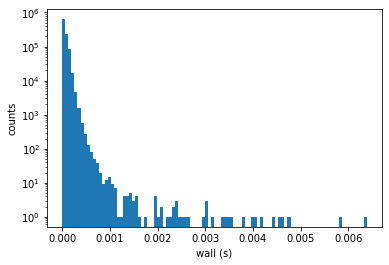

In [5]:
''' Histogram WLMA at ya = 0'''
plt.figure()
# plt.hist(np.clip(np.log10(np.abs(mg_p_calc / mg_p_target - 1.0).ravel()), -16, -7), bins=100, log=True)
# supcrit_indices = np.where(mg_T.ravel()>=iapws95_light.Tc)
plt.hist(np.log10(1e-16+np.abs(mg_p_calc / mg_p_target - 1.0).ravel()[:]), bins=100, log=True)
plt.xlabel("log10(p rel error)")
plt.ylabel("counts")
plt.figure()
plt.hist(mg_wallt.ravel(), bins=100, log=True)
plt.xlabel("wall (s)")
plt.ylabel("counts")

In [4]:
# WLMA model special case: ya = 0.1
from time import perf_counter
import scipy.optimize

K = mixtureWLM.K
p_m0 = mixtureWLM.p_m0
rho_m0 = mixtureWLM.rho_m0
v_m0 = 1.0 / rho_m0
c_v_m0 = 3e3
ya = 0.1
R_a = 287
gamma_a = 1.4

def run_float_mix_function(yw, T, rhow):
  ''' Run manager with rhow as 3rd input '''
  # Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return np.nan, np.nan, 0.0, np.nan
  rhom = rho_m0 * (1.0 + (p_target - p_m0) / K)
  rhoa = p_target / (R_a * T)
  rho_mix = 1.0/(yw / rhow + (1 - yw - ya) / rhom + ya / rhoa)
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  ua_target = R_a / (gamma_a - 1) * T
  u_target = yw*uw_target + (1-yw-ya)*um_target + ya*ua_target
  vol_energy = rho_mix * u_target
  rho_target = rho_mix
  T_target = T
  # Run with timer
  N_samples = 1
  t1 = perf_counter()
  for i in range(N_samples):
    _out = float_mix_functions.conservative_to_pT_WLMA(vol_energy, rho_mix,
      yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
    p = _out["p"]
    T = _out["T"]
  t2 = perf_counter()
  return p, p_target, (t2-t1)/N_samples, T

# v_yw = np.linspace(0.01, 0.9999-ya, 125)
# v_T = np.linspace(280, 1500, 130)
# v_rhow = np.linspace(0.5, 1050, 60)

v_yw = np.linspace(0.01, 0.9999-ya, 63)
v_T = np.linspace(280, 1500, 65)
v_rhow = np.linspace(0.5, 1050, 30)


mg_yw, mg_T, mg_rhow = np.meshgrid(v_yw, v_T, v_rhow, indexing="ij")
# mg_yw, mg_T, mg_p = np.meshgrid(v_yw, v_T, v_p, indexing="ij")

mg_p_calc = np.empty_like(mg_yw)
mg_p_target = np.empty_like(mg_yw)
mg_wallt = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)

for i, j, k in np.ndindex(mg_yw.shape):
  mg_p_calc[i,j,k], mg_p_target[i,j,k], mg_wallt[i,j,k], mg_T_calc[i,j,k] = \
    run_float_mix_function(mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k])

Text(0, 0.5, 'counts')

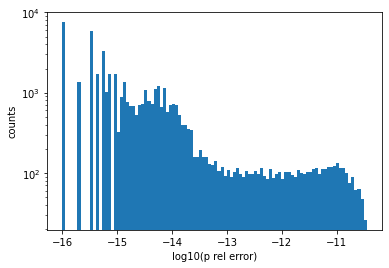

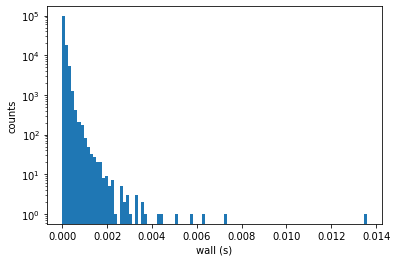

In [5]:
''' Histogram WLMA at ya = 0.1'''
plt.figure()
# plt.hist(np.clip(np.log10(np.abs(mg_p_calc / mg_p_target - 1.0).ravel()), -16, -7), bins=100, log=True)
# supcrit_indices = np.where(mg_T.ravel()>=iapws95_light.Tc)
plt.hist(np.log10(1e-16+np.abs(mg_p_calc / mg_p_target - 1.0).ravel()[:]), bins=100, log=True)
plt.xlabel("log10(p rel error)")
plt.ylabel("counts")
plt.figure()
plt.hist(mg_wallt.ravel(), bins=100, log=True)
plt.xlabel("wall (s)")
plt.ylabel("counts")

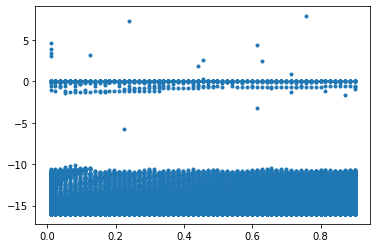

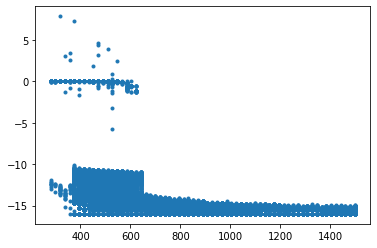

In [5]:
plt.plot(mg_yw.ravel(), np.log10(1e-16+np.abs(mg_p_calc / mg_p_target - 1.0).ravel()[:]), '.')
plt.figure()
plt.plot(mg_T.ravel(), np.log10(1e-16+np.abs(mg_p_calc / mg_p_target - 1.0).ravel()[:]), '.')

In [6]:
# Compute conservative variables from primitives

def prim_to_cons(yw, T, rhow, ya):
# Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return yw, np.nan, np.nan
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rhoa = p_target / (R_a * T)
  rho_mix = 1.0/(yw / rhow + (1 - yw - ya) / rhom + ya / rhoa)
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  ua_target = R_a / (gamma_a - 1.0) * T
  u_target = yw*uw_target + (1-yw-ya)*um_target + ya*ua_target
  vol_energy = rho_mix * u_target

  return (yw, vol_energy, rho_mix)

In [7]:
# Target largest relative error in p
i_target = np.nanargmax(np.abs(mg_p_calc / mg_p_target - 1.0).ravel())
# Grab primitive values
yw, T, rhow = mg_yw.ravel()[i_target], mg_T.ravel()[i_target], \
  mg_rhow.ravel()[i_target]
# Get inputs
yw, vol_energy, rho_mix = prim_to_cons(yw, T, rhow, ya)
# Call debug mirror
print("Targets: ")
print(f"rhow = {rhow}, T = {T}")
_z = float_mix_functions.conservative_to_pT_WLMA_debug(vol_energy, rho_mix,
      yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
_z

Targets: 
rhow = 1013.8103448275863, T = 318.125


([(None, 11947.228918551138, 316.86653391502966, 'init'),
  (17957.78261377154, 990.7077770073993, 316.86653391502966, 'start-subcrit'),
  (None, 888.6137518739719, 316.86653391502966, 'start-recovery'),
  (9096.93923039474, 808.9402432700825, 317.1172332315706, 'iter-subcrit'),
  (9098.083931679506, 863.915260230865, 317.1196621011404, 'iter-subcrit'),
  (9095.579235063511, 659.7281087926733, 317.11434720103074, 'iter-subcrit'),
  (9131.409029379836, 685.5780108765413, 317.19025744957054, 'iter-subcrit'),
  (9159.275376267035, 708.1243096024608, 317.2491189707801, 'iter-subcrit'),
  (9180.594523886013, 728.3528503906198, 317.29404696290413, 'iter-subcrit'),
  (9196.314233979672, 747.1865102130813, 317.32711719620795, 'iter-subcrit'),
  (9207.091868997535, 766.0314868285107, 317.34976246206213, 'iter-subcrit'),
  (9213.507257219977, 788.0106673365324, 317.3632312256262, 'iter-subcrit'),
  (9216.48264544551, 820.7512480299271, 317.3694751531947, 'iter-subcrit'),
  (9215.67158503707, 753

In [11]:
mg_p_target.ravel()[i_target]

84490436.73178335

In [8]:
p_target = mg_p_target.ravel()[i_target]
T, ya, yw, p_target, rho_mix, rhow

(661.25,
 0.1,
 0.13917903225806452,
 31776170.673359144,
 867.5284343289081,
 507.15517241379314)

In [39]:
R_a * T / p_target * ya + (1 - ya - yw) / (rho_m0 * (1 + (p_target - p_m0)/K)), 1/rho_mix - yw/rhow

(0.000824332849613978, 0.0008243328496139781)

In [7]:
vol_energy, rho_mix, yw

(4839727806.978861, 2536.540998480737, 0.01)

In [87]:
float_mix_functions.conservative_to_pT_WLMA(vol_energy, rho_mix,
      yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

{'rhow': -1010.166287934906, 'p': 2.4665371630853877e+33, 'T': 273.16}

In [13]:
np.nanargmax(np.abs(mg_p_calc / mg_p_target - 1.0).ravel())

21657

In [82]:
T = 604.0625
T, float_phi_functions.prho_sat(T)

(604.0625,
 {'psat': 13009829.107459407,
  'rho_satl': 638.2037909488992,
  'rho_satv': 78.32774158287353})

### Local inspection mirror

In [9]:
p_target = mg_p_target.ravel()[i_target]
T_target = mg_T.ravel()[i_target]
rhow_target = mg_rhow.ravel()[i_target]
yw = mg_yw.ravel()[i_target]
# Get inputs
yw, vol_energy, rho_mix = prim_to_cons(yw, T_target, rhow_target, ya)
p_target, T_target, rhow_target, vol_energy, rho_mix, yw

(31776170.673359144,
 661.25,
 507.15517241379314,
 1572547361.5797963,
 867.5284343289081,
 0.13917903225806452)

In [10]:
from types import SimpleNamespace

#Open function
vol_energy, rho_mix, \
yw, ya, K, p_m0, rho_m0, \
c_v_m0, R_a, gamma_a

ym = 1.0 - yw - ya
v_mix = 1.0/rho_mix
d = 1.0
c_v_a = R_a / (gamma_a - 1.0)
min_vw = 1e-5
Tc = iapws95_light.Tc
rhoc = iapws95_light.rhoc
R = iapws95_light.R
vc = 1.0 / rhoc

rho_w0 = 997.0
T_w0 = 300.0
p_w0 = 1089221.889890747 # p(rho_w0, T_w0)
e_w0 = 112471.63726846411 # u(rho_w0, T_w0)
c_v_w0 = 4126.9245339247345 # c_v(rho_w0, T_w0)
# Set saturated vapour linearization point
T_gas_ref = 100+273.15
p_gas_ref = 101417.99665995548 # prho_sat(273.15+100)["psat"]
rho_gas_ref = 0.5981697919259701 # prho_sat(273.15+100)["rho_satv"]
e_gas_ref = 2506022.7123141396 # u(rho_gas_ref, 273.15+100)
c_v_gas_ref = 1555.8307465765565 # c_v(rho_gas_ref, 273.15+100)

i = 0
MAX_NEWTON_ITERS = 64
trust_region_size = 1e80
fabs = np.abs
log = np.log

if rho_mix < 10.0:
  # Due to an issue with flip-flopping for a low-density gas:
  T = ((vol_energy / rho_mix) - yw * (e_gas_ref - c_v_gas_ref * T_gas_ref)) \
  / (yw * c_v_gas_ref + ym * c_v_m0 + ya * c_v_a)
else:
  # Estimate temperature
  T = ((vol_energy / rho_mix) - yw * (e_w0 - c_v_w0 * T_w0)) \
    / (yw * c_v_w0 + ym * c_v_m0 + ya * c_v_a)
  # if yw >= 0.2:
  #   # Refine estimate using a posteriori approximation of residual
  #   T += poly_T_residual_est(yw, vol_energy, rho_mix)
''' Estimate d(T_c) '''
# One-step Newton approximation of critical-temperature value
d = 1.0
out_pair = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(
  d, Tc, rho_mix, yw, ya, K, p_m0, rho_m0, R_a, gamma_a))
d -= out_pair.first/out_pair.second
''' Estimate supercriticality based on energy at Tc '''
# Quantify approximately supercriticality (rho is approximate, and magma
#   mechanical energy is neglected)
is_supercritical = yw * float_phi_functions.u(d*rhoc, Tc) \
  + ym * (c_v_m0 * Tc) + ya * (c_v_a * Tc) < vol_energy/rho_mix
''' Clip T_init based on supercriticality estimate '''
# Clip initial temperature guess to above or below supercritical
if is_supercritical and T < Tc + 1.0:
  T = Tc + 1.0
elif not is_supercritical and T > Tc - 1.0:
  T = Tc - 1.0


In [9]:
T, is_supercritical, T_target, d, d*rhoc

(472.1353308198902, False, 470.625, 1.2478503404642607, 401.80780962949194)

In [11]:
d, T

(14.56461207412195, 646.096)

In [10]:

''' Cold-start compute pressure, water phasic density '''
if not is_supercritical:
  # Compute saturation properties
  sat_triple = SimpleNamespace(**float_phi_functions.prho_sat(T))
  psat, rho_satl, rho_satv = \
    sat_triple.psat, sat_triple.rho_satl, sat_triple.rho_satv
  # Compute tentative density value
  rhow = yw / (v_mix - ym * K / rho_m0 / (psat + K - p_m0) \
          - ya * R_a * T / psat)
  if rhow <= 0:
      # Pressurize above saturated liquid
      rhow = rho_satl*(1+1e-6)
  if rho_satv <= rhow and rhow <= rho_satl:
    # start_case = "start-LV"
    # Accept tentative mixed-phase value of density
    d = rhow / rhoc
    # Compute pressure from sat vapor side
    pmix = psat
  else:
    # start_case = "start-subcrit"
    print("Subcrit selection")
    # Select pure vapor or pure liquid phase density
    # if rhow < rho_satv and rhow > 0:
    #   d = rho_satv/rhoc
    #   print("satV")
    # else:
    #   d = rho_satl/rhoc # TODO: changed
    #   print("satL")
    d = rho_satv/rhoc if (0 < rhow and rhow < rho_satv) else rho_satl/rhoc
    # Refine estimate of d from one Newton iteration
    out_pair = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(d, T, rho_mix, yw, ya, K, p_m0,
      rho_m0, R_a, gamma_a))
    d -= out_pair.first/out_pair.second
    # Compute pressure
    pmix = float_phi_functions.p(d*rhoc, T)
else:
  # start_case = "start-supercrit"
  # Refine estimate of d from one Newton iteration
  out_pair = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(d, T, rho_mix, yw, ya, K, p_m0,
    rho_m0, R_a, gamma_a))
  d -= out_pair.first/out_pair.second
  # Compute pressure
  pmix = float_phi_functions.p(d*rhoc, T)
# Clip temperatures below the triple point temperature
if T < 273.16:
  T = 273.16

d, pmix

Subcrit selection


(2.6909503832776087, 2376685.087911193)

In [13]:
pmix, d*rhoc, T, rhow_target

(2376685.087911193, 866.48602341539, 472.1353308198902, 869.051724137931)

In [68]:
# rho_satv/rhoc if rhow < rho_satv else rho_satl/rhoc
d = rho_satl/rhoc
out_pair = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(d, T, rho_mix, yw, ya, K, p_m0,
    rho_m0, R_a, gamma_a))
d -= out_pair.first/out_pair.second
# Compute pressure
pmix = float_phi_functions.p(d*rhoc, T)

In [21]:
t = Tc/T
is_mixed = False
# Set default case string
# case_str = "iter-supercrit"

print(T < Tc)
# Check saturation curves
sat_triple = SimpleNamespace(**float_phi_functions.prho_sat(T))
psat, rho_satl, rho_satv = \
  sat_triple.psat, sat_triple.rho_satl, sat_triple.rho_satv
# Compute volume-sum constrained density value if pm = psat
rhow = yw / (v_mix - ym * K / rho_m0 / (psat + K - p_m0) \
      - ya * R_a * T / psat)

True


In [12]:
_d = d
print(_d)
for i in range(20):
  _out = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(_d, T, rho_mix, yw, ya, K, p_m0,
    rho_m0, R_a, gamma_a))
  _d -= _out.first/_out.second
  print(_d)

14.56461207412195
12.470175058322802
10.843478247445518
9.370316124543885
7.765955666842755
6.0436772364287155
4.640623073572245
3.267452367298709
1.6187034970651155
1.7933642085958834
1.755396506978617
1.7540322720949626
1.7540302373545504
1.7540302373500103
1.754030237350018
1.754030237350008
1.7540302373500123
1.7540302373500176
1.7540302373500085
1.754030237350006
1.7540302373500067


In [43]:
rhow/rhoc

1.9121867637609768

In [49]:

d, T = 470.3179179892538/rhoc, 642.6526780548097
# Compute pressure
pmix = float_phi_functions.p(d*rhoc, T)

In [50]:
d = _d

In [51]:
t = Tc / T
# for i in range(20):
#   _out = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(d, T, rho_mix, yw, ya, K, p_m0,
#     rho_m0, R_a, gamma_a))
#   d -= _out.first/_out.second

rhow = d*rhoc
rhom = ym / (1.0 / rho_mix - yw / rhow - ya * (R_a * T) / pmix)
# Evaluate phir derivatives (cost-critical)
_phirall = SimpleNamespace(**float_phi_functions.fused_phir_all(d, Tc/T))
# Compute pure-phase heat capacity
_c_v_w = -t * t * R * (_phirall.phir_tt + float_phi_functions.phi0_tt(d, t))
# Compute pure-phase energy
_u = R * Tc * (_phirall.phir_t + float_phi_functions.phi0_t(d, t))

''' Compute slopes '''
# Compute compressibility, partial of compressibility
Z = 1.0 + d * _phirall.phir_d
Z_d = _phirall.phir_d + d * _phirall.phir_dd
Z_T = d * _phirall.phir_dt * (-Tc / (T*T))
# Compute intermediates
_c1 = (v_mix * d - (yw + ya*R_a/(Z *R)) / rhoc)
# Compute derivatives of pressure equilibrium level set function 
#  R * T *psi(d, T) = 0 constrains d(t).
#  Note the difference with the Newton slope-pair function.
#  Here we use the form of equation with T appearing only once
#  d1psi is d/dd (nondim) and d2psi is d/dT (dim) of (R * T * psi(d,T)).
d1psi = (v_mix + ya * R_a / R / rhoc * Z_d / (Z * Z)) \
  * (Z * d * rhoc * R * T + K - p_m0) - K * ym / rho_m0 \
  + _c1 * (rhoc * R * T * (Z + d * Z_d))
d2psi = (ya * R_a / R / rhoc * Z_T / (Z * Z)) \
  * (Z * d * rhoc * R * T + K - p_m0) \
  + _c1 * (Z + T * Z_T) * d * rhoc * R
# Compute density-temperature slope under the volume addition constraint
drhowdT = -d2psi / d1psi * rhoc
# Compute density-temperature slope for m state
drhomdT = -(rhom*rhom/ ym) * (yw * (drhowdT / (rhow*rhow)) 
  + ya * (R_a * T / (pmix*pmix)) * (
    - pmix / T  +
    rhoc * R * ((1.0 + d * _phirall.phir_d) * d 
      - d * d * _phirall.phir_dt * Tc / T)
    + (1.0 + 2.0 * d * _phirall.phir_d + d * d * _phirall.phir_dd)
      * R * T * drhowdT))
# Compute water energy-temperature slope
dewdT = _c_v_w + R * Tc / rhoc * _phirall.phir_dt * drhowdT
# Compute magma energy-temperature slope (c_v dT + de/dv * dv, v = v(T))
demdT = c_v_m0 \
  + pmix / (rhom*rhom) * drhomdT # - p dv = p (drho) / rho^2
# Compute mixture energy-temperature slope
dedT = yw * dewdT + ym * demdT + ya * c_v_a
''' Compute Newton step for temperature '''
curr_energy = yw * _u \
  + ym * (c_v_m0 * T + float_mix_functions.magma_mech_energy(pmix, K, p_m0, rho_m0)) \
  + ya * c_v_a * T
# Temperature migration
dT = -(curr_energy - vol_energy/rho_mix)/dedT
# Limit to dT <= 100
dT *= min(1.0, 100.0/(1e-16+fabs(dT)))


# # Newton-step temperature
T += dT
# # Newton-step d (cross term in Jacobian)
d += drhowdT/rhoc
out_pair = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(d, T, rho_mix, yw, ya, K, p_m0,
  rho_m0, R_a, gamma_a))
d -= out_pair.first/out_pair.second
# # Update pressure
pmix = float_phi_functions.p(d*rhoc, T)
# # Update water phasic density
rhow = d * rhoc
d, T

(1.912200343027345, 642.1888820526249)

In [53]:
d * rhoc, mg_rhow.ravel()[i_target]

(615.7285104548051, 615.7241379310345)

In [90]:
(ya * R_a / R / rhoc * Z_T / (Z * Z)) \
  * (Z * d * rhoc * R * T + K - p_m0) \
  + _c1 * (Z + T * Z_T) * d * rhoc * R, \
(ya * R_a / R / rhoc * Z_T / (Z * Z)) \
  * (Z * d * rhoc * R * T + K - p_m0) \
  + _c1 * (Z) * d * rhoc * R

(10122.620687653569, 8724.05177582731)

In [ ]:
drhowdT + drhomdT + 

In [88]:
# drhowdT, drhomdT
dewdT, demdT, c_v_a, dedT

(3324.106903192609, 2997.6742620155555, 717.5000000000001, 3034.8882134843216)

In [84]:
d, d*rhoc, T

(3.036018473918552, 977.5979486017737, 394.33375515944886)

In [80]:
dT, T, T_target

(3.4316102969750695, 393.40610038908204, 394.375)

In [78]:
dT, d*rhoc

(3.4316102969750695, 978.0717248319427)

In [69]:
d_test = d
for i in range(15):
  out_pair = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(d_test, T, rho_mix, yw, ya, K, p_m0,
    rho_m0, R_a, gamma_a))
  d_test -= out_pair.first/out_pair.second
  print(d_test)

2.929195320623661
2.930435888812003
2.9328995430168887
2.9377525399328714
2.947129129342782
2.964357581114025
2.9918761541662895
3.0219624337028006
3.0360229358736603
3.037478092896238
3.0374898279281783
3.0374898286706293
3.0374898286706276
3.0374898286706293
3.0374898286706276


In [60]:
d * rhoc, T

(943.0004810159493, 393.40610038908204)

In [45]:
float_mix_functions.pure_phase_newton_pair_WLMA(d_test, Tc, rho_mix, yw, ya, K, p_m0,
    rho_m0, R_a, gamma_a)

{'first': 0.0, 'second': 10.315802412340872}

In [58]:
_phirall = SimpleNamespace(**float_phi_functions.fused_phir_all(d_test, Tc/T))
Z = 1.0 + d_test * _phirall.phir_d

_c1 = (v_mix * d_test - (yw + ya*R_a/(Z *R)) / rhoc)
_c1 * (Z * d_test * rhoc * R * T + K - p_m0) - K * ym / rho_m0 * d_test

1.4901161193847656e-08

In [55]:
# Comparison:
_d = d_test
_out = SimpleNamespace(**float_phi_functions.fused_phir_d_phir_dd(_d, Tc / T))
__phir_d = _out.first
__phir_dd = _out.second
# ym = 1.0 - yw - ya
Z = 1.0 + _d * __phir_d
Z_d = __phir_d + _d * __phir_dd
__val = rhoc / rho_mix * _d * _d * Z \
    - (yw * Z + ya * R_a / R) * _d \
    + (-(-K + p_m0) / rho_mix - K / rho_m0 * ym) / (R * T) * _d \
    - (K - p_m0) / (rhoc * R * T) * (yw + ya * R_a / R / Z)
__slope = rhoc / rho_mix * (2.0 * _d * Z + _d * _d * Z_d) \
    - (yw * Z + ya * R_a / R) - yw * _d * Z_d \
    + (-(-K + p_m0) / rho_mix - K / rho_m0 * ym) / (R * T) \
    - (K - p_m0) / (rhoc * R * T) * (-ya * R_a / R / (Z * Z) * Z_d)

In [57]:
__val, __slope

(6.394884621840902e-14, 38.88510961559338)

In [30]:
_c_v_w, _u

(3664.6680823061524, 504615.51850102784)

In [24]:
d, d* rhoc

(2.9285729224097805, 943.0004810159493)

In [97]:
''' Perform iteration for total energy condition '''
t = Tc/T
is_mixed = False
# Set default case string
# case_str = "iter-supercrit"

if T < Tc:
  # Check saturation curves
  sat_triple = SimpleNamespace(**float_phi_functions.prho_sat(T))
  psat, rho_satl, rho_satv = \
    sat_triple.psat, sat_triple.rho_satl, sat_triple.rho_satv
  # Compute volume-sum constrained density value if pm = psat
  rhow = yw / (v_mix - ym * K / rho_m0 / (psat + K - p_m0) \
        - ya * R_a * T / psat)
  if rho_satv <= rhow and rhow <= rho_satl:
    # case_str = "iter-LV"
    is_mixed = True
    # Accept tentative mixed-phase value of pressure, density
    pmix = psat
    d = rhow / rhoc
    # Compute steam fraction (fraction vapor mass per total water mass)
    x = (1.0 / rhow - 1.0 / rho_satl) / (1.0 / rho_satv - 1.0 / rho_satl)
    # Compute temperature update using saturation relation
    d0 = rho_satl/rhoc
    d1 = rho_satv/rhoc
    _phirall_0 = SimpleNamespace(**float_phi_functions.fused_phir_all(d0, Tc/T))
    _phirall_1 = SimpleNamespace(**float_phi_functions.fused_phir_all(d1, Tc/T))
    _phi0all_0 = SimpleNamespace(**float_phi_functions.fused_phi0_all(d0, Tc/T))
    _phi0all_1 = SimpleNamespace(**float_phi_functions.fused_phi0_all(d1, Tc/T))
    ''' Derivatives along Maxwell-constr. level set G(t, d0, d1) = 0 '''
    # Vector components of partial dG/dt = (dG0/dt; dG1/dt)
    dG0dt = d1*_phirall_1.phir_dt + _phirall_1.phir_t + _phi0all_1.phi0_t \
      - d0*_phirall_0.phir_dt - _phirall_0.phir_t - _phi0all_0.phi0_t
    dG1dt = d0*d0*_phirall_0.phir_dt - d1*d1*_phirall_1.phir_dt
    # Vector components of partial dG/d0
    dG0dd0 = -2.0*_phirall_0.phir_d \
      - d0*_phirall_0.phir_dd - _phi0all_0.phi0_d
    dG1dd0 = 1.0 + 2.0 * d0 * _phirall_0.phir_d + d0*d0*_phirall_0.phir_dd
    # Vector components of partial dG/d1
    dG0dd1 = 2.0*_phirall_1.phir_d \
      + d1*_phirall_1.phir_dd + _phi0all_1.phi0_d
    dG1dd1 = -1.0 - 2.0 * d1 * _phirall_1.phir_d - d1*d1*_phirall_1.phir_dd
    # Compute d(d0)/dt and d(d1)/dt constrainted to level set of G
    _det = dG0dd0 * dG1dd1 - dG0dd1 * dG1dd0
    dd0dt = -(dG1dd1 * dG0dt - dG0dd1 * dG1dt) / _det
    dd1dt = -(-dG1dd0 * dG0dt + dG0dd0 * dG1dt) / _det
    # Construct derivatives of volume:
    #   dv0/dt = partial(v0, t) + partial(v0, d) * dd0/dt
    #   dv0/dT = dv0/dt * dt/dT
    dv0dT = -1.0/(rhoc * d0 * d0) * dd0dt * (-Tc/(T*T))
    dv1dT = -1.0/(rhoc * d1 * d1) * dd1dt * (-Tc/(T*T))
    # Construct derivatives of internal energy
    du0dT = R * Tc * (
      (_phirall_0.phir_dt + _phi0all_0.phi0_dt) * dd0dt
      + (_phirall_0.phir_tt + _phi0all_0.phi0_tt)
    ) * (-Tc/(T*T))
    du1dT = R * Tc * (
      (_phirall_1.phir_dt + _phi0all_1.phi0_dt) * dd1dt
      + (_phirall_1.phir_tt + _phi0all_1.phi0_tt)
    ) * (-Tc/(T*T))
    # Construct dx/dT (change in steam fraction subject to mixture
    #   conditions) as partial(x, T) + partial(x, v) * dv/dT
    v  = 1.0/(d*rhoc)
    vl = 1.0/(d0*rhoc)
    vv = 1.0/(d1*rhoc)
    partial_dxdT = ((v - vv) * dv0dT - (v - vl) * dv1dT) \
      / ((vv - vl) * (vv - vl))
    partial_dxdv =  1.0 / (vv - vl) # add partial (x, v)
    # Partial of volume w.r.t. pressure due to volume sum condition
    dvdp = ym / yw * K / rho_m0 / ((psat + K - p_m0)*(psat + K - p_m0)) \
      + ya / yw * R_a * T / (psat*psat)
    # Compute change in allowable volume due to air presence (temp variable)
    #   This is a partial derivative of the volume sum condition
    dvdT = - ya / yw * (R_a / psat)
    # Compute saturation-pressure-temperature slope
    dpsatdT = rho_satv * rho_satl / (rho_satv - rho_satl) \
      * R * (log(rho_satv / rho_satl) + _phirall_1.phir - _phirall_0.phir \
        - t * (_phirall_1.phir_t - _phirall_0.phir_t))
    dxdT = partial_dxdT + partial_dxdv * (dvdp * dpsatdT + dvdT)
    # Construct de/dT for water:
    #   de/dT = partial(e,x) * dx/dT + de/dT
    uv = R * Tc * (_phirall_1.phir_t + _phi0all_1.phi0_t)
    ul = R * Tc * (_phirall_0.phir_t + _phi0all_0.phi0_t)
    dewdT = (uv - ul) * dxdT + x*du1dT + (1.0-x)*du0dT
    # Construct de/dT for mixture, with -pdv of magma as (p * -dvdp * dpdT)
    dedT = yw * dewdT + ym * c_v_m0 + ya * c_v_a \
      + ym * (psat * K / rho_m0 / ((psat + K - p_m0)*(psat + K - p_m0))
        * dpsatdT)

    ''' Compute Newton step for temperature '''
    curr_energy = yw * (x * uv + (1.0 - x) * ul) \
      + ym * (c_v_m0 * T + float_mix_functions.magma_mech_energy(psat, K, p_m0, rho_m0)) \
      + ya * (c_v_a * T)
    dT = -(curr_energy - vol_energy/rho_mix)/dedT
    if rho_mix < 10: # Size limiter for sparse gas
      trust_region_size = 1e2
      dT = -(curr_energy - vol_energy/rho_mix)/(dedT + 1e6/1e2)

    ''' Estimate saturation state in destination temperature '''
    # Vapor-boundary overshooting correction
    dvdT = (vv - vl) * dxdT + x*dv1dT + (1.0-x)*dv0dT
    dT_to_v_bdry = (vv - v) / (dvdT - dv1dT)
    if dT > 0 and dT_to_v_bdry > 0 and dT > dT_to_v_bdry:
      dT = 0.5 * (dT + dT_to_v_bdry)
    # Newton-step temperature
    T += dT
  else:
    # Annotate subcritical but pure-phase case
    # case_str = "iter-subcrit"
    # Update d based on computed rhow value
    if rhow > 0: # TODO:
      pass
      # d = rhow / rhoc
if not is_mixed:
  # Compute phasic states using current d, T
  rhow = d*rhoc
  rhom = ym / (1.0 / rho_mix - yw / rhow - ya * (R_a * T) / pmix)
  # Evaluate phir derivatives (cost-critical)
  _phirall = SimpleNamespace(**float_phi_functions.fused_phir_all(d, Tc/T))
  # Compute pure-phase heat capacity
  _c_v_w = -t * t * R * (_phirall.phir_tt + float_phi_functions.phi0_tt(d, t))
  # Compute pure-phase energy
  _u = t * R * T * (_phirall.phir_t + float_phi_functions.phi0_t(d, t))

  ''' Compute slopes '''
  # Compute compressibility, partial of compressibility
  Z = 1.0 + d * _phirall.phir_d
  Z_d = _phirall.phir_d + d * _phirall.phir_dd
  Z_T = d * _phirall.phir_dt * (-Tc / (T*T))
  # Compute intermediates
  _c1 = (v_mix * d - (yw + ya*R_a/(Z *R)) / rhoc)
  # Compute derivatives of pressure equilibrium level set function 
  #  R * T *psi(d, T) = 0 constrains d(t).
  #  Note the difference with the Newton slope-pair function.
  #  Here we use the form of equation with T appearing only once
  #  d1psi is d/dd (nondim) and d2psi is d/dT (dim) of (R * T * psi(d,T)).
  d1psi = (v_mix + ya * R_a / R / rhoc * Z_d / (Z * Z)) \
    * (Z * d * rhoc * R * T + K - p_m0) - K * ym / rho_m0 \
    + _c1 * (rhoc * R * T * (Z + d * Z_d))
  d2psi = (ya * R_a / R / rhoc * Z_T / (Z * Z)) \
    * (Z * d * rhoc * R * T + K - p_m0) \
    + _c1 * (Z + T * Z_T) * d * rhoc * R
  # Compute density-temperature slope under the volume addition constraint
  drhowdT = -d2psi / d1psi * rhoc
  # Compute density-temperature slope for m state
  drhomdT = -(rhom*rhom/ ym) * (yw * (drhowdT / (rhow*rhow)) 
    + ya * (R_a * T / (pmix*pmix)) * (
      - pmix / T  +
      rhoc * R * ((1.0 + d * _phirall.phir_d) * d 
        - d * d * _phirall.phir_dt * Tc / T)
      + (1.0 + 2.0 * d * _phirall.phir_d + d * d * _phirall.phir_dd)
        * rhoc * R * T * drhowdT / rhoc))
  # Compute water energy-temperature slope
  dewdT = _c_v_w - R * Tc / rhoc * _phirall.phir_dt * drhowdT
  # Compute magma energy-temperature slope (c_v dT + de/dv * dv, v = v(T))
  demdT = c_v_m0 \
    + pmix / (rhom*rhom) * drhomdT # - p dv = p (drho) / rho^2
  # Compute mixture energy-temperature slope
  dedT = yw * dewdT + ym * demdT + ya * c_v_a
  ''' Compute Newton step for temperature '''
  curr_energy = yw * _u \
    + ym * (c_v_m0 * T + float_mix_functions.magma_mech_energy(pmix, K, p_m0, rho_m0)) \
    + ya * c_v_a * T
  # Temperature migration
  dT = -(curr_energy - vol_energy/rho_mix)/dedT
  # Limit to dT <= 100
  dT *= min(1.0, 100.0/(1e-16+fabs(dT)))
  # Newton-step temperature
  T += dT
  # Newton-step d (cross term in Jacobian)
  d += drhowdT/rhoc
  out_pair = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(d, T, rho_mix, yw, ya, K, p_m0,
    rho_m0, R_a, gamma_a))
  d -= out_pair.first/out_pair.second
  # Update pressure
  pmix = float_phi_functions.p(d*rhoc, T)
  # Update water phasic density
  rhow = d * rhoc
# Clip temperatures below the triple point temperature
T = max(T, 273.16)
if dT * dT < 1e-9 * 1e-9:
  print("break")

d, T, dT

break


(3.0360778878416403, 394.3748688637314, 3.6537824577766995e-10)

In [95]:
d*rhoc


977.6170798814605

In [16]:
sat_triple = float_phi_functions.prho_sat(T)
psat, rho_satl, rho_satv = \
  sat_triple["psat"], sat_triple["rho_satl"], sat_triple["rho_satv"]
# Compute tentative density value
rhow = yw / (1/rho_mix - (1 - yw - ya) * K / rho_m0 / (psat + K - p_m0) \
        - ya * R_a * T / psat)
rhow

-828.2629169511981

In [15]:
mg_p_target.ravel()[446205], mg_p_calc.ravel()[446205]


(9456748.012396866, 3.430674389523768e+273)

In [13]:
np.nanargmax(np.abs(mg_p_calc / mg_p_target - 1.0).ravel())

446205

In [13]:
from types import SimpleNamespace
Tc = iapws95_light.Tc
rhoc = iapws95_light.rhoc
R = iapws95_light.R

In [37]:
rhow = 783.7949533790356
T = 525.1282325446709
d = rhow / iapws95_light.rhoc
t = iapws95_light.Tc / T

_phirall = SimpleNamespace(**float_phi_functions.fused_phir_all(d, t))
pmix = mg_p_target.ravel()[i_target]
ym = 1 - ya - yw
v_mix = 1.0 / rho_mix
Z = 1.0 + d * _phirall.phir_d
Z_d = _phirall.phir_d + d * _phirall.phir_dd
Z_T = d * _phirall.phir_dt * (-Tc / (T*T))
# Compute intermediates
_c1 = (v_mix * d - (yw + ya*R_a/(Z *R)) / rhoc)
# Compute derivatives of pressure equilibrium level set function 
#  R * T *psi(d, T) = 0 constrains d(t).
#  Note the difference with the Newton slope-pair function.
#  Here we use the form of equation with T appearing only once
#  d1psi is d/dd (nondim) and d2psi is d/dT (dim) of (R * T * psi(d,T)).
d1psi = (v_mix + ya * R_a / R / rhoc * Z_d / (Z * Z)) \
  * (Z * d * rhoc * R * T + K - p_m0) - K * ym / rho_m0 \
  + _c1 * (rhoc * R * T * (Z + d * Z_d))
d2psi = (ya * R_a / R / rhoc * Z_T / (Z * Z)) \
  * (Z * d * rhoc * R * T + K - p_m0) \
  + _c1 * Z * d * rhoc * R
# Compute density-temperature slope under the volume addition constraint
drhowdT = -d2psi / d1psi * rhoc
# drhowdT = 

rhom = rho_m0 * (1 + (pmix - p_m0) / K)

rhom = ym / (1.0 / rho_mix - yw / rhow - ya * (R_a * T) / pmix)
# Evaluate phir derivatives (cost-critical)
# Compute pure-phase heat capacity
_c_v_w = -t * t * R * (_phirall.phir_tt + float_phi_functions.phi0_tt(d, t))
# Compute pure-phase energy
_u = t * R * T * (_phirall.phir_t + float_phi_functions.phi0_t(d, t))

''' Compute slopes '''
# Compute compressibility, partial of compressibility
Z = 1.0 + d * _phirall.phir_d
Z_d = _phirall.phir_d + d * _phirall.phir_dd
Z_T = d * _phirall.phir_dt * (-Tc / (T*T))
# Compute intermediates
_c1 = (v_mix * d - (yw + ya*R_a/(Z *R)) / rhoc)
# Compute derivatives of pressure equilibrium level set function 
#  R * T *psi(d, T) = 0 constrains d(t).
#  Note the difference with the Newton slope-pair function.
#  Here we use the form of equation with T appearing only once
#  d1psi is d/dd (nondim) and d2psi is d/dT (dim) of (R * T * psi(d,T)).
d1psi = (v_mix + ya * R_a / R / rhoc * Z_d / (Z * Z)) \
  * (Z * d * rhoc * R * T + K - p_m0) - K * ym / rho_m0 \
  + _c1 * (rhoc * R * T * (Z + d * Z_d))
d2psi = (ya * R_a / R / rhoc * Z_T / (Z * Z)) \
  * (Z * d * rhoc * R * T + K - p_m0) \
  + _c1 * Z * d * rhoc * R
# Compute density-temperature slope under the volume addition constraint
drhowdT = -d2psi / d1psi * rhoc
# Compute density-temperature slope for m state TODO: most likely
drhomdT = -(rhom*rhom/ ym) * (yw * (drhowdT / (rhow*rhow)) 
  + ya * (R_a * T / (pmix*pmix)) * (
    - pmix / T  +
    rhoc * R * ((1.0 + d * _phirall.phir_d) * d 
      - d * d * _phirall.phir_dt * Tc / T)
    + (1.0 + 2.0 * d * _phirall.phir_d + d * d * _phirall.phir_dd)
      * rhoc * R * T * drhowdT / rhoc))
# Compute water energy-temperature slope
dewdT = _c_v_w - R * Tc / rhoc * _phirall.phir_dt * drhowdT
# Compute magma energy-temperature slope (c_v dT + de/dv * dv, v = v(T))
demdT = c_v_m0 \
  + pmix / (rhom*rhom) * drhomdT # - p dv = p (drho) / rho^2
# Compute mixture energy-temperature slope
c_v_a = R_a / (gamma_a - 1.0)
dedT = yw * dewdT + ym * demdT + ya * c_v_a
''' Compute Newton step for temperature '''
curr_energy = yw * _u \
  + ym * (c_v_m0 * T + float_mix_functions.magma_mech_energy(pmix, K, p_m0, rho_m0)) \
  + ya * c_v_a * T
dedT, curr_energy, vol_energy / rho_mix

dT = -(curr_energy - vol_energy/rho_mix)/dedT
dT *= min(1.0, 100.0/(1e-16+np.abs(dT)))
dT, mg_T.ravel()[i_target], T, rhow, mg_rhow.ravel()[i_target]

(-2.760454154244387,
 525.8914728682171,
 525.1282325446709,
 783.7949533790356,
 800.9661016949152)

In [45]:
d * rhoc

726.7086673912276

In [44]:
float_mix_functions.prho_sat(T)
out_pair = SimpleNamespace(**float_mix_functions.pure_phase_newton_pair_WLMA(d, T, rho_mix, yw, ya, K, p_m0,
          rho_m0, R_a, gamma_a))
d -= out_pair.first/out_pair.second

In [14]:
# Check if Newton's method is stationary
_zz = float_mix_functions.pure_phase_newton_pair_WLMA(
  371.1272016762104/iapws95_light.rhoc,
  531.3770241540956, rho_mix, yw, ya, K, p_m0, rho_m0, R_a, gamma_a)

In [15]:
371.1272016762104 - _zz["first"]/_zz["second"]

371.03999399897367

In [19]:
float_mix_functions.prho_sat(531.3770241540956)

{'psat': 4558627.025271114,
 'rho_satl': 786.3949819405699,
 'rho_satv': 23.005591142042878}

In [24]:
psat = float_mix_functions.prho_sat(531.3770241540956)["psat"]
yw / (1/rho_mix - (1 - yw - ya) * K / rho_m0 / (psat + K - p_m0) \
           - ya * R_a * T / psat)

-351.637856663645

In [8]:
_z = float_mix_functions.conservative_to_pT_WLMA(vol_energy, rho_mix,
      yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
_z

{'rhow': -2690.125718669463,
 'p': 2.7716532869482563e+274,
 'T': 346.25754174150205}

In [14]:
(1 - yw - ya) / (rho_m0 * (1 + (mg_p_target.ravel()[i_target] - p_m0)/K))

0.0002870561784391016

In [16]:
ya * R_a * 346.2575417413565 / 1.014540016949919e+19 + (1 - yw - ya) / (rho_m0 * (1 + (1.014540016949919e+19 - p_m0)/K)), \
  1 / rho_mix

(2.8396643524633184e-13, 0.0019244487840362296)

In [ ]:
ya * R_a * 346.2575417413565 / mg_p_target.ravel()[i_target], \
  1 / rho_mix

In [6]:
# Target largest relative error in p
i_target = np.nanargmax(np.abs(mg_p_calc / mg_p_target - 1.0).ravel())
# Grab primitive values
yw, T, rhow = mg_yw.ravel()[i_target], mg_T.ravel()[i_target], \
  mg_rhow.ravel()[i_target]
# Get inputs
yw, vol_energy, rho_mix = prim_to_cons(yw, T, rhow, ya)
# Call debug mirror
print("Targets: ")
print(f"rhow = {rhow}, T = {T}")
_z = float_mix_functions.conservative_to_pT_WLMA_debug(vol_energy, rho_mix,
      yw, ya, K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
_z

Targets: 
rhow = 978.8474576271186, T = 346.2015503875969


([(None, 156.79294024658492, 346.2575417415197, 'init'),
  (1.014540016949919e+19,
   -164.9822864814982,
   346.2575417415197,
   'start-subcrit'),
  (2.7716533212669936e+274,
   -2690.1257186883954,
   346.2575417413565,
   'iter-subcrit')],
 {'rhow': -2690.1257186883954,
  'p': 2.7716533212669936e+274,
  'T': 346.2575417413565})

In [1]:
vol_check(9440698.520632768, 547.7397170641494, 578.1817462122987)

NameError: name 'vol_check' is not defined

In [33]:
# Check if Newton's method is stationary
float_mix_functions.pure_phase_newton_pair_WLMA(
  _z[1]["rhow"]/iapws95_light.rhoc,
  _z[1]["T"], rho_mix, yw, ya, K, p_m0, rho_m0, R_a, gamma_a)

{'first': -1.894174341998678e-05, 'second': 61.04174455731594}

In [50]:
float_phi_functions.prho_sat(579.9441665626795), yw, ya

({'psat': 9440698.520632768,
  'rho_satl': 697.7594953645303,
  'rho_satv': 51.69084547190476},
 0.8783701612903226,
 0.1)

In [63]:
ya * R_a * 579.9441665626795 / psat, (1 - yw - ya) * K / rho_m0 / (psat + K - p_m0)

(0.0017630472516384625, 8.007495486618436e-06)

In [61]:
1/rho_mix

0.001846505418313203

In [58]:
sat_triple = float_phi_functions.prho_sat(579.9441665626795)
psat, rho_satl, rho_satv = \
  sat_triple["psat"], sat_triple["rho_satl"], sat_triple["rho_satv"]
# Compute volume-sum constrained density value if pm = psat
rhow = yw / (1/rho_mix - (1 - yw - ya) * K / rho_m0 / (psat + K - p_m0) \
      - ya * R_a * 579.9441665626795 / psat)
rhow

11641.64807891862

In [51]:
# Check volume condition at each point in iteration path
def vol_check(p, rhow, T, yw, ya):
  rhoa = p / (R_a * T)
  rhom = rho_m0 * (1.0 + (p - p_m0) / K)
  rho_mix_calc = 1.0 / (ya / rhoa + yw / rhow + (1 - ya - yw) / rhom)
  return rho_mix_calc / rho_mix - 1.0

[vol_check(*_x[0:3], yw, ya) for _x in _z[0][1:]]

[-0.11305215290186899,
 -0.5420009063444846,
 -0.5543121096874681,
 -0.550699433362473,
 -0.5678699901014226,
 -0.5273623359015884,
 -0.5082914208893168,
 -0.4987970903496385,
 -0.49367698291424944,
 -0.4893628226369534,
 -0.4843822762968486,
 -0.47868518392291415,
 -0.4727957103127671,
 -0.4671729873686248,
 -0.46198512199882436,
 -0.4572236220713669,
 -0.45283567619006393,
 -0.4487749093635369,
 -0.44501358436531613,
 -0.4415467854891503,
 -0.4383990197079739,
 -0.4356394126451121,
 -0.43341876127997436,
 -0.4320782683343156,
 -0.43264852649751484,
 -0.47470956610112547,
 -0.42052169872382605,
 -0.4751629319005032,
 -0.3866245514308272,
 -0.41981628214692446,
 -0.527750531869964,
 -0.514744650324861,
 -0.4876277829745794,
 -0.3979941934382826,
 -0.5211661564216437,
 -0.408570679961652,
 -1.7755976529073592,
 -1.2746514473195216,
 -1.165772403693174,
 -0.9924844294151842,
 8.326617997666714,
 7.069397490254504,
 6.115723599133538,
 5.133893457337733,
 3.9455170854363306,
 2.8419085078

In [49]:
use_reference = True
if use_reference:
  p_calc = mg_p_target.ravel()[i_target]
  T_calc = mg_T.ravel()[i_target]
  rhow = mg_rhow.ravel()[i_target]
else:
  p_calc = _z[1]["p"]
  T_calc = _z[1]["T"]
  rhow = _z[1]["rhow"]
# Compute 
rhoa = p_calc / (R_a * T_calc)
rhom = rho_m0 * (1 + (p_calc - p_m0) / K)
# Volume condition
print(1.0 / (ya / rhoa + yw / rhow + (1 - ya - yw) / rhom), rho_mix)
# Energy condition
print(yw * float_phi_functions.u(rhow, T_calc)
      + ya * R_a / (gamma_a - 1.0) * T_calc
      + (1 - yw - ya) * (c_v_m0 * T_calc + 
        float_mix_functions.magma_mech_energy(p_calc, K, p_m0, rho_m0)),
  vol_energy/rho_mix)

541.5635340585719 541.5635340585719
1302094.818889 1302094.818889


In [4]:
# Compute conservative variables from primitives

def prim_to_cons(yw, T, rhow, ya):
# Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return yw, np.nan, np.nan
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rhoa = p_target / (R_a * T)
  rho_mix = 1.0/(yw / rhow + (1 - yw - ya) / rhom + ya / rhoa)
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  ua_target = R_a / (gamma_a - 1.0) * T
  u_target = yw*uw_target + (1-yw-ya)*um_target + ya*ua_target
  vol_energy = rho_mix * u_target

  return (yw, vol_energy, rho_mix)

In [ ]:

# Convert to conservative space
mg_vol_energy = np.empty_like(mg_yw)
mg_rho_mix = np.empty_like(mg_yw)

for i, j, k in np.ndindex(mg_yw.shape):
  _, mg_vol_energy[i,j,k], mg_rho_mix[i,j,k] = \
    prim_to_cons(mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k])

In [ ]:
# Point check
_zWLMA = float_mix_functions.pure_phase_newton_pair_WLMA(534.1440677970296/iapws95_light.rhoc, 752.8682170543242,
  mg_rho_mix[i,j,k], mg_yw[i,j,k], 0.0, K, p_m0,
  rho_m0, 718, 1.4)
_zWLM = float_mix_functions.pure_phase_newton_pair(534.1440677970296/iapws95_light.rhoc, 752.8682170543242,
    mg_rho_mix[i,j,k], mg_yw[i,j,k], K, p_m0,
    rho_m0)
-_zWLM["first"] / _zWLM["second"], _zWLMA

i = 40
j = 50
k = 30
mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k], mg_vol_energy[i,j,k], mg_rho_mix[i,j,k]

float_mix_functions.conservative_to_pT_WLMA(mg_vol_energy[i,j,k], mg_rho_mix[i,j,k],
      mg_yw[i,j,k], 0.0, K, p_m0, rho_m0, c_v_m0, 287, 1.4),\
  float_mix_functions.conservative_to_pT_WLM(mg_vol_energy[i,j,k], mg_rho_mix[i,j,k],
        mg_yw[i,j,k], K, p_m0, rho_m0, c_v_m0),

x: specific mixture energy
y: mixture density
color: temperature


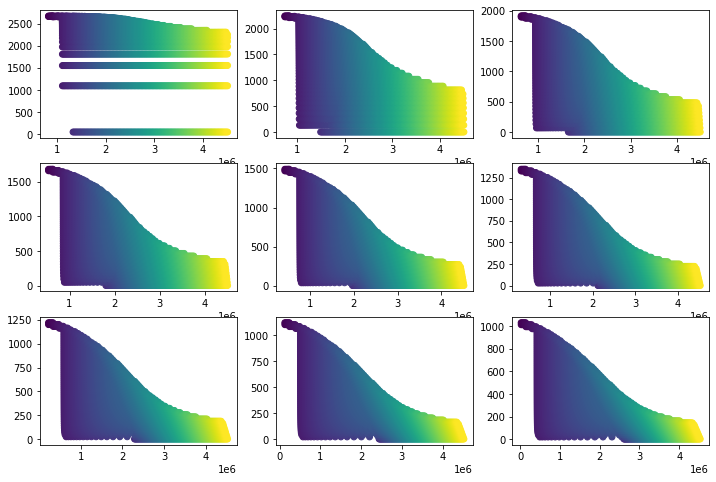

In [22]:
# Plot response surface
plt.figure(figsize=(12,8))
yw_sample_indices = np.linspace(0,mg_T.shape[0]-1,9).astype(int)

for i in range(9):
  plt.subplot(3,3,i+1)
  yw_ind = yw_sample_indices[i]
  plt.scatter(mg_vol_energy[yw_ind,...]/mg_rho_mix[yw_ind,...], mg_rho_mix[yw_ind,...], c=mg_T[yw_ind,...])
print("x: specific mixture energy")
print("y: mixture density")
print("color: temperature")

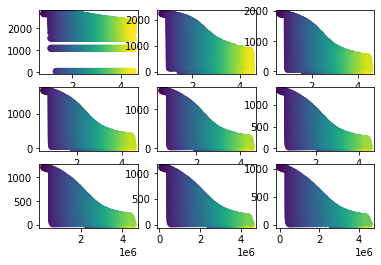

In [85]:
# Linear energy model

rho_w0 = 997.0
T_w0 = 300.0
p_w0 = float_phi_functions.p(rho_w0, T_w0)
e_w0 = float_phi_functions.u(rho_w0, T_w0)
c_v_w0 = float_phi_functions.c_v(rho_w0, T_w0)
# Set saturated vapour linearization point
T_gas_ref = 100+273.15
p_gas_ref = 101417.99665995548 # float_phi_functions.prho_sat(273.15+100)["psat"]
rho_gas_ref = 0.5981697919259701 # float_phi_functions.prho_sat(273.15+100)["rho_satv"] # 
e_gas_ref = 2506022.7123141396 # float_phi_functions.u(rho_gas_ref, 273.15+100)
c_v_gas_ref = 1555.8307465765565 # float_phi_functions.c_v(rho_gas_ref, 273.15+100)

def linear_T_est(yw, vol_energy, rho_mix):
  ym = 1.0 - yw
  if rho_mix < 10.0:
    # Due to an issue with flip-flopping for a low-density gas:
    T = ((vol_energy / rho_mix) - yw * (e_gas_ref - c_v_gas_ref * T_gas_ref)) \
    / (yw * c_v_gas_ref + ym * c_v_m0)
  else:
    # Estimate temperature
    T = ((vol_energy / rho_mix) - yw * (e_w0 - c_v_w0 * T_w0)) \
      / (yw * c_v_w0 + ym * c_v_m0)
  return T

linear_T_est(0.5, 3e6, 100)

mg_T_linear_est = np.empty_like(mg_T)
for i, j, k in np.ndindex(mg_yw.shape):
  mg_T_linear_est[i,j,k] = linear_T_est(
    mg_yw[i,j,k], mg_vol_energy[i,j,k], mg_rho_mix[i,j,k])

# for i in range(9):
#   plt.subplot(3,3,i+1)
#   yw_ind = yw_sample_indices[i]
#   plt.scatter(mg_vol_energy[yw_ind,...]/mg_rho_mix[yw_ind,...], mg_rho_mix[yw_ind,...], c=mg_T_linear_est[yw_ind,...])

x: specific mixture energy
y: mixture density
color: temperature


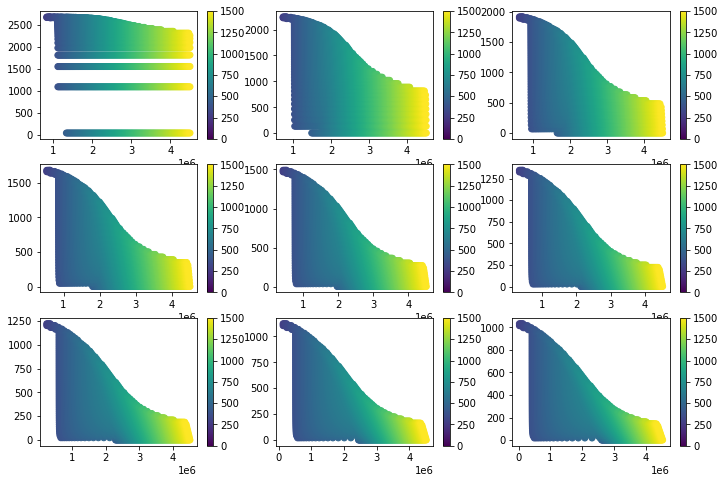

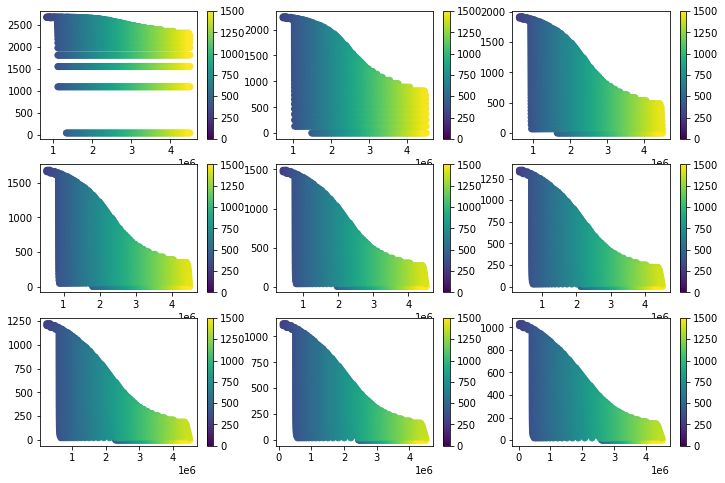

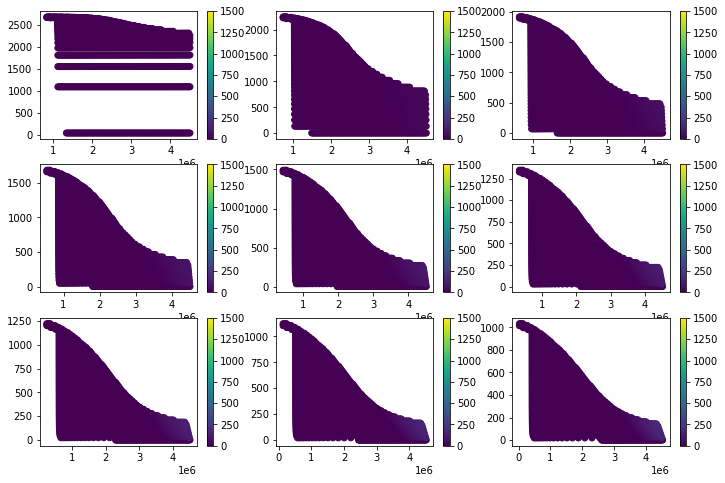

In [86]:
''' Plot exact and linear approx'''
yw_sample_indices = np.linspace(0,mg_T.shape[0]-1,9).astype(int)

plt.figure(figsize=(12,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  yw_ind = yw_sample_indices[i]
  plt.scatter(mg_vol_energy[yw_ind,...]/mg_rho_mix[yw_ind,...], mg_rho_mix[yw_ind,...], c=(mg_T)[yw_ind,...])
  plt.clim(0,1500)
  plt.colorbar()

plt.figure(figsize=(12,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  yw_ind = yw_sample_indices[i]
  plt.scatter(mg_vol_energy[yw_ind,...]/mg_rho_mix[yw_ind,...], mg_rho_mix[yw_ind,...], c=(mg_T_linear_est)[yw_ind,...])
  plt.clim(0,1500)
  plt.colorbar()
print("x: specific mixture energy")
print("y: mixture density")
print("color: temperature")


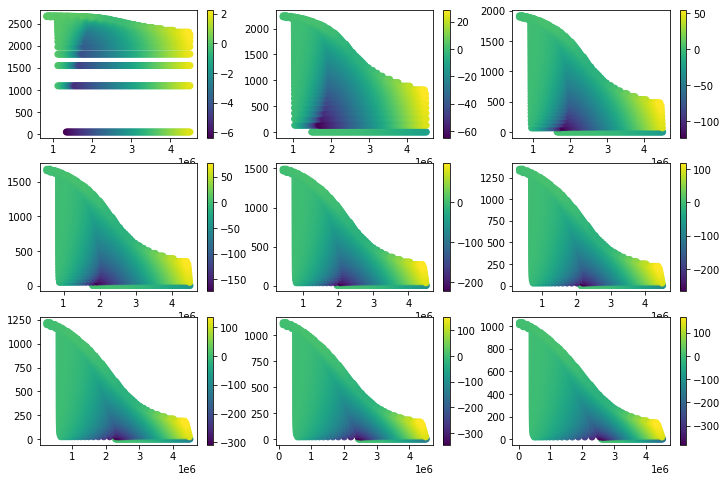

In [88]:
# Show residual
plt.figure(figsize=(12,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  yw_ind = yw_sample_indices[i]
  plt.scatter(mg_vol_energy[yw_ind,...]/mg_rho_mix[yw_ind,...], mg_rho_mix[yw_ind,...], c=(mg_T-mg_T_linear_est)[yw_ind,...])
  plt.colorbar()

In [114]:
''' Fit residual '''

# Filter indices
ind_isnotnan = np.where(~np.isnan(mg_vol_energy.ravel()))

y = (mg_T-mg_T_linear_est).ravel()[ind_isnotnan]
# Explanatory variables
x0 = mg_yw.ravel()[ind_isnotnan]
x1 = (mg_vol_energy/mg_rho_mix).ravel()[ind_isnotnan] / 1e6 
x2 = mg_rho_mix.ravel()[ind_isnotnan] / 1e3

# Regression matrix
A = np.vstack((np.ones_like(y), x0, x1, x2,
  x0*x0, x1*x1, x2*x2,
  x0*x1, x0*x2, x1*x2,
  x1*x1*x1, x1*x1*x1*x1)).T
# A = np.vstack((np.ones_like(y), x0, x1, x2)).T
lstsq_fit = scipy.linalg.lstsq(A , y)

In [143]:
''' Define Cython export for regression improvement for initial T guess. '''

static_regression_weights = [
  115.921763310165275, -316.916654834257770, 124.876068728982972,
  -111.538568414603972, 68.024491357232435, -211.349261918711562,
  12.208660020549521, 60.443940920122770, 183.657082274465807,
  37.811498814731365, 72.941538305957451, -7.341630723542266,]
def poly_T_residual_est(yw, vol_energy, rho_mix, weights):  
  ''' Estimate residual based on a posteriori regression. '''
  x0 = yw
  x1 = vol_energy/rho_mix / 1e6 
  x2 = rho_mix / 1e3
  return weights[0] + weights[1] * x0 + weights[2] * x1 + weights[3] * x2 \
    + weights[4]*x0*x0 + weights[5]*x1*x1 + weights[6]*x2*x2 + \
    + weights[7]*x0*x1 + weights[8]*x0*x2 + weights[9]*x1*x2 + \
    + weights[10]*x1*x1*x1 + weights[11]*x1*x1*x1*x1

def linear_T_est(yw, vol_energy, rho_mix):
  ym = 1.0 - yw
  if rho_mix < 10.0:
    # Due to an issue with flip-flopping for a low-density gas:
    T = ((vol_energy / rho_mix) - yw * (e_gas_ref - c_v_gas_ref * T_gas_ref)) \
    / (yw * c_v_gas_ref + ym * c_v_m0)
  else:
    # Estimate temperature
    T = ((vol_energy / rho_mix) - yw * (e_w0 - c_v_w0 * T_w0)) \
      / (yw * c_v_w0 + ym * c_v_m0)
  return T

# Test
yw_test, vol_energy_test, rho_mix_test = \
  mg_yw[60,45,15], mg_vol_energy[60,45,15], mg_rho_mix[60,45,15]
T_test = mg_T[60,45,15]
poly_T_residual_est(yw_test, vol_energy_test, rho_mix_test, static_regression_weights) \
  + linear_T_est(yw_test, vol_energy_test, rho_mix_test), \
  linear_T_est(yw_test, vol_energy_test, rho_mix_test), T_test


(710.8235359375296, 778.7750133791852, 705.5813953488373)

x: specific mixture energy
y: mixture density
color: temperature


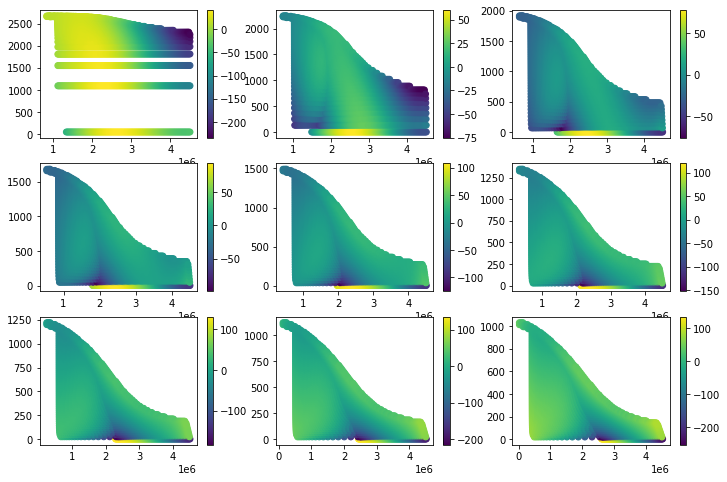

In [115]:
''' Visualize residual of regression model '''
mg_T_regr = np.nan * np.ones_like(mg_vol_energy)
mg_T_regr.ravel()[ind_isnotnan] = A @ lstsq_fit[0]

plt.figure(figsize=(12,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  yw_ind = yw_sample_indices[i]
  plt.scatter(mg_vol_energy[yw_ind,...]/mg_rho_mix[yw_ind,...],
    mg_rho_mix[yw_ind,...],
    c=(mg_T-(mg_T_linear_est+mg_T_regr))[yw_ind,...])
  plt.colorbar()
print("x: specific mixture energy")
print("y: mixture density")
print("color: temperature")

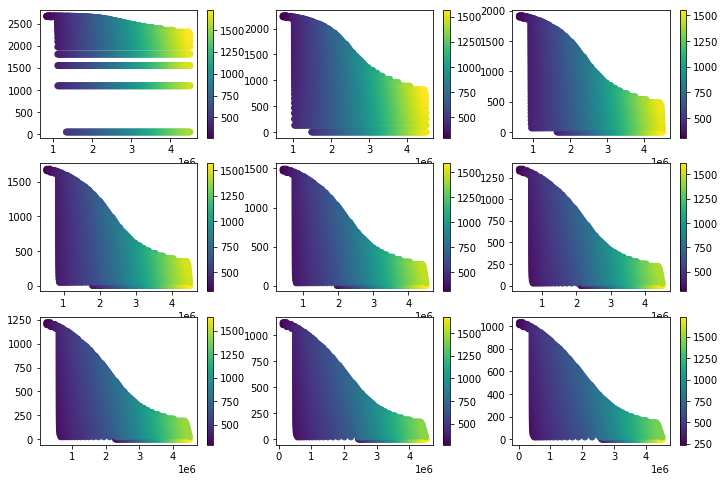

In [110]:
# Show regression-improved
plt.figure(figsize=(12,8))

for i in range(9):
  plt.subplot(3,3,i+1)
  yw_ind = yw_sample_indices[i]
  plt.scatter(mg_vol_energy[yw_ind,...]/mg_rho_mix[yw_ind,...],
    mg_rho_mix[yw_ind,...],
    c=(mg_T_linear_est+mg_T_regr)[yw_ind,...])
  plt.colorbar()

In [12]:
# Target largest error
i_target = np.nanargmax(np.abs(mg_p_calc / mg_p_target - 1.0).ravel())
yw, T, rhow = mg_yw.ravel()[i_target], mg_T.ravel()[i_target], \
  mg_rhow.ravel()[i_target]
yw, T, rhow, run_float_mix_function(yw, T, rhow)

(0.04991532258064516,
 620.4651162790698,
 729.8135593220339,
 (2.751116303158361e+185,
  69706494.9375855,
  0.002706900000021051,
  620.9300685783678))

## Feature development: mixture conservative to primitives

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light
import numpy as np

# Cython-backend imports
import float_phi_functions
import iapws95_light_perf

In [86]:
import mixtureWLM
backend = float_phi_functions

K = mixtureWLM.K
p_m0 = mixtureWLM.p_m0
rho_m0 = mixtureWLM.rho_m0
v_m0 = 1.0 / rho_m0
c_v_m0 = 3e3


In [185]:
# Compute energy at zero mechanical
u0 = p_m0 / (K - p_m0)
e_m0 = K / rho_m0 * (u0 - np.log(1 + u0)) - p_m0 / rho_m0 * u0
def magma_mech_energy(p):
  ''' Mechanical component of internal energy as integral -p dv.
  First term is -(p-p0)dv, and second is -p0 dv, third is shift'''
  u = (p_m0 - p)/(p + K - p_m0)
  return K / rho_m0 * (u - np.log(1 + u)) - p_m0 / rho_m0 * u - e_m0

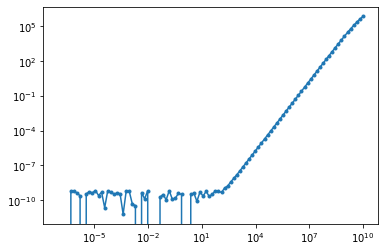

Text(0, 0.5, 'Isochoric heat capacity (J/kgK)')

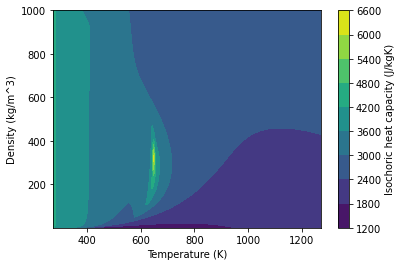

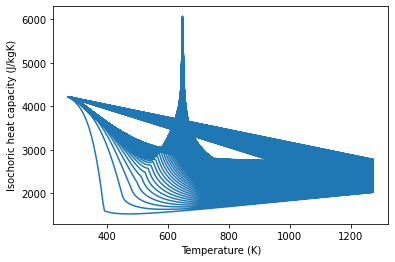

In [137]:
'''Test pressure function p(rho, T) (EOS)'''
rho_range = np.linspace(1, 1000, 256)
T_range = np.linspace(273.16, 1273, 196)
mg_T, mg_rho = np.meshgrid(T_range, rho_range)
mg_c_v = np.zeros_like(mg_T)
for i, j in np.ndindex(mg_c_v.shape):
  mg_c_v[i,j] = float_phi_functions.c_v(mg_rho[i,j], mg_T[i,j])

plt.contourf(mg_T, mg_rho, mg_c_v)
plt.xlabel("Temperature (K)")
plt.ylabel("Density (kg/m^3)")
plt.colorbar(label="Isochoric heat capacity (J/kgK)")
plt.figure()
plt.plot(mg_T.ravel(), mg_c_v.ravel())
plt.xlabel("Temperature (K)")
plt.ylabel("Isochoric heat capacity (J/kgK)")

In [285]:
# Generate synthetic input values
yw = 0.42
T = 700
rhow = 350
p_target = float_phi_functions.p(rhow, T)
rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
rho_mix = 1/(yw / rhow + (1 - yw) / rhom )
uw_target = float_phi_functions.u(rhow, T)
# TODO: add work energy
um_target = c_v_m0 * T + magma_mech_energy(p_target)
u_target = yw*uw_target + ym*um_target 
vol_energy = rho_mix * u_target
rho_target = rho_mix
T_target = T

# Show
uw_target, p_target, vol_energy, rho_target, T_target

(2166345.7816960355,
 38206404.46306721,
 1504755706.990417,
 707.1616401782727,
 700)

In [191]:
''' Estimate initial temperature '''
# Reference linearization values
rho_w0 = 997
T_w0 = 300
p_w0 = float_phi_functions.p(rho_w0, T_w0)
e_w0 = float_phi_functions.u(rho_w0, T_w0)
c_v_w0 = float_phi_functions.c_v(rho_w0, T_w0)
# Linear energy model
linear_en = lambda T: yw * (c_v_w0 * (T - T_w0) + e_w0) \
  + ym * (c_v_m0 * T)
# Estimate temperature
T_init = ((vol_energy / rho_mix) - yw * (e_w0 - c_v_w0 * T_w0)) / (yw * c_v_w0 + ym * c_v_m0)
linear_en(T_target), vol_energy/rho_mix, T_target, T_init


(1958561.4093521107, 2127880.8429301595, 700, 748.7487486702362)

In [192]:
''' Cold-start compute pressure, densities '''
# Initial guess
T = T_init
rhoc = iapws95_light.rhoc
d = None
d_init = 1.0
if T < iapws95_light.Tc:
  # Compute saturation properties
  sat_info = backend.prho_sat(T)
  psat, rhol, rhov = \
    float(sat_info["psat"]), sat_info["rho_satl"], sat_info["rho_satv"]
  # Compute dependent variables
  ym = 1.0 - yw
  v_mix = 1.0 / rho_mix
  # Compute tentative density value
  rhow = yw / (v_mix - ym * K / rho_m0 / (psat + K - p_m0))
  if rhov <= rhow and rhow <= rhol:
    # Accept tentative value
    d = rhow / rhoc
  elif rhow < rhov:
    # Vapour phase
    d_init = rhov / rhoc
  else:
    # Liquid phase
    d_init = rhol / rhoc
# Iteratively solve for water reduced volume d
if d is None:
  d, absstep = mixtureWLM._itersolve_d(rho_mix, yw, T, d_init=d_init)

p = float_phi_functions.p(d*iapws95_light.rhoc, T)
p, absstep, p_target

(53662568.229225, 3.795224462479116e-12, 38206404.46306721)

In [145]:
# Check volume condition
rho_mix_out = 1/(yw / (d * iapws95_light.rhoc) + (1 - yw) / (rho_m0 + (p - p_m0) / K))
rho_mix_out, rho_target

(706.2873058194795, 706.8064147069331)

In [149]:
''' Compute energy step '''
# Compute energy-temperature slope
t = iapws95_light.Tc/T
R = iapws95_light.R

# Compute phasic states
rhom = rho_m0 + (p - p_m0)/ K
rhow = d*rhoc

''' Cost-critical functions '''
# Compute phirs
_phir_all = float_phi_functions.fused_phir_all(d, iapws95_light.Tc/T)
_phi0_all = float_phi_functions.fused_phi0_all(d, iapws95_light.Tc/T)
# Compute heat capacity
c_v = float_phi_functions.c_v(rhow, T)

# Compute intermediates
_c1 = (v_mix * d - yw / rhoc)
# Compute compressibility, partial of compressibility
Z = (1.0 + d * _phir_all["phir_d"]) * d
Z_d = 1.0 + 2.0 * d * _phir_all["phir_d"] + d * d * _phir_all["phir_dd"]
# Compute derivatives of pressure equilibrium level set function
d1psi = v_mix * (Z * rhoc * R * T + K - p_m0) - K * ym / rho_m0 * d \
  + _c1 * (rhoc * R * T * Z_d) - K * ym / rho_m0
d2psi = _c1 * Z * d * rhoc * R
# Compute density-temperature slope under the volume addition constraint
drhowdT = -d2psi / d1psi
# Compute density-temperature slope for m state
drhomdT = -yw / ym * (rhom / rhow) * (rhom / rhow) * drhowdT
# Compute pressure-temperature slope under the volume addition constraint
dpdT = rhoc * R * (
  (2.0 * d + 2.0 * d * _phir_all["phir_d"] 
    + d * d * _phir_all["phir_dd"]) * drhowdT * T
  + d * d * (1.0 + _phir_all["phir_d"]))
# Compute water energy-temperature slope
dewdT = c_v \
  - iapws95_light.R * iapws95_light.Tc / iapws95_light.rhoc * \
    _phir_all["phir_dt"] * drhowdT

# Compute magma energy-temperature slope
demdT = c_v_m0 \
  + p / (rhom*rhom) * drhomdT

# Compute mixture energy-temperature slope
dedT = yw * dewdT + ym * demdT
dedT, c_v_m0, drhomdT, drhowdT, dpdT

(2913.630835343879,
 3000.0,
 8.005510572191716e-05,
 -1.8544805885867508e-06,
 85244.88824799545)

In [148]:
''' Check Newton step plausibility '''
# Newton step to zero energy mismatch
curr_rho = 1.0/(yw/rhow + ym/rhom)
curr_energy = yw * float_phi_functions.u(rhow, T) + ym * c_v_m0 * T

# Temperature migration
dT = -(curr_energy - vol_energy/rho_mix)/dedT
# Output
curr_rho*curr_energy, vol_energy, curr_rho*curr_energy - vol_energy, T, dT, T_target

(1605198955.1159852,
 1503988793.0029912,
 101210162.11299396,
 748.7442530664899,
 -49.71899563372013,
 700)

In [152]:
''' Update '''
# Update T
T += dT
# Reinitialization d
d_reinit = d + drhowdT/rhoc
d, absstep = mixtureWLM._itersolve_d(rho_mix, yw, T, d_init=d_reinit)
p = float_phi_functions.p(d*iapws95_light.rhoc, T)
p, absstep, p_target

In [885]:
''' Estimate initial temperature '''
# Simulate module-scope variables
R = iapws95_light.R
Tc = iapws95_light.Tc
rhoc = iapws95_light.rhoc
vc = 1.0/rhoc

# Compute linearization reference state of water
p_w0 = float_phi_functions.p(rho_w0, T_w0)
e_w0 = float_phi_functions.u(rho_w0, T_w0)
c_v_w0 = float_phi_functions.c_v(rho_w0, T_w0)
p_gas_ref = float_phi_functions.prho_sat(273.15+100)["psat"] # 101417.99665995548
rho_gas_ref = float_phi_functions.prho_sat(273.15+100)["rho_satv"] # 0.5981697919259701
T_gas_ref = 100+273.15
e_gas_ref = float_phi_functions.u(rho_gas_ref, 273.15+100)
c_v_gas_ref = float_phi_functions.c_v(rho_gas_ref, 273.15+100)

def pure_phase_newton_pair(d, T, rho_mix, R, yw, K, p_m0, rho_m0) -> float:
  # Compute coefficients
  t = Tc / T
  a = rhoc / rho_mix
  b = -yw
  c2 = a
  c1 = (1.0 / rho_mix * (K - p_m0) - K * (1.0 - yw) / rho_m0)/(R * T) - yw
  c0 = -yw / (rhoc * R * T) * (K - p_m0)
  ''' Return value of scaled pressure difference and slope '''
  # out = backend.fused_phir_d3(d, t)
  # phir_d, phir_dd, phir_ddd = out["phir_d"], out["phir_dd"], out["phir_ddd"]
  out = float_phi_functions.fused_phir_d_phir_dd(d,t)
  phir_d, phir_dd = out["first"], out["second"]
  val = (a*d + b)*d*d*phir_d + ((a * d) + c1)*d + c0
  slope = (3*a*d + 2*b)*d*phir_d \
    + (a*d + b)*d*d*phir_dd \
    + 2*a*d + c1
  return val, slope

def c2p(vol_energy, rho_mix, yw):
  ''' Map conservative mixture variables to pressure, temperature. '''
  iteration_path = []

  # Evaluate dependent variables
  ym = 1.0 - yw
  v_mix = 1.0/rho_mix

  # Define reference linearization values
  rho_w0 = 997
  T_w0 = 300
  
  # Define linear energy model
  linear_en = lambda T: yw * (c_v_w0 * (T - T_w0) + e_w0) \
    + ym * (c_v_m0 * T)
  # Due to an issue with flip-flopping for a low-density gas:
  if rho_mix < 10.0:
    T = ((vol_energy / rho_mix) - yw * (e_gas_ref - c_v_gas_ref * T_gas_ref)) \
    / (yw * c_v_gas_ref + ym * c_v_m0)
  else:
    # Estimate temperature
    T = ((vol_energy / rho_mix) - yw * (e_w0 - c_v_w0 * T_w0)) \
      / (yw * c_v_w0 + ym * c_v_m0)

  ''' Critical quantification: critical or not? '''
  # One-step Newton approximation of critical-temperature value
  d = 1.0
  val, slope = pure_phase_newton_pair(d, Tc, rho_mix, R, yw, K, p_m0, rho_m0)
  d -= val/slope
  # Quantify approximately supercriticality
  is_supercritical = yw * float_phi_functions.u(d*rhoc, Tc) \
    + ym * (c_v_m0 * Tc) < vol_energy/rho_mix
  # Clip initial temperature guess from linear energy
  if is_supercritical and T < Tc + 1.0:
    T = Tc + 1.0
  elif not is_supercritical and T > Tc - 1.0:
    T = Tc - 1.0

  # print(f"Supercritical?: {is_supercritical}")
  # print(f"Initial T = {T}")

  ''' Cold-start compute pressure, densities '''
  if not is_supercritical:
    # Compute saturation properties
    sat_info = float_phi_functions.prho_sat(T)
    psat, rhol, rhov = sat_info["psat"], sat_info["rho_satl"], sat_info["rho_satv"]
    # Compute tentative density value
    rhow = yw / (v_mix - ym * K / rho_m0 / (psat + K - p_m0))
    if rhov <= rhow and rhow <= rhol:
      # Accept tentative mixed-phase value of density
      d = rhow / rhoc
      # Compute pressure from sat vapor side
      p = psat
      start_case = "start-LV"
    else:
      # Select pure vapor or pure liquid phase density
      d = rhov/rhoc if rhow < rhov else rhol/rhoc
      # Refine estimate of d from one Newton iteration
      val, slope = pure_phase_newton_pair(d, T, rho_mix, R, yw, K, p_m0, rho_m0)
      d -= val/slope
      # Compute pressure
      p = float_phi_functions.p(d*rhoc, T)
      start_case = "start-subcrit"
  else:
    # Refine estimate of d from one Newton iteration
    val, slope = pure_phase_newton_pair(d, T, rho_mix, R, yw, K, p_m0, rho_m0)
    d -= val/slope
    # Compute pressure from
    p = float_phi_functions.p(d*rhoc, T)
    start_case = "start-supercrit"

  # Clip temperatures below the triple point temperature
  if T < 273.16:
    T = 273.16
    
  # print(f"Start case is {start_case}")
  iteration_path.append((p, d*rhoc, T, start_case))

  ''' Perform iteration for total energy condition '''
  for i in range(64):
    t = Tc/T
    is_mixed = False
    # Set default case string
    case_str = "iter-supercrit"
    
    if T < Tc:
      # Check saturation curves TODO: use fused op
      sat_info = float_phi_functions.prho_sat(T)
      psat, rhol, rhov = sat_info["psat"], \
        sat_info["rho_satl"], sat_info["rho_satv"]
      # Compute volume-sum constrained density value if pm = psat
      rhow = yw / (v_mix - ym * K / rho_m0 / (psat + K - p_m0))
      # iteration_path.append((psat, rhow, T, "interm"))
      # d = rhow/rhoc
      if rhov <= rhow and rhow <= rhol:
        is_mixed = True
        p = psat
        # Accept tentative mixed-phase value of density
        d = rhow / rhoc
        # Compute steam fraction (fraction vapor mass per total water mass)
        x = (1.0 / rhow - 1.0 / rhol) / (1.0 / rhov - 1.0 / rhol)
        # Compute temperature update using saturation relation
        # _phir_all_v = float_phi_functions.fused_phir_all(rhov/rhoc, iapws95_light.Tc/T)
        # _phir_all_l = float_phi_functions.fused_phir_all(rhol/rhoc, iapws95_light.Tc/T)
        d0 = rhol/rhoc
        d1 = rhov/rhoc
        _phirall_0 = float_phi_functions.fused_phir_all(d0, Tc/T)
        _phirall_1 = float_phi_functions.fused_phir_all(d1, Tc/T)
        _phi0all_0 = float_phi_functions.fused_phi0_all(d0, Tc/T)
        _phi0all_1 = float_phi_functions.fused_phi0_all(d1, Tc/T)
        # float_phi_functions.prho_sat(500)

        ''' Derivatives along Maxwell-construction level set G(t, d0, d1) = 0 '''
        # Vector components of partial dG/dt = (dG0/dt; dG1/dt)
        dG0dt = d1*_phirall_1["phir_dt"] + _phirall_1["phir_t"] + _phi0all_1["phi0_t"] \
          - d0*_phirall_0["phir_dt"] - _phirall_0["phir_t"] - _phi0all_0["phi0_t"]
        dG1dt = d0*d0*_phirall_0["phir_dt"] - d1*d1*_phirall_1["phir_dt"]
        # Vector components of partial dG/d0
        dG0dd0 = -2.0*_phirall_0["phir_d"] - d0*_phirall_0["phir_dd"] - _phi0all_0["phi0_d"]
        dG1dd0 = 1.0 + 2.0 * d0 * _phirall_0["phir_d"] + d0*d0*_phirall_0["phir_dd"]
        # Vector components of partial dG/d1
        dG0dd1 = 2.0*_phirall_1["phir_d"] + d1*_phirall_1["phir_dd"] + _phi0all_1["phi0_d"]
        dG1dd1 = -1.0 - 2.0 * d1 * _phirall_1["phir_d"] - d1*d1*_phirall_1["phir_dd"]
        # Compute d(d0)/dt and d(d1)/dt constrainted to level set of G
        _det = dG0dd0 * dG1dd1 - dG0dd1 * dG1dd0
        dd0dt = -(dG1dd1 * dG0dt - dG0dd1 * dG1dt) / _det
        dd1dt = -(-dG1dd0 * dG0dt + dG0dd0 * dG1dt) / _det

        # Construct derivatives of volume:
        #   dv0/dt = partial(v0, t) + partial(v0, d) * dd0/dt
        #   dv0/dT = dv0/dt * dt/dT
        dv0dT = -1.0/(rhoc * d0 * d0) * dd0dt * (-Tc/(T*T))
        dv1dT = -1.0/(rhoc * d1 * d1) * dd1dt * (-Tc/(T*T))
        # Construct derivatives of internal energy
        du0dT = R * Tc * (
          (_phirall_0["phir_dt"] + _phi0all_0["phi0_dt"]) * dd0dt
          + (_phirall_0["phir_tt"] + _phi0all_0["phi0_tt"])
        ) * (-Tc/(T*T))
        du1dT = R * Tc * (
          (_phirall_1["phir_dt"] + _phi0all_1["phi0_dt"]) * dd1dt
          + (_phirall_1["phir_tt"] + _phi0all_1["phi0_tt"])
        ) * (-Tc/(T*T))

        # Construct dx/dT (change in steam fraction subject to mixture
        #   conditions) as partial(x, T) + partial(x, v) * dv/dT
        v = 1.0/(d*rhoc)
        vl = 1.0/(d0*rhoc)
        vv = 1.0/(d1*rhoc)
        partial_dxdT = ((v - vv) * dv0dT - (v - vl) * dv1dT) \
          / ((vv - vl) * (vv - vl))
        partial_dxdv =  1.0 / (vv - vl) # add partial (x, v)
        dvdp = (1.0 - yw) / yw * K / rho_m0 / (
          (psat + K - p_m0)*(psat + K - p_m0))
        # Compute saturation-pressure-temperature slope
        dpsatdT = rhov * rhol / (rhov - rhol) \
          * R * (np.log(rhov / rhol) + _phirall_1["phir"] - _phirall_0["phir"] \
            - t * (_phirall_1["phir_t"] - _phirall_0["phir_t"]))
        dxdT = partial_dxdT + partial_dxdv * dvdp * dpsatdT

        # Construct de/dT for water:
        #   de/dT = partial(e,x) * dx/dT + de/dT
        uv = R * Tc * (_phirall_1["phir_t"] + _phi0all_1["phi0_t"])
        ul = R * Tc * (_phirall_0["phir_t"] + _phi0all_0["phi0_t"])
        dewdT = (uv - ul) * dxdT + x*du1dT + (1.0-x)*du0dT

        # Construct de/dT for mixture, neglecting pdv work of magma
        dedT = yw * dewdT + ym * c_v_m0

        ''' Compute Newton step for temperature '''
        curr_energy = yw * float_phi_functions.u(rhow, T) \
          + ym * (c_v_m0 * T + magma_mech_energy(psat))
        # Temperature migration
        # dT = -(curr_energy - vol_energy/rho_mix)/dedT
        trust_region_size = 1e8
        # HACK:
        if rho_mix < 10: # Size limiter for sparse gas
          trust_region_size = 1e2
        dT = -(curr_energy - vol_energy/rho_mix)/(dedT + 1e6/trust_region_size)

        ''' Estimate saturation state in destination temperature '''
        # x_pred = x + dxdT * dT
        # print(x_pred)
        # print((uv - ul) * dxdT,x*du1dT + (1.0-x)*du0dT )

        # Vapor-boundary overshooting correction
        dvdT = (vv - vl) * dxdT + x*dv1dT + (1.0-x)*dv0dT
        dT_to_v_bdry = (vv - v) / (dvdT - dv1dT)
        if dT > 0 and dT_to_v_bdry > 0 and dT > dT_to_v_bdry:
          dT = 0.5 * (dT + dT_to_v_bdry)
        # print(dT)

        # Newton-step temperature
        T += dT

        
        # Compute saturation-pressure-temperature slope
        # dpdT = rhov * rhol / (rhov - rhol) \
        #   * R * (np.log(rhov / rhol) + _phir_all_v["phir"] - _phir_all_l["phir"] \
        #     - t * (_phir_all_v["phir_t"] - _phir_all_l["phir_t"]))
        # # Directly use pressure mismatch as solution target
        # rhom = ym / (1.0 / rho_mix - yw / rhow)
        # pm = p_m0 + K * (rhom - rho_m0) / rho_m0
        # pw = p
        # T += (pm - pw) /dpdT
        # is_mixed = True
        case_str = "iter-LV"
      else:
        # Annotate subcritical but pure-phase case
        case_str = "iter-subcrit"
    
    if not is_mixed:
      # Compute phasic states using current T and previous iteration d
      rhow = d*rhoc
      rhom = ym / (1.0 / rho_mix - yw / rhow)
      ''' Call cost-critical functions '''
      _phir_all = float_phi_functions.fused_phir_all(d, iapws95_light.Tc/T)
      # Compute heat capacity TODO: we have the info needed.
      c_v = float_phi_functions.c_v(rhow, T)

      ''' Compute slopes '''
      # Compute intermediates
      _c1 = (v_mix * d - yw / rhoc)
      # Compute compressibility, partial of compressibility
      Z = (1.0 + d * _phir_all["phir_d"]) * d
      Z_d = 1.0 + 2.0 * d * _phir_all["phir_d"] + d * d * _phir_all["phir_dd"]
      # Compute derivatives of pressure equilibrium level set function
      d1psi = v_mix * (Z * rhoc * R * T + K - p_m0) - K * ym / rho_m0 * d \
        + _c1 * (rhoc * R * T * Z_d) - K * ym / rho_m0
      d2psi = _c1 * Z * d * rhoc * R
      # Compute density-temperature slope under the volume addition constraint
      drhowdT = -d2psi / d1psi
      # Compute density-temperature slope for m state
      drhomdT = -yw / ym * (rhom / rhow) * (rhom / rhow) * drhowdT
      # Compute pressure-temperature slope under the volume addition constraint
      # dpdT = rhoc * R * (
      #   (2.0 * d + 2.0 * d * _phir_all["phir_d"] 
      #     + d * d * _phir_all["phir_dd"]) * drhowdT * T
        # + d * d * (1.0 + _phir_all["phir_d"]))
      # Compute water energy-temperature slope
      dewdT = c_v \
        - iapws95_light.R * iapws95_light.Tc / iapws95_light.rhoc * \
          _phir_all["phir_dt"] * drhowdT
      # Compute magma energy-temperature slope
      demdT = c_v_m0 \
        + p / (rhom*rhom) * drhomdT
      # Compute mixture energy-temperature slope
      dedT = yw * dewdT + ym * demdT

      ''' Compute Newton step for temperature '''
      curr_energy = yw * float_phi_functions.u(rhow, T) \
        + ym * (c_v_m0 * T + magma_mech_energy(p))
      # Temperature migration
      dT = -(curr_energy - vol_energy/rho_mix)/dedT
      # Penalize large steps (trust region)
      trust_region_size = 1e8
      dT = -(curr_energy - vol_energy/rho_mix)/(dedT + 1e6/trust_region_size)
      if np.abs(dT) > 100:
        dT *= 100/np.abs(dT)

      # Extrapolation cut
      # if case_str == "iter-subcrit":

      # if dT*dT > trust_region_size*trust_region_size:
        # dT = trust_region_size*np.sign(dT)
      # Newton-step temperature
      T += dT
      # Newton-step d (cross term in Jacobian)
      d += drhowdT/rhoc
      val, slope = pure_phase_newton_pair(d, T, rho_mix, R, yw, K, p_m0, rho_m0)
      d -= val/slope
      # Update pressure
      p = float_phi_functions.p(d*iapws95_light.rhoc, T)
      # Update water phasic density
      rhow = d * rhoc
    
    # Clip temperatures below the triple point temperature
    if T < 273.16:
      T = 273.16

    # Append output
    iteration_path.append((p, d*rhoc, T, case_str))

    if dT * dT < 1e-9 * 1e-9:
      break

    # Legacy debug
    # d, absstep = mixtureWLM._itersolve_d(rho_mix, yw, T, d_init=d_reinit)
    # print(yw / (rhoc * d) + ym / rhom, 1/rho_mix, val)
    # print()
    # print(Z * rhow * R * T - K/rho_m0 * rhom + K - p_m0)
    # print(rhom)
    # print(ym / rhom + yw / rhow, 1/rho_mix)
    # print(p, p_m0 + K / rho_m0 * (rhom - rho_m0), val,
    #   (v_mix*d - yw / rhoc)*(p - (p_m0 + K / rho_m0 * (rhom - rho_m0))),
    #   (1 + d*phir_d) * d * rhoc * R * T - K/rho_m0 * ym / (v_mix - yw / (d * rhoc)) + K - p_m0,
    #   - K/rho_m0 * ym / (v_mix - yw / (d * rhoc)) + K - p_m0)
    # print(f"Spec energy: {yw * float_phi_functions.u(rhow, T) + ym * (c_v_m0 * T + magma_mech_energy(p))}, {vol_energy/rho_mix}")
    # print(f"Spec vol: {yw /rhow + ym / rhom}, {1.0/rho_mix}")
    # print(f"Pressure: {p} and {p_m0 + K / rho_m0 * (rhom - rho_m0)}, {p_target}")

  return iteration_path

In [374]:
# Generate synthetic input values
yw = 0.42
T = 500 #700
rhow = 400 #350
# Compute dependent quantities
p_target = float_phi_functions.p(rhow, T)
rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
rho_mix = 1.0/(yw / rhow + (1 - yw) / rhom )
uw_target = float_phi_functions.u(rhow, T)
um_target = c_v_m0 * T + magma_mech_energy(p_target)
u_target = yw*uw_target + ym*um_target 
vol_energy = rho_mix * u_target
rho_target = rho_mix
T_target = T

# Show 
c2p(vol_energy,rho_mix,yw), (p_target, rhow, T_target)


Supercritical?: False


([(3031824.2453602017, 399.99999999999994, 507.5890841600934),
  (3031824.2453602017, 399.99999999999994, 500.38888436385304),
  (2658307.496610522, 399.99999999999994, 500.0010790505706),
  (2639248.7544734133, 399.99999999999994, 500.0000000082534),
  (2639195.872166339, 399.99999999999994, 499.99999999992053),
  (2639195.871757951, 399.99999999999994, 499.99999999992076)],
 (2639195.8717618757, 400, 500))

In [907]:
from time import perf_counter
import scipy.optimize
def run_rhow(yw, T, rhow):
  ''' Run manager with rhow as 3rd input '''
  # Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return np.nan * np.array([0,0,0]), 0.0, None, None, None
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rho_mix = 1.0/(yw / rhow + (1 - yw) / rhom )
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T + magma_mech_energy(p_target)
  u_target = yw*uw_target + (1-yw)*um_target 
  vol_energy = rho_mix * u_target
  rho_target = rho_mix
  T_target = T
  # Run with timer
  t1 = perf_counter()
  run_result = c2p(vol_energy,rho_mix,yw)
  t2 = perf_counter()
  abs_errs = np.array(run_result[-1][0:3]) - np.array([p_target, rhow, T_target])
  rel_err_p = np.abs(run_result[-1][0] / p_target - 1)
  target_params = {
    "T_target": T,
    "p_target": p_target,
    "u_target": u_target,
    "rho_mix": rho_mix,
    "rhom": rhom,
    "vol_energy": vol_energy,
  }
  return abs_errs, t2-t1, run_result, target_params, rel_err_p

def run(yw, T, p):
  ''' Run manager with pressure as 3rd input '''
  # Compute dependent quantities
  p_target = p
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rhow = scipy.optimize.fsolve(lambda rhow: float_phi_functions.p(rhow, T) - p, rhoc)[0]
  rho_mix = 1.0/(yw / rhow + (1 - yw) / rhom )
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T + magma_mech_energy(p_target)
  u_target = yw*uw_target + (1-yw)*um_target
  vol_energy = rho_mix * u_target
  rho_target = rho_mix
  T_target = T
  # Run with timer
  t1 = perf_counter()
  run_result = c2p(vol_energy,rho_mix,yw)
  t2 = perf_counter()
  abs_errs = np.array(run_result[-1][0:3]) - np.array([p_target, rhow, T_target])

  return abs_errs, t2-t1, run_result, [p_target, rhow, T_target]

v_yw = np.linspace(0.01, 0.9999, 125)
v_T = np.linspace(280, 1500, 130)
# v_p = np.linspace(1e5, 100e6, 20)
v_rhow = np.linspace(0.5, 1050, 60)

mg_yw, mg_T, mg_rhow = np.meshgrid(v_yw, v_T, v_rhow, indexing="ij")
# mg_yw, mg_T, mg_p = np.meshgrid(v_yw, v_T, v_p, indexing="ij")

In [908]:
mg_abs_errs = np.empty((3,*mg_yw.shape))
mg_wallt = np.empty_like(mg_yw)
mg_relp = np.empty_like(mg_yw)

for i, j, k in np.ndindex(mg_yw.shape):
  mg_abs_errs[:,i,j,k], mg_wallt[i,j,k], _, _, mg_relp[i,j,k] = run_rhow(
    mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k])

In [525]:
''' Development: saturation curve chain rule '''
d = 0.87
d0, d1 = 2.0, 0.5
x = (1.0/d - 1.0/d0) / (1.0/d1 - 1.0/d0)
_phirall_0 = float_phi_functions.fused_phir_all(d0, t)
_phirall_1 = float_phi_functions.fused_phir_all(d1, t)
_phi0all_0 = float_phi_functions.fused_phi0_all(d0, t)
_phi0all_1 = float_phi_functions.fused_phi0_all(d1, t)
# float_phi_functions.prho_sat(500)

''' Derivatives along Maxwell-construction level set G(t, d0, d1) = 0 '''
# Vector components of partial dG/dt = (dG0/dt; dG1/dt)
dG0dt = d1*_phirall_1["phir_dt"] + _phirall_1["phir_t"] + _phi0all_1["phi0_t"] \
  - d0*_phirall_0["phir_dt"] - _phirall_0["phir_t"] - _phi0all_0["phi0_t"]
dG1dt = d0*d0*_phirall_0["phir_dt"] - d1*d1*_phirall_1["phir_dt"]
# Vector components of partial dG/d0
dG0dd0 = -2.0*_phirall_0["phir_d"] - d0*_phirall_0["phir_dd"] - _phi0all_0["phi0_d"]
dG1dd0 = 1.0 + 2.0 * d0 * _phirall_0["phir_d"] + d0*d0*_phirall_0["phir_dd"]
# Vector components of partial dG/d1
dG0dd1 = 2.0*_phirall_1["phir_d"] + d1*_phirall_1["phir_dd"] + _phi0all_1["phi0_d"]
dG1dd1 = -1.0 - 2.0 * d1 * _phirall_1["phir_d"] - d1*d1*_phirall_1["phir_dd"]
# Compute d(d0)/dt and d(d1)/dt constrainted to level set of G
_det = dG0dd0 * dG1dd1 - dG0dd1 * dG1dd0
dd0dt = -(dG1dd1 * dG0dt - dG0dd1 * dG1dt) / _det
dd1dt = -(-dG1dd0 * dG0dt + dG0dd0 * dG1dt) / _det

# Construct derivatives of volume:
#   dv0/dt = partial(v0, t) + partial(v0, d) * dd0/dt
#   dv0/dT = dv0/dt * dt/dT
dv0dT = -1.0/(rhoc * d0 * d0) * dd0dt * (-Tc/(T*T))
dv1dT = -1.0/(rhoc * d1 * d1) * dd1dt * (-Tc/(T*T))
# Construct derivatives of internal energy
du0dT = R * Tc * (
  (_phirall_0["phir_dt"] + _phi0all_0["phi0_dt"]) * dd0dt
  + (_phirall_0["phir_tt"] + _phi0all_0["phi0_tt"])
) * (-Tc/(T*T))
du1dT = R * Tc * (
  (_phirall_1["phir_dt"] + _phi0all_1["phi0_dt"]) * dd1dt
  + (_phirall_1["phir_tt"] + _phi0all_1["phi0_tt"])
) * (-Tc/(T*T))

# Construct dx/dT (change in steam fraction subject to mixture conditions)
v = 1.0/(d*rhoc)
vl = 1.0/(d0*rhoc)
vv = 1.0/(d1*rhoc)
dxdT = ((v - vv) * dv0dT - (v - vl) * dv1dT) / ((vv - vl) * (vv - vl))

# Construct de/dT for water:
#   de/dT = partial(e,x) * dx/dT + de/dT
uv = R * Tc * (_phirall_1["phir_t"] + _phi0all_1["phi0_t"])
ul = R * Tc * (_phirall_0["phir_t"] + _phi0all_0["phi0_t"])
dewdT = (uv - ul) * dxdT + x*du1dT + (1.0-x)*du0dT

# Construct de/dT for mixture
dedT = yw * dewdT + ym * c_v_m0

dv0dT, dv1dT, du0dT, du1dT, dxdT, x, dedT

(1.9882901110552057e-06,
 -4.717515497927001e-05,
 4087.0934161471023,
 166.19906935305,
 0.004142429720417042,
 0.43295019157088116,
 3739.9299531360693)

In [556]:
# Compute dependent quantities
yw = 0.4
T = 600
rhow = 200
p_target = float_phi_functions.p(rhow, T)
rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
rho_mix = 1.0/(yw / rhow + (1 - yw) / rhom )
uw_target = float_phi_functions.u(rhow, T)
um_target = c_v_m0 * T + magma_mech_energy(p_target)
u_target = yw*uw_target + (1-yw)*um_target 
vol_energy = rho_mix * u_target
rho_target = rho_mix
T_target = T
# Run with timer
t1 = perf_counter()
run_result = c2p(vol_energy,rho_mix,yw)

Supercritical?: False
0.4 199.97904127426958 0.0022220591236961763 0.6 10000000000.0 2700.0 21800025.456282593 10000000000.0 5000000.0
0.4 207.13612428476299 0.0022220591236961763 0.6 10000000000.0 2700.0 8070254.709012852 10000000000.0 5000000.0
0.4 200.07051915295327 0.0022220591236961763 0.6 10000000000.0 2700.0 12156345.961083295 10000000000.0 5000000.0
0.4 200.0585332292123 0.0022220591236961763 0.6 10000000000.0 2700.0 12344523.875622455 10000000000.0 5000000.0
0.4 200.05851572491326 0.0022220591236961763 0.6 10000000000.0 2700.0 12344824.388202341 10000000000.0 5000000.0
0.4 200.05851572669954 0.0022220591236961763 0.6 10000000000.0 2700.0 12344824.357182918 10000000000.0 5000000.0
0.4 200.05851572669926 0.0022220591236961763 0.6 10000000000.0 2700.0 12344824.357186105 10000000000.0 5000000.0
0.4 200.05851572669926 0.0022220591236961763 0.6 10000000000.0 2700.0 12344824.357186105 10000000000.0 5000000.0


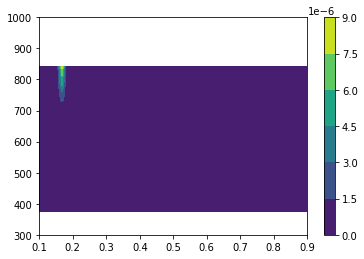

In [589]:
i = 10
# plt.scatter(mg_yw[...,i].ravel(), mg_T[...,i].ravel(), c=np.linalg.norm(mg_abs_errs,axis=0)[...,i].ravel())
plt.contourf(mg_yw[...,i], mg_T[...,i], np.linalg.norm(mg_abs_errs,axis=0)[...,i])
plt.colorbar()

In [ ]:
mg_wallt

<Figure size 432x288 with 0 Axes>

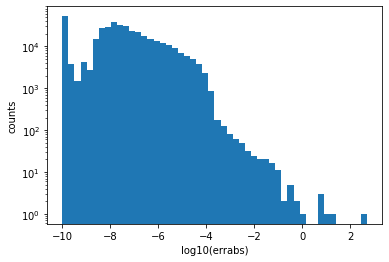

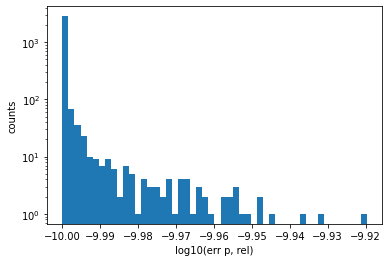

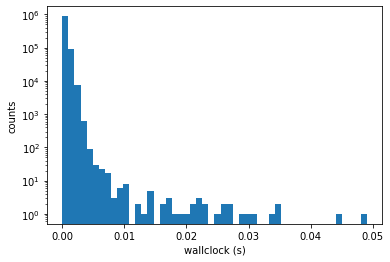

<Figure size 432x288 with 0 Axes>

In [909]:
''' Pressure error histogram '''
plt.hist(np.log10(1e-10+np.abs(mg_abs_errs[0,...])).ravel(), log=True, bins=50)
plt.xlabel("log10(errabs)")
plt.ylabel("counts")
plt.figure()
plt.hist(np.log10(1e-10+np.abs(mg_relp[0,...])).ravel(), log=True, bins=50)
plt.xlabel("log10(err p, rel)")
plt.ylabel("counts")
plt.figure()
plt.hist(mg_wallt.ravel(), log=True, bins=50)
plt.xlabel("wallclock (s)")
plt.ylabel("counts")
plt.figure()

In [898]:
np.nanmax(np.abs(mg_wallt[...]))

0.027013300001272

In [906]:
# Target largest error
i_target = np.nanargmax(np.abs(mg_abs_errs[0,...]))
# i_target = np.nanargmax(np.abs(mg_wallt[...]))

yw, T, rhow = mg_yw.ravel()[i_target], mg_T.ravel()[i_target], \
  mg_rhow.ravel()[i_target]
yw,T,rhow,run_rhow(yw, T, rhow)

(0.001,
 440.77519379844966,
 943.271186440678,
 (array([ 3.26804329e+91, -2.72983892e+03,  6.57401886e-03]),
  0.013932300003943965,
  [(7.503843000272775e+18, -848.9159174867773, 648.096, 'start-supercrit'),
   (1.0883574290004285e+18,
    -835.6638347117288,
    678.1165386150478,
    'iter-supercrit'),
   (1.5902231178937046e+17,
    -822.059789246188,
    709.9008511853668,
    'iter-supercrit'),
   (2.344431836996827e+16,
    -808.0766258154748,
    743.6981680649051,
    'iter-supercrit'),
   (3498978054162660.5,
    -793.6841090829018,
    779.7445016067254,
    'iter-supercrit'),
   (536232349296821.4, -778.8497811382632, 817.812389675443, 'iter-supercrit'),
   (90870571515252.97,
    -763.5418880688856,
    854.6372842689598,
    'iter-supercrit'),
   (23852353545788.168,
    -747.7422431583263,
    872.6969087703442,
    'iter-supercrit'),
   (20714136967252.215,
    -731.4822816093413,
    833.7835595691316,
    'iter-supercrit'),
   (18317800319583.574,
    -714.7355026786

(0.15925925925925927,
 691.5254237288136,
 125.875,
 (array([-2.23517418e-08, -4.26325641e-14,  1.13686838e-13]),
  0.0014161999861244112,
  [(28415612.97508906,
    125.8621442946812,
    734.8066777040676,
    'start-supercrit'),
   (24219092.174920864,
    125.8750882848874,
    691.2373924061955,
    'iter-supercrit'),
   (24247699.41468275,
    125.87499999951652,
    691.5254253067849,
    'iter-supercrit'),
   (24247699.257984675,
    125.87500000000001,
    691.5254237287062,
    'iter-supercrit'),
   (24247699.25799531,
    125.87499999999996,
    691.5254237288137,
    'iter-supercrit')],
  {'T_target': 691.5254237288136,
   'p_target': 24247699.257995334,
   'u_target': 2157034.980686876,
   'rho_mix': 634.515827211312,
   'rhom': 2705.196878799659,
   'vol_energy': 1368672835.0942695},
  8.881784197001252e-16))

In [883]:
# subcrit - LV oscillation path

# Point 1
rhow = 1.0000000030474223
T = 449.7543668899269
# Evaluate dT
float_phi_functions.prho_sat(T)

inputs = {'T_target': 383.0508474576271,
   'p_target': 142901.81817246985,
   'u_target': 1786821.8712870013,
   'rho_mix': 1.5786087108358478,
   'rhom': 2698.6885834909067,
   'vol_energy': 2820692.57072567}
rho_mix = inputs["rho_mix"]
vol_energy = inputs["vol_energy"]

def slope_field(rhow, T):
  d = rhow/rhoc
  rhom = ym / (1.0 / rho_mix - yw / rhow)
  ''' Call cost-critical functions '''
  _phir_all = float_phi_functions.fused_phir_all(d, iapws95_light.Tc/T)
  # Compute heat capacity TODO: we have the info needed.
  c_v = float_phi_functions.c_v(rhow, T)

  ''' Compute slopes '''
  # Compute intermediates
  _c1 = (v_mix * d - yw / rhoc)
  # Compute compressibility, partial of compressibility
  Z = (1.0 + d * _phir_all["phir_d"]) * d
  Z_d = 1.0 + 2.0 * d * _phir_all["phir_d"] + d * d * _phir_all["phir_dd"]
  # Compute derivatives of pressure equilibrium level set function
  d1psi = v_mix * (Z * rhoc * R * T + K - p_m0) - K * ym / rho_m0 * d \
    + _c1 * (rhoc * R * T * Z_d) - K * ym / rho_m0
  d2psi = _c1 * Z * d * rhoc * R
  # Compute density-temperature slope under the volume addition constraint
  drhowdT = -d2psi / d1psi
  # Compute density-temperature slope for m state
  drhomdT = -yw / ym * (rhom / rhow) * (rhom / rhow) * drhowdT
  # Compute pressure-temperature slope under the volume addition constraint
  # dpdT = rhoc * R * (
  #   (2.0 * d + 2.0 * d * _phir_all["phir_d"] 
  #     + d * d * _phir_all["phir_dd"]) * drhowdT * T
    # + d * d * (1.0 + _phir_all["phir_d"]))
  # Compute water energy-temperature slope
  dewdT = c_v \
    - iapws95_light.R * iapws95_light.Tc / iapws95_light.rhoc * \
      _phir_all["phir_dt"] * drhowdT
  # Compute magma energy-temperature slope
  demdT = c_v_m0 \
    + p / (rhom*rhom) * drhomdT
  # Compute mixture energy-temperature slope
  dedT = yw * dewdT + ym * demdT

  ''' Compute Newton step for temperature '''
  curr_energy = yw * float_phi_functions.u(rhow, T) \
    + ym * (c_v_m0 * T + magma_mech_energy(p))
  # Temperature migration
  dT = -(curr_energy - vol_energy/rho_mix)/dedT

  return dT, curr_energy - vol_energy/rho_mix

# Point 2
# rho = 1.0000107560140843
# T = 273.16

Text(0.5, 1.0, 'Fixed point mapping 16x')

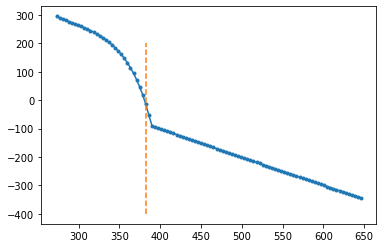

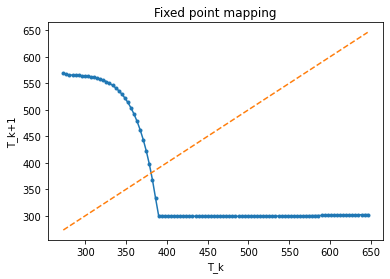

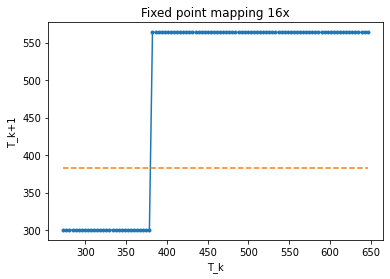

In [825]:
_T_testrange = np.linspace(273.18, 646.096, 100)
_slopes = [slope_field(rhow, T)[0] for T in _T_testrange]
plt.figure()
plt.plot(_T_testrange, _slopes, '.-')
plt.plot(inputs["T_target"]*np.array([1,1]), np.array([-400, 200]), '--')
plt.figure()
plt.plot(_T_testrange, _T_testrange+_slopes, '.-')
plt.plot(_T_testrange, _T_testrange, '--')
plt.ylabel("T_k+1")
plt.xlabel("T_k")
plt.title("Fixed point mapping")

plt.figure()

_fpi_iter = _T_testrange.copy()
for i in range(16):
  _fpi_iter = [T + slope_field(rhow, T)[0] for T in _fpi_iter]

plt.plot(_T_testrange, _fpi_iter, '.-')
plt.plot(_T_testrange, inputs["T_target"]*np.ones_like(_T_testrange), '--')
plt.ylabel("T_k+1")
plt.xlabel("T_k")
plt.title("Fixed point mapping 16x")

In [788]:
# Saturation curve approx from auxiliary equation
T = 515.7118924834391
t = Tc/T
satl_coeffsb = [1.992_740_64, 1.099_653_42, -0.510_839_303,
  -1.754_934_79, -45.517_035_2, -6.746_944_50e5]
satl_powsb_times3 = [
  1, 2, 5, 16, 43, 110]
satv_powsc_times6 = [2, 4, 8, 18, 37, 71]
satv_coeffsc = [-2.031_502_40, -2.683_029_40, -5.386_264_92,
  -17.299_160_5, -44.758_658_1, -63.920_106_3]

_c0 = 1.0-1.0/t
_c2 = _c0**(1.0/3.0)
dsatl = 1.0
for i in range(6):
  dsatl += satl_coeffsb[i] * _c2 ** satl_powsb_times3[i]
_rhol = dsatl * rhoc

_c1 = _c0**(1.0/6.0)
dsatv = 0.0
for i in range(6):
  dsatv += satv_coeffsc[i] * pow(_c1, satv_powsc_times6[i])
dsatv = np.exp(dsatv)
_rhov = dsatv * rhoc

_rhol, _rhov, slope_field(rhow, T)[0], T + slope_field(rhow, T)[0], 


(809.803465775211, 17.526753745010073, -216.46133629016796, 299.2505561932711)

In [806]:
T

515.7118924834391

In [821]:
# T = 515.7118924834391

# Compound step
T_pred = T + slope_field(rhow, T)[0]
sat_info = float_phi_functions.prho_sat(T_pred)
psat_pred, rhol_pred, rhov_pred = sat_info["psat"], \
  sat_info["rho_satl"], sat_info["rho_satv"]
rhow_pred = yw / (v_mix - ym * K / rho_m0 / (psat_pred + K - p_m0))
# iteration_path.append((psat, rhow, T, "interm"))
# d = rhow/rhoc
# rhov_pred <= rhow and rhow <= rhol_pred
# x = (1.0 / rhow - 1.0 / rhol) / (1.0 / rhov - 1.0 / rhol)
# is_mixed = True

def slope_sat(p, rhow, rhol, rhov, T):
  # Accept tentative mixed-phase value of density
  d = rhow / rhoc
  # Compute steam fraction (fraction vapor mass per total water mass)
  x = (1.0 / rhow - 1.0 / rhol) / (1.0 / rhov - 1.0 / rhol)
  # Compute temperature update using saturation relation
  # _phir_all_v = float_phi_functions.fused_phir_all(rhov/rhoc, iapws95_light.Tc/T)
  # _phir_all_l = float_phi_functions.fused_phir_all(rhol/rhoc, iapws95_light.Tc/T)
  d0 = rhol/rhoc
  d1 = rhov/rhoc
  _phirall_0 = float_phi_functions.fused_phir_all(d0, Tc/T)
  _phirall_1 = float_phi_functions.fused_phir_all(d1, Tc/T)
  _phi0all_0 = float_phi_functions.fused_phi0_all(d0, Tc/T)
  _phi0all_1 = float_phi_functions.fused_phi0_all(d1, Tc/T)
  # float_phi_functions.prho_sat(500)

  ''' Derivatives along Maxwell-construction level set G(t, d0, d1) = 0 '''
  # Vector components of partial dG/dt = (dG0/dt; dG1/dt)
  dG0dt = d1*_phirall_1["phir_dt"] + _phirall_1["phir_t"] + _phi0all_1["phi0_t"] \
    - d0*_phirall_0["phir_dt"] - _phirall_0["phir_t"] - _phi0all_0["phi0_t"]
  dG1dt = d0*d0*_phirall_0["phir_dt"] - d1*d1*_phirall_1["phir_dt"]
  # Vector components of partial dG/d0
  dG0dd0 = -2.0*_phirall_0["phir_d"] - d0*_phirall_0["phir_dd"] - _phi0all_0["phi0_d"]
  dG1dd0 = 1.0 + 2.0 * d0 * _phirall_0["phir_d"] + d0*d0*_phirall_0["phir_dd"]
  # Vector components of partial dG/d1
  dG0dd1 = 2.0*_phirall_1["phir_d"] + d1*_phirall_1["phir_dd"] + _phi0all_1["phi0_d"]
  dG1dd1 = -1.0 - 2.0 * d1 * _phirall_1["phir_d"] - d1*d1*_phirall_1["phir_dd"]
  # Compute d(d0)/dt and d(d1)/dt constrainted to level set of G
  _det = dG0dd0 * dG1dd1 - dG0dd1 * dG1dd0
  dd0dt = -(dG1dd1 * dG0dt - dG0dd1 * dG1dt) / _det
  dd1dt = -(-dG1dd0 * dG0dt + dG0dd0 * dG1dt) / _det

  # Construct derivatives of volume:
  #   dv0/dt = partial(v0, t) + partial(v0, d) * dd0/dt
  #   dv0/dT = dv0/dt * dt/dT
  dv0dT = -1.0/(rhoc * d0 * d0) * dd0dt * (-Tc/(T*T))
  dv1dT = -1.0/(rhoc * d1 * d1) * dd1dt * (-Tc/(T*T))
  # Construct derivatives of internal energy
  du0dT = R * Tc * (
    (_phirall_0["phir_dt"] + _phi0all_0["phi0_dt"]) * dd0dt
    + (_phirall_0["phir_tt"] + _phi0all_0["phi0_tt"])
  ) * (-Tc/(T*T))
  du1dT = R * Tc * (
    (_phirall_1["phir_dt"] + _phi0all_1["phi0_dt"]) * dd1dt
    + (_phirall_1["phir_tt"] + _phi0all_1["phi0_tt"])
  ) * (-Tc/(T*T))

  # Construct dx/dT (change in steam fraction subject to mixture
  #   conditions) as partial(x, T) + partial(x, v) * dv/dT
  v = 1.0/(d*rhoc)
  vl = 1.0/(d0*rhoc)
  vv = 1.0/(d1*rhoc)
  partial_dxdT = ((v - vv) * dv0dT - (v - vl) * dv1dT) \
    / ((vv - vl) * (vv - vl))
  partial_dxdv =  1.0 / (vv - vl) # add partial (x, v)
  dvdp = (1.0 - yw) / yw * K / rho_m0 / (
    (psat + K - p_m0)*(psat + K - p_m0))
  # Compute saturation-pressure-temperature slope
  dpsatdT = rhov * rhol / (rhov - rhol) \
    * R * (np.log(rhov / rhol) + _phirall_1["phir"] - _phirall_0["phir"] \
      - t * (_phirall_1["phir_t"] - _phirall_0["phir_t"]))
  dxdT = partial_dxdT + partial_dxdv * dvdp * dpsatdT

  # Construct de/dT for water:
  #   de/dT = partial(e,x) * dx/dT + de/dT
  uv = R * Tc * (_phirall_1["phir_t"] + _phi0all_1["phi0_t"])
  ul = R * Tc * (_phirall_0["phir_t"] + _phi0all_0["phi0_t"])
  dewdT = (uv - ul) * dxdT + x*du1dT + (1.0-x)*du0dT

  # Construct de/dT for mixture, neglecting pdv work of magma
  dedT = yw * dewdT + ym * c_v_m0

  ''' Compute Newton step for temperature '''
  curr_energy = yw * float_phi_functions.u(rhow, T) \
    + ym * (c_v_m0 * T + magma_mech_energy(psat))
  # Temperature migration
  # dT = -(curr_energy - vol_energy/rho_mix)/dedT
  trust_region_size = 1e8
  dT = -(curr_energy - vol_energy/rho_mix)/(dedT + 1e6/trust_region_size)

  return dT, curr_energy - vol_energy/rho_mix

if False:
  # Compare both steps
  # - f / f', f
  _step0, _f0 = slope_field(rhow, T)
  # predicted -f / f', f
  _step1, _f1 = slope_sat(psat_pred, rhow_pred, rhol_pred, rhov_pred, T_pred)

  # Visualize f(T) affine models at each point
  _df0 = -_f0/_step0
  _df1 = -_f1/_step1
  _dummy_T_range = np.linspace(T_pred, T, 100)
  _line_0 = _f0 + _df0 * (_dummy_T_range - T)
  _line_1 = _f1 + _df1 * (_dummy_T_range - T_pred)
  plt.plot(_dummy_T_range, _line_0)
  plt.plot(T, _f0, '.')
  plt.plot(_dummy_T_range, _line_1)
  plt.plot(T_pred, _f1, '.')
  T, _f0, _df0, T_pred, _f1, _df1

  T = (T + T_pred)/2
  T


# Dry vapour energy bound
psat = float_phi_functions.prho_sat(T)["psat"]
dry_vapor_energy = yw * float_phi_functions.u(rhov_pred, T) \
    + ym * (c_v_m0 * T + magma_mech_energy(psat))
# float_phi_functions.u(rhov_pred, T)
if dry_vapor_energy > vol_energy/rho_mix:
  T_new = 


(2149987.720166707, 1786821.8712870013)

In [796]:
T, inputs["T_target"]

(515.7118924834391, 383.0508474576271)

In [888]:
# Target largest error
i_target = np.nanargmax(np.abs(mg_abs_errs[0,...]))
yw, T, rhow = mg_yw.ravel()[i_target], mg_T.ravel()[i_target], \
  mg_rhow.ravel()[i_target]
yw,T,rhow,run_rhow(yw, T, rhow)

(0.30740740740740746,
 644.0677966101696,
 625.375,
 (array([1.43701687e+00, 3.59689705e-06, 4.45402748e-07]),
  0.002331600000616163,
  [(43175261.24790903, 626.0116038887658, 646.096, 'start-subcrit'),
   (41435262.37219215, 625.3729314162962, 644.1508625268909, 'iter-subcrit'),
   (41371836.40016831, 625.3749498689497, 644.0700674827771, 'iter-subcrit'),
   (41370085.61790627, 625.3750026086444, 644.0678383136335, 'iter-subcrit'),
   (41370053.79957048, 625.3750035791476, 644.0677977965906, 'iter-subcrit'),
   (41370053.22809012, 625.3750035965785, 644.067797068875, 'iter-subcrit'),
   (41370053.21782729, 625.3750035968915, 644.067797055807, 'iter-subcrit'),
   (41370053.21764307, 625.375003596897, 644.0677970555723, 'iter-subcrit')],
  {'T_target': 644.0677966101696,
   'p_target': 41370051.7806262,
   'u_target': 1844180.0283830862,
   'rho_mix': 1338.4316436452134,
   'rhom': 2709.819913980769,
   'vol_energy': 2468308906.5664506}))

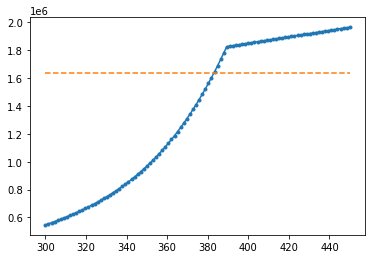

In [878]:
def path_energy(T):
  psat = float_phi_functions.prho_sat(T)["psat"]
  yw = .48518518518518516
  ym = 1 - yw
  return yw * float_phi_functions.u(1.0000000000, T) \
    + ym * (c_v_m0 * T + magma_mech_energy(psat))
  
T_range = np.linspace(300, 450, 100)
ens = [path_energy(T) for T in np.linspace(300, 450, 100)]
plt.plot(T_range, ens, '.-')
plt.plot(T_range, np.ones_like(T_range)*1637659.455255286, '--')

In [872]:
.48518518518518516 / ((1/2.0602586510723673) - (1 - 0.48518518518518516) * K / rho_m0 / (307433.0817540511 + K - p_m0)), \
  float_phi_functions.prho_sat(407.5089536932909)

(0.9999999935279331,
 {'psat': 307433.0817540511,
  'rho_satl': 931.0942826656388,
  'rho_satv': 1.6891547041715276})

In [868]:
float_phi_functions.prho_sat(383.0508474576271)

{'psat': 142901.81817246985,
 'rho_satl': 951.0235674846762,
 'rho_satv': 0.8243564425936399}

In [865]:
float_phi_functions.u(1.00000000539826, 383.0508474576271) * 0.48518518518518516 \
  + (1 - 0.48518518518518516) * (c_v_m0 * 383.0508474576271 + magma_mech_energy(142901.81817246985))

1637659.4508107416

In [867]:
_v_ = .48518518518518516 / 1.0000000496967125 + (1 - 0.48518518518518516)/ 2698.6885834909067
1 / _v_

2.060258753420208

In [838]:
# Low-pressure ideal gas reference state
p_w0 = float_phi_functions.p(rho_w0, T_w0)
e_w0 = float_phi_functions.u(rho_w0, T_w0)
c_v_w0 = float_phi_functions.c_v(rho_w0, T_w0)

997

In [852]:
scipy.optimize.fsolve(lambda rho: float_phi_functions.p(rho, 273.15+100)/1e5 - 1, 1.5, full_output=True)

(array([1.5]),
 {'nfev': 4,
  'fjac': array([[1.]]),
  'r': array([-7.87160613e+09]),
  'qtf': array([0.01417997]),
  'fvec': 0.014179966599554783},
 1,
 'The solution converged.')

In [860]:
p_gas_ref = float_phi_functions.prho_sat(273.15+100)["psat"] # 101417.99665995548
rho_gas_ref = float_phi_functions.prho_sat(273.15+100)["rho_satv"] # 0.5981697919259701
T_gas_ref = 100+273.15
e_gas_ref = float_phi_functions.u(rho_gas_ref, 273.15+100)
c_v_gas_ref = float_phi_functions.c_v(rho_gas_ref, 273.15+100)
e_gas_ref, c_v_gas_ref

(2506022.7123141396, 1555.8307465765565)

In [861]:
# Low-density estimate
vol_energy = 3374002.0602001636
rho_mix = 2.0602586510723673
yw = 0.48518518518518516


_estrhow = yw / (1 / rho_mix - (1 - yw) / rho_m0)
_estT = ((vol_energy / rho_mix) - yw * (e_gas_ref - c_v_gas_ref * T_gas_ref)) \
    / (yw * c_v_gas_ref + ym * c_v_m0)
_estT, _estrhow

(246.4047745376199, 0.9999998090289518)

In [674]:
float_phi_functions.prho_sat(432.0324457771576)

{'psat': 600859.8071983225,
 'rho_satl': 908.5393453288942,
 'rho_satv': 3.1730300680774106}

In [673]:
float_phi_functions.prho_sat(537.2881355932203)

{'psat': 5015811.730753286,
 'rho_satl': 777.0517410546645,
 'rho_satv': 25.435955166292356}

In [628]:
((2630899.55933119 / 1.4133959423321285) - 0.7074074074074074 * (e_w0 - c_v_w0 * T_w0)) \
    / (0.7074074074074074 * c_v_w0 + (1 - 0.7074074074074074) * c_v_m0)

699.902183444459

In [639]:
# Volume-based estimate
rho_mix = 1.4133959423321285
yw = .7074074074074074
vw_approx = (1 / rho_mix - (1 - yw)/rho_m0) / yw
float_phi_functions.u(1.0/(vw_approx), Tc-1.0) 

2922527.3305760003

In [632]:
linear_en = lambda T: .7074074074074074 * (c_v_w0 * (T - T_w0) + e_w0) \
    + (1 - .7074074074074074) * (c_v_m0 * T)
linear_en(699.9)

1861394.7883389941

In [502]:
i, j, k = 5, 5, 10
run_rhow(mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k]), mg_yw[i,j,k], mg_T[i,j,k], mg_rhow[i,j,k]


Supercritical?: False


((array([ 2.21263748e+06, -3.96744352e-02,  7.93114138e+01]),
  0.0010712000002968125,
  [(464297.5047604616, 526.7497992490299, 422.2108310674637, 'LV'),
   (464297.5047604616, 526.7497992490299, 596.0887972688975, 'LV'),
   (11730157.687428238, 526.7497992490299, 537.0655985784158, 'LV'),
   (4997990.492827423, 526.7497992490299, 507.57081207158393, 'LV'),
   (3030827.9904958224, 526.7497992490299, 500.38706703589395, 'LV'),
   (2658217.93713811, 526.7497992490299, 500.0010690043115, 'LV')]),
 0.3625,
 420.6896551724138,
 526.7894736842105)

## Feature Developement: Cython Atomics

In [ ]:
import iapws95_light
vectest_d, vectest_t = np.ones((1000,1)), np.ones((1000,1))
%timeit -n 20 iapws95_light.phir_d(vectest_d, vectest_t)

In [ ]:
import float_phi_functions
%timeit -n 20 [*map(float_phi_functions.phir_d, vectest_d.ravel(), vectest_t.ravel())]

In [ ]:
%timeit -n 20000 iapws95_light.phir_d(1.0, 1.0)
%timeit -n 20000 float_phi_functions.phir_d(1.0, 1.0)

In [ ]:
# Value check
import iapws95_light
import float_phi_functions
iapws95_light.phir_d(1.0, 1.0), float_phi_functions.phir_d(1.0, 1.0), \
  iapws95_light.phir_dd(1.0, 1.0), float_phi_functions.phir_dd(1.0, 1.0), \
  iapws95_light.phir_d(0.7, 0.3), float_phi_functions.phir_d(0.7, 0.3), \
  iapws95_light.phir_dd(0.7, 0.3), float_phi_functions.phir_dd(0.7, 0.3), \
  float_phi_functions.fused_phir_d_phir_dd(1.0, 1.0), \
  float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3),

In [ ]:
%timeit -n 10000 float_phi_functions._dummy(0.7, 0.3)
%timeit -n 10000 float_phi_functions.phir_d(0.7, 0.3)
%timeit -n 10000 float_phi_functions.phir_dd(0.7, 0.3)
%timeit -n 10000 float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3)
%timeit -n 1000 iapws95_light.phir_d(0.7, 0.3)
%timeit -n 1000 iapws95_light.phir_dd(0.7, 0.3)

In [ ]:
# Overhead measurement
%timeit -n 500000 float_phi_functions._dummy(0.7, 0.3)

In [ ]:
''' Extract table from _ndtc '''
# np.set_printoptions(linewidth=60)
# _ndtc.reshape((51,4))[:,0:3].ravel().shape

In [ ]:
''' Single-precision testing (legacy)'''
import single_phi_functions
single_phi_functions.fused_phir_d_phir_dd(1.0, 1.0), \
  single_phi_functions.fused_phir_d_phir_dd(0.7, 0.3),
%timeit -n 10000 single_phi_functions.phir_dd(0.7, 0.3)

In [ ]:
''' Verification values for Cython implementaiton '''
import iapws95_light_perf
iapws95_light_perf.print_verification_values()

## Profiling (profiling Cython is wonky)

In [ ]:
import cProfile
cProfile.run('float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3)')

In [ ]:
# %load_ext line_profiler

import line_profiler
import float_phi_functions
profile = line_profiler.LineProfiler(float_phi_functions.fused_phir_d_phir_dd)
profile.runcall(float_phi_functions.fused_phir_d_phir_dd, 0.7, 0.3)
profile.print_stats()


In [ ]:
import pstats, cProfile
cProfile.runctx("float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3)",
  globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

In [ ]:
def test2(x, y):
  return float_phi_functions.fused_phir_d_phir_dd(x, y)

In [ ]:
profile = line_profiler.LineProfiler(test2)
profile.runcall(test2, 0.7, 0.3)
profile.print_stats()

In [ ]:
dir(profile)

In [ ]:
%load_ext line_profiler
import float_phi_functions
import IPython.core
IPython.core.page = print

In [ ]:
%lprun -f float_phi_functions.fused_phir_d_phir_dd float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3)

## Feature Development: Saturation Curve

In [ ]:
# Saul and Wagner 1987

# Context: (rho, T) -> p_sat by Maxwell construction
t = iapws95_light.Tc / T_ref
rho = rho_ref

# Saturated liquid density correlation (2.3)
_powsb = np.array([1/3, 2/3, 5/3, 16/3, 43/3, 110/3])
_coeffsb = [1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5]
d1 = 1.0 + np.dot((1.0-1.0/t)**_powsb, _coeffsb)
# Saturated vapour density correlation (2.2)
_powsc = np.array([1/3, 2/3, 4/3, 9/3, 37/6, 71/6])
_coeffsc = [-2.02957, -2.68781, -5.38107, -17.3151, -44.6384, -64.3486]
d2 = np.exp(np.dot((1.0-1.0/t)**_powsc, _coeffsc))

# Define size-2 system for d-bounds on phase transition (Maxwell construction)
phir_d = lambda d: iapws95_light.phir_d(d, t)
phir = lambda d: iapws95_light.phir(d, t)
phi0 = lambda d: iapws95_light.phi0(d, t)
eq1 = lambda d1, d2: d2 * phir_d(d2) - d1 * phir_d(d1) - phir(d1) - phi0(d1) +phir(d2) + phi0(d2)
eq2 = lambda d1, d2: d1 + d1**2 * phir_d(d1) - d2 - d2**2 * phir_d(d2)
eqvec = lambda d: np.array([eq1(d[0], d[1]), eq2(d[0], d[1])]).squeeze()

# Solve system using fsolve, initial guess using older sat curve correlations
import scipy.optimize
d_init = np.array([d1, d2])
d_final = scipy.optimize.fsolve(eqvec, d_init)
print("Init, final, residuals:")
print(d_init, d_final, eqvec(d_final))

# Get saturation densities at given T
rho_l, rho_v = d_final * iapws95_light.rhoc

# Use either for saturation pressure
psat = d_final[0]*(1.0 + d_final[0]*iapws95_light.phir_d(d_final[0], t)) \
  * iapws95_light.rhoc * iapws95_light.R * T_ref
# p = d_final[1]*(1.0 + d_final[1]*iapws95_light.phir_d(d_final[1], t)) \
  # * iapws95_light.rhoc * iapws95_light.R * T_ref
p = psat
print(f"psat = {psat}")

# context: 
if rho <= rho_l and rho >= rho_v:
  # Return saturation pressure
  print(f"Mixture")
elif rho < rho_v:
  rho = rho_v/iapws95_light.rhoc
else:
  rho = rho_l/iapws95_light.rhoc

In [ ]:
# Saturation pressure recovery check
d_final[0]*(1.0 + d_final[0]*iapws95_light.phir_d(d_final[0], t)) * iapws95_light.rhoc * iapws95_light.R * T_ref, \
  d_final[1]*(1.0 + d_final[1]*iapws95_light.phir_d(d_final[1], t)) * iapws95_light.rhoc * iapws95_light.R * T_ref

In [ ]:
# Get rho bounds given T
rho_bounds = d_final * iapws95_light.rhoc
rho_l = rho_bounds[0]
rho_v = rho_bounds[1]
# Context: (p, T) -> rho
rho = rho_ref

# Use either for saturation pressure
psat = d_final[0]*(1.0 + d_final[0]*iapws95_light.phir_d(d_final[0], t)) \
  * iapws95_light.rhoc * iapws95_light.R * T_ref
# p = d_final[1]*(1.0 + d_final[1]*iapws95_light.phir_d(d_final[1], t)) \
  # * iapws95_light.rhoc * iapws95_light.R * T_ref
p = psat
print(f"psat = {psat}")

if rho <= rho_l and rho >= rho_v:
  # Return saturation pressure
  print(f"Mixture")
elif rho < rho_v:
  rho = rho_v/iapws95_light.rhoc
else:
  rho = rho_l/iapws95_light.rhoc

print(d)
for i in range(5):
  val = - p / (iapws95_light.rhoc * iapws95_light.R * T_ref) + d + d **2 * iapws95_light.phir_d(d, t)
  deriv = 1 + 2 * d * iapws95_light.phir_d(d, t) + d**2 * iapws95_light.phir_dd(d, t)
  d -= val / deriv
  print(d)
print(d * iapws95_light.rhoc)

## Structure development

In [ ]:
import csv
import numpy as np

''' Data loading ''' 

DATAPATH_IDEAL = 'ideal.csv'
DATAPATH_RES0 = 'residual_1_51.csv'
DATAPATH_RES1 = 'residual_52_54.csv'
DATAPATH_RES2 = 'residual_55_56.csv'

with open(DATAPATH_IDEAL, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  ideal_arraydict = [row for row in reader]

with open(DATAPATH_RES0, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  residual0_arraydict = [row for row in reader]

with open(DATAPATH_RES1, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  residual1_arraydict = [row for row in reader]

with open(DATAPATH_RES2, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  residual2_arraydict = [row for row in reader]

''' Data prep '''
n_ideal = np.array([float(obj["n_i"]) for obj in ideal_arraydict])
g_ideal = np.array([float(obj["g_i"]) for obj in ideal_arraydict])

# Compile shared residual coefficients
n_res = np.hstack(([float(obj["n_i"]) for obj in residual0_arraydict],
  [float(obj["n_i"]) for obj in residual1_arraydict],
  [float(obj["n_i"]) for obj in residual2_arraydict]))
d_res = np.hstack(([float(obj["d_i"]) for obj in residual0_arraydict],
  [float(obj["d_i"]) for obj in residual1_arraydict],
  [1.0 for obj in residual2_arraydict]))
t_res = np.hstack(([float(obj["t_i"]) for obj in residual0_arraydict],
  [float(obj["t_i"]) for obj in residual1_arraydict],
  [0.0 for obj in residual2_arraydict]))

c_res1_51 = np.array([float(obj["c_i"]) for obj in residual0_arraydict])

c_res52_54 = np.array([float(obj["c_i"]) for obj in residual1_arraydict])
alpha_res52_54 = np.array([float(obj["alpha_i"]) for obj in residual1_arraydict])
beta_res52_54 = np.array([float(obj["beta_i"]) for obj in residual1_arraydict])
gamma_res52_54 = np.array([float(obj["gamma_i"]) for obj in residual1_arraydict])
eps_res52_54 = np.array([float(obj["eps_i"]) for obj in residual1_arraydict])

a_res55_56 = np.array([float(obj["a_i"]) for obj in residual2_arraydict])
b_res55_56 = np.array([float(obj["b_i"]) for obj in residual2_arraydict])
B_res55_56 = np.array([float(obj["B_i"]) for obj in residual2_arraydict])
C_res55_56 = np.array([float(obj["C_i"]) for obj in residual2_arraydict])
D_res55_56 = np.array([float(obj["D_i"]) for obj in residual2_arraydict])
A_res55_56 = np.array([float(obj["A_i"]) for obj in residual2_arraydict])
beta_res55_56 = np.array([float(obj["beta_i"]) for obj in residual2_arraydict])

''' Set up static parameters '''
Tc = 647.096  # K
rhoc = 322    # kg / m^3
R = 0.46151805 # kJ / kg K
# Generic precomputation
_exp1_55_56 = 0.5 / (beta_res55_56)

In [ ]:
''' Simulate input '''
rho = 838.025
T = 500

rho = 358
T = 647

In [ ]:
''' Compute reduced variables '''

# Reciprocal reduced volume
d = rho / rhoc
# Reciprocal reduced temperature
t = Tc / T

In [ ]:
def phi(d, t):
  ''' Reduced Helmholtz function f/(RT). ''' 

  # Scalar precomputation
  d_quad = (d-1.0)**2

  ''' Ideal-gas part of Helmholtz function f '''
  phi0 = np.log(d) + n_ideal[0] + n_ideal[1] * t + n_ideal[2] * np.log(t)
  phi0 += np.dot(n_ideal[3:8], np.log(1.0 - np.exp(-g_ideal[3:8] * t)))

  ''' Residual part of Helmholtz function f
  Evaluated using two registers that combine as
    np.dot( coeffs, np.exp(exponents) ).
  '''
  # Allocate exponent cache
  exponents = np.zeros_like(n_res)
  # Allocate and evaluate coeffs
  coeffs = n_res * (d ** d_res) * (t ** t_res)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Factor in Delta**b_i term for 1-indices from 55 to 56
  coeffs[54:56] *= Delta ** b_res55_56

  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1)**2

  # Compute residual part of reduced Helmholtz
  phir = np.dot(coeffs, np.exp(exponents))

  return (phi0, phir)

def Z(d, t):
  ''' Compressibility factor evaluation
  The compressibility factor Z is given by
    Z == p * v / (R * T) = 1 + delta * d(phi_R)/d(delta),
  where d(phi_R)/d(delta) is the partial derivative of the residual
  part of the reduced Helmholtz function, with respect to d = rho/rhoc.
  Evaluated using two registers that combine as
    np.dot( coeffs, np.exp(exponents) ).
  '''

  # Scalar precomputation
  d_quad = (d-1)**2

  # Allocate exponent cache
  exponents = np.zeros_like(n_res)
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** (d_res-1)) * (t ** t_res)
  # Factor in d_i - c_i * d**c_i term
  coeffs[0:51] *= (d_res[0:51] - c_res1_51 * d ** c_res1_51)
  coeffs[51:54] *= d_res[51:54] - 2.0 * alpha_res52_54 * d * (d - eps_res52_54)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Factor in other terms for 1-indices from 55 to 56 in two steps
  coeffs[54:56] *= (
    Delta * (1.0 - 2.0 * C_res55_56 * (d-1.0) * d)
    + b_res55_56 * d * (d-1.0) * (
      A_res55_56 * theta * 2 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
      + 2 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
    )
  )
  coeffs[54:56] *= Delta ** np.where(Delta != 0, b_res55_56-1, 1.0)

  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1)**2

  # Reduce
  phir_d = np.dot(coeffs, np.exp(exponents))
  return 1 + d * phir_d


In [ ]:
''' Compute reduced variables '''
# Reciprocal reduced volume
d = rho / rhoc
# Reciprocal reduced temperature
t = Tc / T

# phi, phir_d, Z
print(f"phi0 = {phi(d, t)[0]:.8f}, phir = {phi(d, t)[1]:.8f}, phir_d = {(Z(d, t) - 1)/d:.9f}")

# Print verification values
verification_string = '''
For T = 647 K, rho = 358 kg m^{-3}:
phi0 = -1.56319605
phir = -1.21202657
phir_d = -0.714012024
'''
print(verification_string)


In [ ]:
from time import perf_counter

print(f"Timing p(rho, T) calculations.")
# Timing for pressure evaluation
N_timing = 25000
t1 = perf_counter()
for i in range(N_timing):
  p = Z(rho / rhoc, Tc / T) * rho * R * T
t2 = perf_counter()

t1_ideal = perf_counter()
for i in range(N_timing):
  p_ideal = rho * R * T
t2_ideal = perf_counter()

print(f"IAPWS95 light: {(t2-t1)/N_timing * 1e3} ms")
print(f"Ideal gas    : {(t2_ideal-t1_ideal)/N_timing * 1e3} ms")
print(f"Relative load: {(t2-t1)/(t2_ideal-t1_ideal):.3f}x")

num_coeffs = 44*4 + 21 + 21 + 16 + 13
print(f"=== Additional details ===")
print(f"Number of coefficients in model: {num_coeffs}")
print(f"Relative load per model dof:     {(t2-t1)/(t2_ideal-t1_ideal)/num_coeffs:.3f}x")

In [ ]:
def phi0_t(d, t):
  ''' Ideal-gas part of Helmholtz function f '''
  phi0 = n_ideal[1] + n_ideal[2] / t
  phi0 += np.expand_dims(np.einsum("i, ...i -> ...", n_ideal[3:8] * g_ideal[3:8],
    1.0/(1.0 - np.exp(-g_ideal[3:8] * t)) - 1.0), axis=-1)

  # Reduce
  return phi0

def phir_t(d, t):
  ''' Derivative of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** d_res) * (t ** (t_res-1.0))
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= t_res[0:51]
  # Factor in d_i - c_i * d**c_i term for 1-indices 52 to 54
  coeffs[...,51:54] *= t_res[51:54] - 2.0 * beta_res52_54 * t * (t - gamma_res52_54)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56 in two steps
  coeffs[...,54:56] = n_res[54:56] * d * 2.0 * (
    -theta * b_res55_56 + Delta * D_res55_56 * (1.0 - t))
  coeffs[...,54:56] *= Delta ** np.where(Delta != 0, b_res55_56-1, 1.0)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

In [ ]:
phi0_t(d, t), 0.980_343_918e1, phir_t(d, t), -0.321_722_501e1

In [ ]:
_input = np.tile(np.array([t]), (10,1))
_input.shape

In [ ]:
phir_t(np.tile(np.array([d]), (10,1)), np.tile(np.array([t]), (10,1)))
phir_t(d, t)

In [ ]:
_exp1_55_56

In [ ]:
def phir_dd(d, t):
  ''' Second derivative dd of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** (d_res-2.0)) * (t ** t_res)
  # Temporary space
  cdc = c_res1_51 * (d ** c_res1_51)
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= (d_res[0:51] - cdc) * (d_res[0:51] - 1.0 - cdc) \
    - c_res1_51 * cdc
  # Factor for 1-indices 52 to 54
  coeffs[...,51:54] *= -2 * alpha_res52_54 * d**2 \
    + 4 * alpha_res52_54**2 * d**2 * (d - eps_res52_54)**2 \
    - 4 * d_res[51:54] * alpha_res52_54 * d * (d - eps_res52_54) \
    + d_res[51:54] * (d_res[51:54] - 1.0)

  # Compute distance term for 1-indices 55 to 56
  theta = (1.0 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Compute d(Delta)/d(delta) divided by (delta - 1.0)
  dDelta_div = (
    A_res55_56 * theta * 2.0 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
    + 2 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
  )
  # Set power to non-negative when argument is negative
  limited_power = np.where(d_quad != 0, _exp1_55_56 - 2.0, 1.0)
  ddDelta = dDelta_div + ((d-1.0)**2) * (
    4.0 * B_res55_56 * a_res55_56 * (a_res55_56 - 1.0)
    * d_quad**(a_res55_56 - 2.0)
    + 2.0 * (A_res55_56 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0))**2.0
    + 4.0 * theta * A_res55_56 / beta_res55_56 * (_exp1_55_56 - 1.0)
    * d_quad**limited_power
  )
  # Finish d(Delta)/d(delta) computation
  dDelta = (d-1.0) * dDelta_div
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56
  coeffs[...,54:56] = Delta**2 * (-4 * C_res55_56 * (d-1.0) 
    + d * (2*C_res55_56*d_quad - 1.0) * 2.0 * C_res55_56)
  coeffs[...,54:56] += Delta * 2.0 * b_res55_56 * dDelta \
    * (1.0 - 2.0 * d * C_res55_56 * (d - 1.0))
  coeffs[...,54:56] += b_res55_56 * (Delta * ddDelta
    + (b_res55_56 - 1.0) * dDelta**2) * d
  coeffs[...,54:56] *= n_res[54:56] \
    * Delta ** np.where(Delta != 0, b_res55_56 - 2.0, 1.0)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -cdc[7:51] / c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1.0)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

def phir_dt(d, t):
  ''' Second derivative dt of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** (d_res-1.0)) * (t ** (t_res-1.0))
  dc = d ** c_res1_51
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= t_res[0:51] * (d_res[0:51] - c_res1_51 * dc)
  # Factor for 1-indices 52 to 54
  coeffs[...,51:54] *= d_res[51:54] - 2.0 * alpha_res52_54 * d * (d - eps_res52_54)
  coeffs[...,51:54] *= t_res[51:54] - 2.0 * beta_res52_54 * t * (t - gamma_res52_54)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Compute d(Delta)/d(delta)
  dDelta = (d-1.0) * (
    A_res55_56 * theta * 2.0 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
    + 2.0 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
  )
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56 in two steps
  coeffs[...,54:56] = n_res[54:56] * (
    Delta**2 * (-2.0 * D_res55_56 * (t - 1.0) + d * 4.0 * C_res55_56 *
    D_res55_56 * (d - 1.0) * (t - 1.0))
    + d * Delta * b_res55_56 * dDelta * (-2.0 * D_res55_56 * (t - 1.0))
    - 2.0 * theta * b_res55_56 * Delta * (1.0 - 2.0*d*C_res55_56*(d - 1.0))
    + d * (
      -A_res55_56 * b_res55_56 * 2.0 / beta_res55_56 * Delta * (d - 1.0)
      * d_quad ** (_exp1_55_56 - 1.0)
      - 2.0 * theta * b_res55_56 * (b_res55_56 -1.0) * dDelta
    )
  )
  coeffs[...,54:56] *= Delta ** np.where(Delta != 0, b_res55_56 - 2.0, 1.0)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -dc[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1.0)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

def phir_tt(d, t):
  ''' Second derivative tt of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** d_res) * (t ** (t_res-2.0))
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= t_res[0:51] * (t_res[0:51] - 1.0)
  # Factor for 1-indices 52 to 54
  coeffs[...,51:54] *= (t_res[51:54] - 2.0 * beta_res52_54 * t * 
    (t - gamma_res52_54))**2 - t_res[51:54] - 2.0 * beta_res52_54 * t**2

  # Compute distance term for 1-indices 55 to 56
  theta = (1.0 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56 in two steps
  coeffs[...,54:56] = n_res[54:56] * d * (
    2.0 * b_res55_56 * (Delta + 2.0 * theta**2 * (b_res55_56 - 1.0)
    + 4.0 * theta * Delta * D_res55_56 * (t - 1.0))
    + Delta ** 2 * 2.0 * D_res55_56 * (2.0*D_res55_56 * (t - 1.0)**2 - 1.0)
  )
  coeffs[...,54:56] *= Delta ** np.where(Delta != 0, b_res55_56 - 2.0, 1.0)
  # Set phir_tt at rho == 1 to -inf gracefully
  coeffs[...,54:56] = np.where(Delta != 0, coeffs[...,54:56], -np.inf)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1.0)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

In [ ]:
b_res55_56[0] * (2.0 * Delta +
  4.0 * theta ** 2 * (b_res55_56[0] - 1.0))

In [ ]:
2.0 * b_res55_56[0] * Delta, \
  4.0 * theta ** 2 * b_res55_56[0] * (b_res55_56[0] - 1.0), \
  8.0 * theta * b_res55_56[0] * Delta * D_res55_56[0] * (t - 1.0), \
  Delta ** 2 * 2.0 * D_res55_56[0] * (2.0*D_res55_56[0] * (t - 1.0)**2 - 1.0), \
  n_res[54] * d * Delta ** (b_res55_56[0] - 2.0) * np.exp(-C_res55_56[0] * d_quad \
    -D_res55_56[0]*(t - 1.0)**2)


In [ ]:
d, t = 1.0-1e-10, 1.05
d_quad = (d-1.0)**2
theta = (1.0 - t) + A_res55_56[0] * d_quad ** _exp1_55_56[0]
Delta = theta**2 + B_res55_56[0] * d_quad ** a_res55_56[0]
n_res[54] * d * (
    2.0 * b_res55_56[0] * Delta
    + 4.0 * theta ** 2 * b_res55_56[0] * (b_res55_56[0] - 1.0)
    + 8.0 * theta * b_res55_56[0] * Delta * D_res55_56[0] * (t - 1.0)
    + Delta ** 2 * 2.0 * D_res55_56[0] * (2.0*D_res55_56[0] * (t - 1.0)**2 - 1.0)
  ) * Delta ** (b_res55_56[0] - 2.0) * np.exp(-C_res55_56[0] * d_quad \
    -D_res55_56[0]*(t - 1.0)**2)
    
    
    
    # , Delta ** (b_res55_56[0] - 2.0), np.exp(-C_res55_56[0] * d_quad \
    # -D_res55_56[0]*(t - 1.0)**2)

In [ ]:
rhoc

In [ ]:
-R*phir_tt(321.999/rhoc, 1)[0]

In [ ]:
# Limit testing
eps_like = 1e-5
print(phir_dd(1-eps_like, 1)[0], phir_dt(1-eps_like, 1)[0], phir_tt(1-eps_like, 1.)[0])
print(phir_dd(1, 1)[0], phir_dt(1, 1)[0], phir_tt(1, 1.)[0])
print(phir_dd(1+eps_like, 1)[0], phir_dt(1+eps_like, 1)[0], phir_tt(1+eps_like, 1.)[0])

In [ ]:
phir_dd(d, t)[0], 0.475_730_696, phir_tt(d, t)[0], -0.996_029_507e1, phir_dt(d, t)[0], -0.133_214_720e1, 

###  Free evaluation

In [ ]:
''' Helmholtz evaluation ''' 

''' Ideal-gas part of Helmholtz function f '''
phi0 = np.log(d) + n_ideal[0] + n_ideal[1] * t + n_ideal[2] * np.log(t)
phi0 += np.dot(n_ideal[3:8], np.log(1.0 - np.exp(-g_ideal[3:8] * t)))

''' Residual part of Helmholtz function f
Evaluated using two registers that combine as
  np.dot( coeffs, np.exp(exponents) ).
'''

# Scalar precomputation
d_quad = (d-1)**2

# Allocate exponent cache
exponents = np.zeros_like(n_res)
# Allocate and evaluate coeffs
coeffs = n_res * (d ** d_res) * (t ** t_res)

# Compute distance term for 1-indices 55 to 56
theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56

# Factor in Delta**b_i term for 1-indices from 55 to 56
coeffs[54:56] *= Delta ** b_res55_56

# Compute exponents for 1-indices 8 to 51 as -d**c_i
exponents[7:51] = -d ** c_res1_51[7:51]
# Compute exponents for 1-indices from 52 to 54
exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
  -beta_res52_54*(t - gamma_res52_54)**2
# Compute exponents for 1-indices from 55 to 56
exponents[54:56] = -C_res55_56 * d_quad \
  -D_res55_56*(t - 1)**2

# Add residual part
phir = np.dot(coeffs, np.exp(exponents))

In [ ]:
''' Compressibility factor evaluation
The compressibility factor Z is given by
  Z == p * v / (R * T) = 1 + delta * d(phi_R)/d(delta).
''' 

''' Partial derivative of residual part of Helmholtz function.
Evaluated using two registers that combine as
  np.dot( coeffs, np.exp(exponents) ).
'''

# Scalar precomputation
d_quad = (d-1)**2

# Allocate exponent cache
exponents = np.zeros_like(n_res)
# Allocate and partially evaluate coeffs
coeffs = n_res * (d ** (d_res-1)) * (t ** t_res)

# Compute distance term for 1-indices 55 to 56
theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56

# Factor in d_i - c_i * d**c_i term
coeffs[0:51] *= (d_res[0:51] - c_res1_51 * d ** c_res1_51)
coeffs[51:54] *= d_res[51:54] - 2.0 * alpha_res52_54 * d * (d - eps_res52_54)
# Factor in other terms for 1-indices from 55 to 56 in two steps
coeffs[54:56] *= (
  Delta * (1.0 - 2.0 * C_res55_56 * (d-1.0) * d)
  + b_res55_56 * d * (d-1.0) * (
    A_res55_56 * theta * 2 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
    + 2 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
  )
)
coeffs[54:56] *= Delta ** np.where(Delta != 0, b_res55_56-1, 1.0)

# Compute exponents for 1-indices 8 to 51 as -d**c_i
exponents[7:51] = -d ** c_res1_51[7:51]
# Compute exponents for 1-indices from 52 to 54
exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
  -beta_res52_54*(t - gamma_res52_54)**2
# Compute exponents for 1-indices from 55 to 56
exponents[54:56] = -C_res55_56 * d_quad \
  -D_res55_56*(t - 1)**2

# Reduce
phir_d = np.dot(coeffs, np.exp(exponents))
Z = 1 + d * phir_d